# Prediction of Booking Cancelation

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score


/var/folders/t_/t17z84q161x8dcgl_1nslzxr0000gn/T/ipykernel_5677/3045017787.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/Work/Job/Full Time/Taiwan/Interview/友達/project/GHR_Cancellation_Analysis/Data/R2_final_hotels.csv')
Data.columns

Index(['ArrivalDate', 'ArrivalWeekNumber', 'AssignedRoom', 'AverageDailyRate',
       'BookingChanges', 'BookingCompany', 'BookingDistributionChannel',
       'BookingMeal', 'BookingParking', 'Country', 'CustomerType',
       'DaysInWaitingList', 'DepositType', 'LeadTime', 'MarketSegment',
       'NumberOfAdult', 'NumberOfBabies', 'NumberOfChildren',
       'PreviousBookingsNotCanceled', 'PreviousCancellations', 'RepeatedGuest',
       'ReservationStatus', 'ReservationStatusDate', 'ReservedRoom',
       'StaysInWeekendNights', 'StaysInWeekNights', 'TotalOfSpecialRequests',
       'TravelAgent'],
      dtype='object')

In [8]:
#filter out cancellations
#label cancelation(1 = canceled, 0 = not canceled)
def Label_CancelType(row):
    #cancel
    if row['ReservationStatus'] == 'Canceled':
        return 1
    #no cancel
    else:
        return 0

Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days
#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['ReservationStatus'] != 0) & (Data['days_difference'] < 0)].index)
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)


In [9]:
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
6      2017-06-12                 24            A            130.17   
9      2017-05-24                 21            A            120.90   
10     2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
94349  2017-12-11                 50            A             94.15   
94351  2017-09-22                 38            A            100.65   
94354  2017-09-06                 36            E            196.94   
94357  2017-11-10                 45            D             96.94   
94360  2017-09-24                 38            A            171.88   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
6                   0             NaN                      TA/TO          BB   
9                   0             NaN                      TA/TO          BB   
10                  0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94349               0             NaN                     Direct          BB   
94351               0             NaN                      TA/TO          BB   
94354               0             NaN                      TA/TO          BB   
94357               0             NaN                      TA/TO          BB   
94360               0             NaN                      TA/TO          BB   

       BookingParking Country  ... RepeatedGuest  ReservationStatus  \
2                 0.0     ITA  ...             0           Canceled   
3                 0.0     CHE  ...             0           Canceled   
6                 0.0     PRT  ...             0           Canceled   
9                 0.0     PRT  ...             0           Canceled   
10                0.0     PRT  ...             0           Canceled   
...               ...     ...  ...           ...                ...   
94349             0.0     BEL  ...             0          Check-Out   
94351             0.0     PRT  ...             0           Canceled   
94354             0.0     DEU  ...             0           Canceled   
94357             0.0     FRA  ...             0           Canceled   
94360             0.0     PRT  ...             0           Canceled   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
2                2015-07-09             A                    2   
3                2017-05-02             D                    1   
6                2017-01-24             A                    0   
9                2017-04-12             A                    0   
10               2016-01-21             A                    0   
...                     ...           ...                  ...   
94349            2017-12-11             A                    2   
94351            2017-01-16             A                    1   
94354            2017-05-02             D                    1   
94357            2017-09-28             D                    1   
94360            2017-07-23             A                    2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
2                      1                       0         17.0   
3                      3                       1          9.0   
6                      2                       0        154.0   
9                      1                       1          9.0   
10                     4                       0         30.0   
...                  ...                     ...          ...   
94349                  2                       1         14.0   
94351                  3  

In [10]:
#Check Null Value
Data.isnull().sum()

ArrivalDate                        0
ArrivalWeekNumber                  0
AssignedRoom                       1
AverageDailyRate                   0
BookingChanges                     0
BookingCompany                 38230
BookingDistributionChannel         2
BookingMeal                        0
BookingParking                     2
Country                           90
CustomerType                       0
DaysInWaitingList                  0
DepositType                        2
LeadTime                           0
MarketSegment                      0
NumberOfAdult                      0
NumberOfBabies                     0
NumberOfChildren                   3
PreviousBookingsNotCanceled        0
PreviousCancellations              0
RepeatedGuest                      0
ReservationStatus                  0
ReservationStatusDate              0
ReservedRoom                       0
StaysInWeekendNights               0
StaysInWeekNights                  0
TotalOfSpecialRequests             0
T

In [ ]:
#drop BookingCompany
Data.drop('BookingCompany', axis=1, inplace=True)
Data = Data.dropna()
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2017-08-14                 33            A             78.49   
1      2017-04-24                 17            A            113.86   
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
4      2016-10-12                 41            A            129.25   
...           ...                ...          ...               ...   
94359  2017-09-18                 38            F            190.87   
94360  2017-09-24                 38            A            171.88   
94361  2017-11-28                 48            A             88.68   
94362  2017-11-03                 44            A             72.41   
94363  2017-09-19                 38            A            101.03   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          SC             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          HB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
94359               1                     Direct          BB             0.0   
94360               0                      TA/TO          BB             0.0   
94361               0                      TA/TO          SC             0.0   
94362               1                      TA/TO          SC             0.0   
94363               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         BRA        Transient  ...                      0             0   
1         AUT  Transient-Party  ...                      0             0   
2         ITA  Transient-Party  ...                      0             0   
3         CHE        Transient  ...                      0             0   
4         PRT        Transient  ...                      0             0   
...       ...              ...  ...                    ...           ...   
94359     PRT        Transient  ...                      0             0   
94360     PRT  Transient-Party  ...                      1             0   
94361     NLD        Transient  ...                      0             0   
94362     AUS        Transient  ...                      0             0   
94363     PRT         Contract  ...                      0             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2017-08-21            A                     2   
1                 2017-04-27            A                     2   
2                 2015-07-09            A                     2   
3                 2017-05-02            D                     1   
4                 2016-10-16            A                     0   
...                      ...          ...                   ...   
94359             2017-09-20            D                     1   
94360             2017-07-23            A                     2   
94361             2017-12-29            A                     2   
94362             2017-11-05            A                     0   
94363             2017-09-20            A                     1   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      4                       2          9.0   
1                      2                       0         21.0   
2                      1                       0         17.0   
3                      3                       1          9.0   
4                      2                       2          9.0   
...                  ...                     ...          ...   
94359              

In [7]:
Data.isnull().sum()

ArrivalDate                    0
ArrivalWeekNumber              0
AssignedRoom                   0
AverageDailyRate               0
BookingChanges                 0
BookingDistributionChannel     0
BookingMeal                    0
BookingParking                 0
Country                        0
CustomerType                   0
DaysInWaitingList              0
DepositType                    0
LeadTime                       0
MarketSegment                  0
NumberOfAdult                  0
NumberOfBabies                 0
NumberOfChildren               0
PreviousBookingsNotCanceled    0
PreviousCancellations          0
RepeatedGuest                  0
ReservationStatusDate          0
ReservedRoom                   0
StaysInWeekendNights           0
StaysInWeekNights              0
TotalOfSpecialRequests         0
TravelAgent                    0
days_difference                0
CancelType                     0
dtype: int64

## Preprocessing

In [8]:
Data = Data[Data['AverageDailyRate'] > 0]
Data = Data[Data['LeadTime'] <= 300]
Data = Data[Data['NumberOfAdult'] > 0]
Data = Data[Data['DaysInWaitingList'] <= 14]
Data = Data[Data['StaysInWeekNights'] + Data['StaysInWeekendNights'] > 0]

In [9]:
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Data['AssignedRoom'] = Data['AssignedRoom'].str.replace(' ','')
Data['ReservedRoom'] = Data['ReservedRoom'].str.replace(' ','')

In [10]:
# Family
Data['Is_family'] = (Data['NumberOfChildren'] > 0) | (Data['NumberOfBabies'] > 0)
Data['Is_family'] = Data['Is_family'].astype(int)

In [11]:
# Weekend & total of night
Data['Is_weekend'] = (Data['StaysInWeekendNights'] > 0).astype(int)
Data['TotalNights'] = Data['StaysInWeekendNights'] + Data['StaysInWeekNights']

In [ ]:
Data.drop('ArrivalDate', axis=1, inplace=True)
Data.drop('ReservationStatusDate', axis=1, inplace=True)
Data.drop('ReservationStatus', axis=1, inplace=True)
Data.drop('days_difference', axis=1, inplace=True)
Data.drop('Country', axis=1, inplace=True)

In [13]:
#One Hot Enocde Categorical data
Data= pd.get_dummies(Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','CustomerType','DepositType','MarketSegment'])
Data

ArrivalWeekNumber  AverageDailyRate  BookingChanges  BookingParking  \
0                     33             78.49               0             0.0   
1                     17            113.86               0             0.0   
2                     35             94.51               0             0.0   
3                     33            124.99               0             0.0   
4                     41            129.25               0             0.0   
...                  ...               ...             ...             ...   
94358                 49             80.54               0             0.0   
94359                 38            190.87               1             0.0   
94361                 48             88.68               0             0.0   
94362                 44             72.41               1             0.0   
94363                 38            101.03               0             0.0   

       DaysInWaitingList  LeadTime  NumberOfAdult  NumberOfBabies  \
0                      0         8              2               0   
1                      0        77              2               0   
2                      0       117              2               0   
3                      0       265              2               0   
4                      0         0              2               0   
...                  ...       ...            ...             ...   
94358                  0        51              2               0   
94359                  0         0              1               0   
94361                  0        18              2               0   
94362                  0        74              2               0   
94363                  0        45              2               0   

       NumberOfChildren  PreviousBookingsNotCanceled  ...  \
0                   0.0                            0  ...   
1                   0.0                            0  ...   
2                   0.0                            0  ...   
3                   0.0                            0  ...   
4                   0.0                            0  ...   
...                 ...                          ...  ...   
94358               0.0                            0  ...   
94359               0.0                            0  ...   
94361               0.0                            0  ...   
94362               0.0                            0  ...   
94363               0.0                            0  ...   

       DepositType_No Deposit  DepositType_Non Refund  DepositType_Refundable  \
0                        True                   False                   False   
1                        True                   False                   False   
2                        True                   False                   False   
3                        True                   False                   False   
4                        True                   False                   False   
...                       ...                     ...                     ...   
94358                    True                   False                   False   
94359                    True                   False                   False   
94361                    True                   False                   False   
94362                    True                   False                   False   
94363                    True                   False                   False   

       MarketSegment_Aviation  MarketSegment_Complementary  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   
...                       ...                          ...   
94358                   False                        False   
94359                   False          

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [ ]:
y = Data['CancelType']
X = Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns


### Logistic Regression

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=215)

In [16]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train, y_train)


LogisticRegression(random_state=42, solver='liblinear')

Cohen's Kappa Score: 0.5007229504836368
AUC Score: 0.7319297319390987
Accuracy: 0.7870828331332533
Precision: 0.8061921994370728
Recall: 0.536096256684492
F1 Score: 0.64396980889674


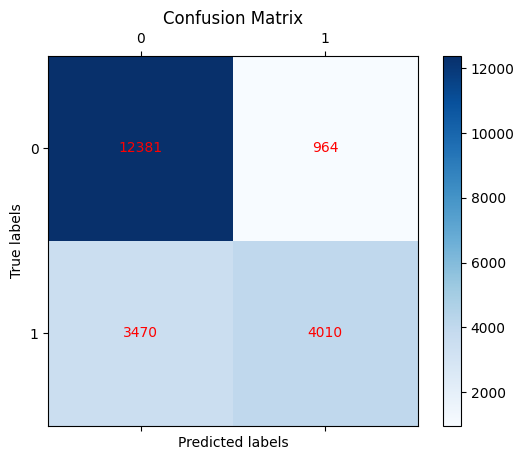

In [17]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

<Figure size 1000x800 with 0 Axes>

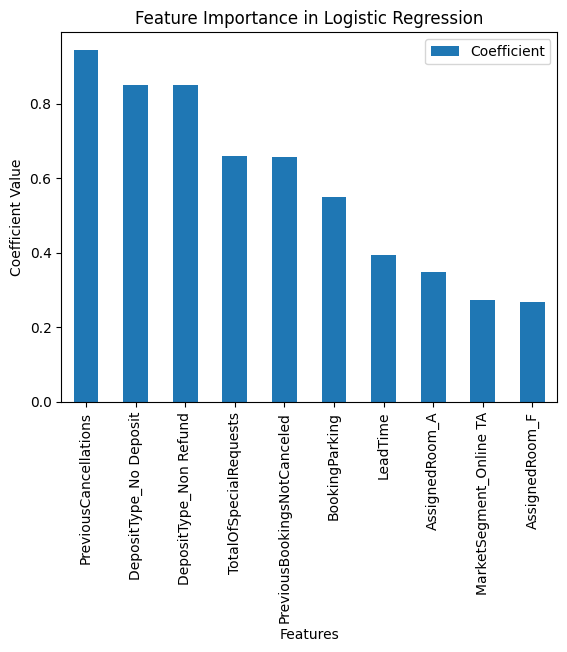

In [18]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).abs().sort_values(by='Coefficient', ascending=False)
#print(feature_importance)
feature_importance_Top_10= feature_importance[0:10]
plt.figure(figsize=(10, 8)) 
# Plotting
feature_importance_Top_10.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()



In [19]:
feature_importance_Top_10= feature_importance[0:10]
feature_importance_Top_10

Coefficient
PreviousCancellations           0.944628
DepositType_No Deposit          0.851103
DepositType_Non Refund          0.849323
TotalOfSpecialRequests          0.660108
PreviousBookingsNotCanceled     0.657257
BookingParking                  0.549419
LeadTime                        0.393176
AssignedRoom_A                  0.348553
MarketSegment_Online TA         0.272239
AssignedRoom_F                  0.266770

### SVM

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Cohen's Kappa Score: 0.3558551860908563
AUC Score: 0.6508093770223781
Accuracy: 0.7486674669867948
Precision: 0.9899650959860384
Recall: 0.3033422459893048
F1 Score: 0.46438804748260337


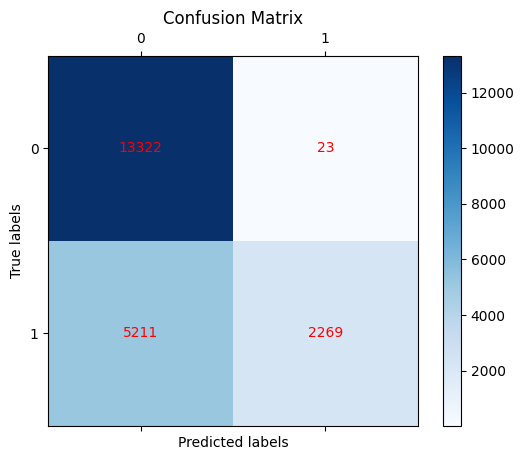

In [21]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')    
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [22]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[5.96918570e-05 7.59238985e-05 6.84877267e-05 1.19169252e-04
 8.77916152e-06 1.62797863e-04 1.78137036e-05 2.58782348e-05
 2.67944312e-05 3.73593226e-01 5.65832892e-01 1.32704618e-05
 1.05390739e-05 4.80359509e-05 2.35976849e-04 4.36785935e-05
 8.99803628e-06 2.15937433e-05 4.31649738e-05 9.46330515e-05
 1.44011789e-05 1.65407152e-05 2.02728818e-05 4.02073876e-05
 1.08965910e-04 6.28411614e-05 4.65971949e-05 6.94265917e-06
 8.68035433e-07 1.55064862e-05 3.73232609e-05 4.83481303e-05
 1.76684935e-06 2.39197713e-05 4.28196142e-06 1.81927305e-05
 1.05810116e-06 8.94339571e-04 4.05143124e-02 5.77074381e-04
 7.48786727e-04 1.37248465e-05 1.61401555e-05 4.04325199e-05
 3.38439120e-05 2.81582808e-01 2.81368574e-01 1.01370581e-02
 1.41889314e-05 4.90234135e-06 3.67092845e-05 5.69558420e-05
 1.87213702e-05 6.17333798e-05 9.67176074e-05]


### Random Forest

In [23]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Cohen's Kappa Score: 0.5370453250234233
AUC Score: 0.7541733369665179
Accuracy: 0.7982713085234093
Precision: 0.789613142554319
Recall: 0.5975935828877005
F1 Score: 0.6803135225629708


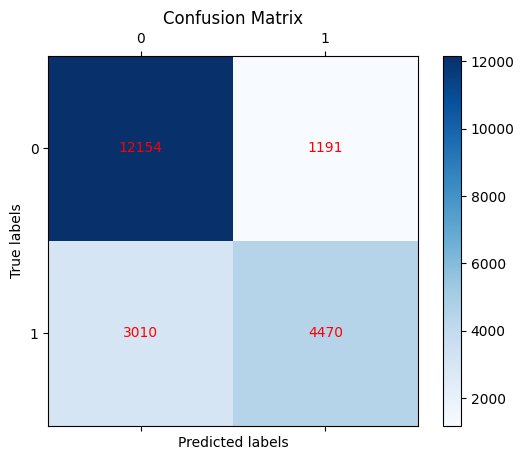

In [24]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

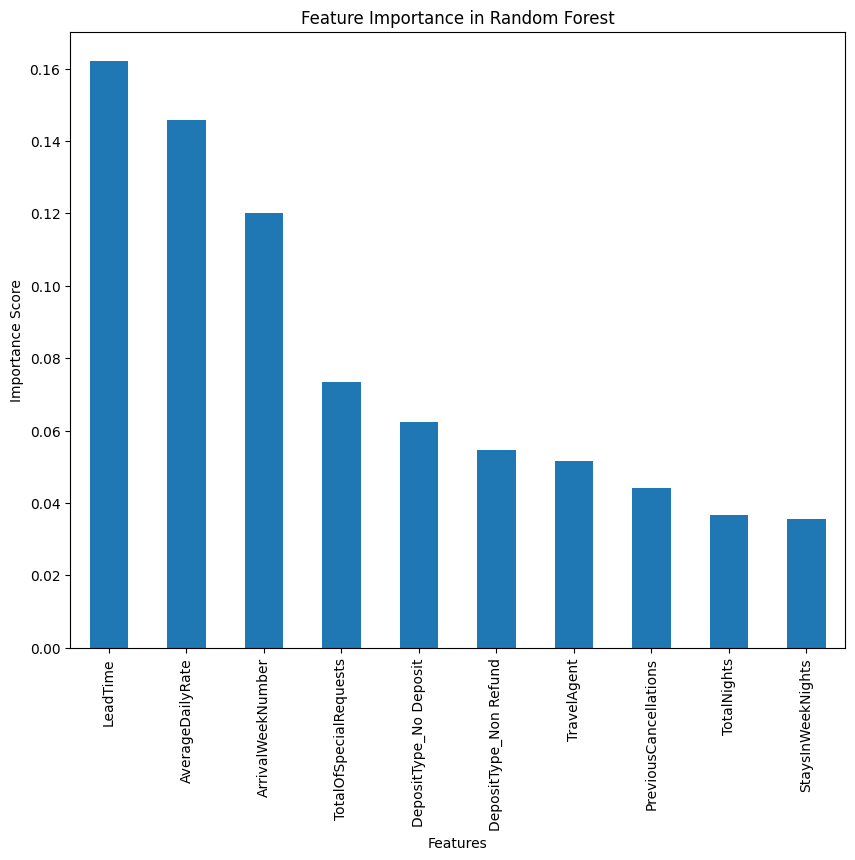

In [25]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
features_10 = features[0:10]
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(10, 8))
features_10.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [26]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.5644202211491972
AUC Score: 0.7679003882966042
Accuracy: 0.8096518607442977
Precision: 0.805526590198123
Recall: 0.6196524064171123
F1 Score: 0.7004684902523802


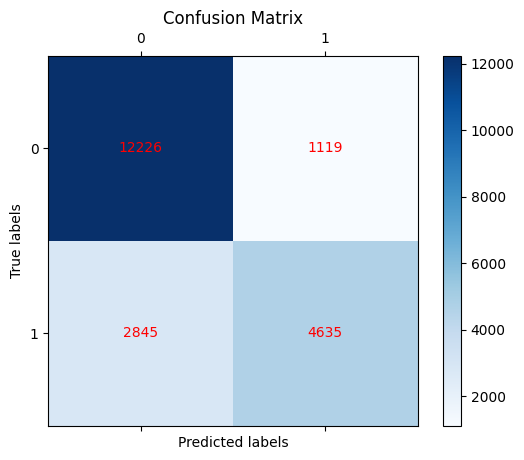

In [27]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

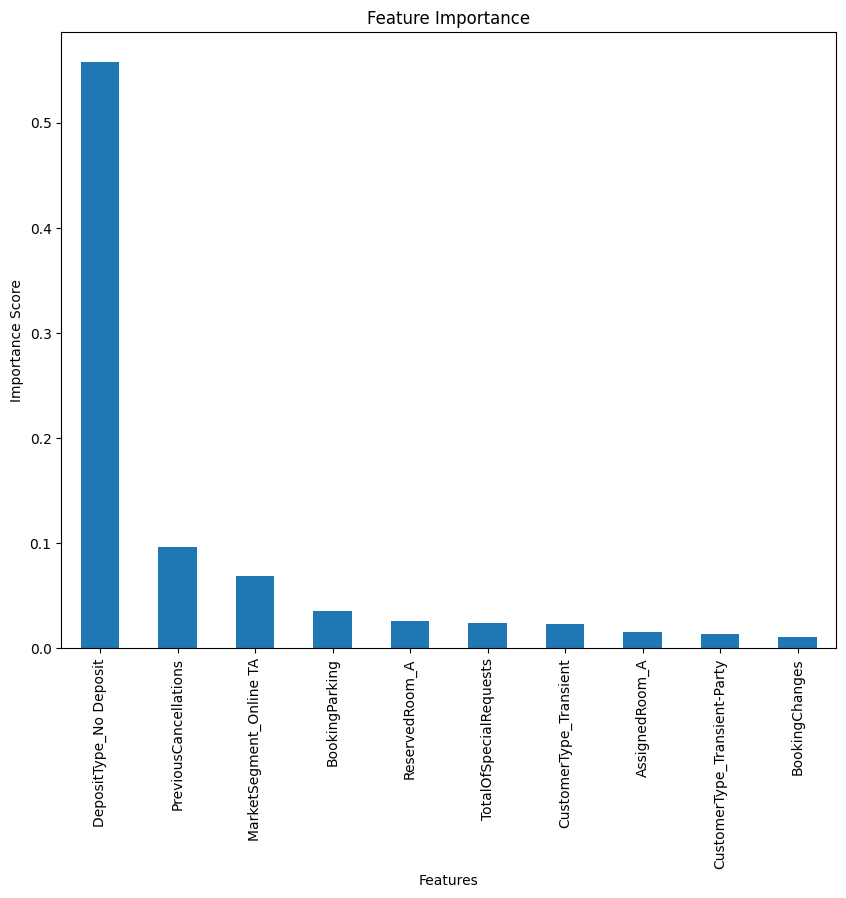

In [28]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
features_10 = features[0:10]
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(10, 8))
features_10.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Early Cancellation and Late Cancellation

In [ ]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/Work/Job/Full Time/Taiwan/Interview/友達/project/GHR_Cancellation_Analysis/Data/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [30]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 3:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 3:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)

In [31]:
#filter out no cancellation data
Cancel_Data = Data[Data["CancelType"]!=0].reset_index(drop=True)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          HB   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          BB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
34719               0             NaN                      TA/TO          SC   
34720               0             NaN                      TA/TO          BB   
34721               0             NaN                      TA/TO          BB   
34722               0             NaN                      TA/TO          BB   
34723               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousCancellations  RepeatedGuest  \
0                 0.0     ITA  ...                     0              0   
1                 0.0     CHE  ...                     0              0   
2                 0.0     PRT  ...                     0              0   
3                 0.0     PRT  ...                     0              0   
4                 0.0     PRT  ...                     0              0   
...               ...     ...  ...                   ...            ...   
34719             0.0     CHN  ...                     0              0   
34720             0.0     PRT  ...                     0              0   
34721             0.0     DEU  ...                     0              0   
34722             0.0     FRA  ...                     0              0   
34723             0.0     PRT  ...                     1              0   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
0                2015-07-09             A                    2   
1                2017-05-02             D                    1   
2                2017-01-24             A                    0   
3                2017-04-12             A                    0   
4                2016-01-21             A                    0   
...                     ...           ...                  ...   
34719            2017-07-17             A                    1   
34720            2017-01-16             A                    1   
34721            2017-05-02             D                    1   
34722            2017-09-28             D                    1   
34723            2017-07-23             A                    2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719                  2                   

In [32]:
#drop BookingCompany and other record contain null value
Cancel_Data.drop('BookingCompany', axis=1, inplace=True)
Cancel_Data = Cancel_Data.dropna()
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   
34723               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         ITA  Transient-Party  ...                      0             0   
1         CHE        Transient  ...                      0             0   
2         PRT        Transient  ...                      0             0   
3         PRT        Transient  ...                      0             0   
4         PRT  Transient-Party  ...                      0             0   
...       ...              ...  ...                    ...           ...   
34719     CHN        Transient  ...                      0             0   
34720     PRT        Transient  ...                      0             0   
34721     DEU        Transient  ...                      0             0   
34722     FRA        Transient  ...                      0             0   
34723     PRT  Transient-Party  ...                      1             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2015-07-09            A                     2   
1                 2017-05-02            D                     1   
2                 2017-01-24            A                     0   
3                 2017-04-12            A                     0   
4                 2016-01-21            A                     0   
...                      ...          ...                   ...   
34719             2017-07-17            A                     1   
34720             2017-01-16            A                     1   
34721             2017-05-02            D                     1   
34722             2017-09-28            D                     1   
34723             2017-07-23            A                     2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719              

In [33]:
Cancel_Data.isnull().sum()

ArrivalDate                    0
ArrivalWeekNumber              0
AssignedRoom                   0
AverageDailyRate               0
BookingChanges                 0
BookingDistributionChannel     0
BookingMeal                    0
BookingParking                 0
Country                        0
CustomerType                   0
DaysInWaitingList              0
DepositType                    0
LeadTime                       0
MarketSegment                  0
NumberOfAdult                  0
NumberOfBabies                 0
NumberOfChildren               0
PreviousBookingsNotCanceled    0
PreviousCancellations          0
RepeatedGuest                  0
ReservationStatusDate          0
ReservedRoom                   0
StaysInWeekendNights           0
StaysInWeekNights              0
TotalOfSpecialRequests         0
TravelAgent                    0
days_difference                0
CancelType                     0
dtype: int64

## Preprocessing

In [34]:
Cancel_Data = Cancel_Data[Cancel_Data['AverageDailyRate'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['LeadTime'] <= 300]
Cancel_Data = Cancel_Data[Cancel_Data['NumberOfAdult'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['DaysInWaitingList'] <= 14]
Cancel_Data  = Cancel_Data[Cancel_Data['StaysInWeekNights'] + Cancel_Data['StaysInWeekendNights'] > 0]

In [35]:
Cancel_Data['ArrivalDate'] = pd.to_datetime(Cancel_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Cancel_Data['AssignedRoom'] = Cancel_Data['AssignedRoom'].str.replace(' ','')
Cancel_Data['ReservedRoom'] = Cancel_Data['ReservedRoom'].str.replace(' ','')

In [36]:
# Family
Cancel_Data['Is_family'] = (Cancel_Data['NumberOfChildren'] > 0) | (Cancel_Data['NumberOfBabies'] > 0)
Cancel_Data['Is_family'] = Cancel_Data['Is_family'].astype(int)

In [37]:
# Weekend & total of night
Cancel_Data['Is_weekend'] = (Cancel_Data['StaysInWeekendNights'] > 0).astype(int)
Cancel_Data['TotalNights'] = Cancel_Data['StaysInWeekendNights'] + Cancel_Data['StaysInWeekNights']

In [38]:
Cancel_Data.drop('ArrivalDate', axis=1, inplace=True)
Cancel_Data.drop('ReservationStatusDate', axis=1, inplace=True)
Cancel_Data.drop('days_difference', axis=1, inplace=True)
Cancel_Data.drop('Country', axis=1, inplace=True)

In [39]:
Cancel_Data= pd.get_dummies(Cancel_Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','CustomerType','DepositType','MarketSegment'])
Cancel_Data

ArrivalWeekNumber  AverageDailyRate  BookingChanges  BookingParking  \
0                     35             94.51               0             0.0   
1                     33            124.99               0             0.0   
2                     24            130.17               0             0.0   
3                     21            120.90               0             0.0   
7                     42             89.62               0             0.0   
...                  ...               ...             ...             ...   
34718                 35            114.00               0             0.0   
34719                 38            108.55               0             0.0   
34720                 38            100.65               0             0.0   
34721                 36            196.94               0             0.0   
34722                 45             96.94               0             0.0   

       DaysInWaitingList  LeadTime  NumberOfAdult  NumberOfBabies  \
0                      0       117              2               0   
1                      0       265              2               0   
2                      0       151              2               0   
3                      0        86              2               0   
7                      0       279              2               0   
...                  ...       ...            ...             ...   
34718                  0       156              2               0   
34719                  0        15              2               0   
34720                  0        15              2               0   
34721                  0        10              1               0   
34722                  0        62              2               0   

       NumberOfChildren  PreviousBookingsNotCanceled  ...  \
0                   0.0                            0  ...   
1                   0.0                            0  ...   
2                   0.0                            0  ...   
3                   0.0                            0  ...   
7                   0.0                            0  ...   
...                 ...                          ...  ...   
34718               0.0                            0  ...   
34719               0.0                            0  ...   
34720               0.0                            0  ...   
34721               0.0                            0  ...   
34722               0.0                            0  ...   

       DepositType_No Deposit  DepositType_Non Refund  DepositType_Refundable  \
0                        True                   False                   False   
1                        True                   False                   False   
2                       False                    True                   False   
3                        True                   False                   False   
7                       False                    True                   False   
...                       ...                     ...                     ...   
34718                    True                   False                   False   
34719                    True                   False                   False   
34720                    True                   False                   False   
34721                    True                   False                   False   
34722                    True                   False                   False   

       MarketSegment_Aviation  MarketSegment_Complementary  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
7                       False                        False   
...                       ...                          ...   
34718                   False                        False   
34719                   False          

#### Issue
How to deal with Date Data

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [40]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Logistic Regression

In [41]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42, solver='liblinear')

Cohen's Kappa Score: 0.0
AUC Score: 0.5
Accuracy: 0.9699046083568453
Precision: 0.9699046083568453
Recall: 1.0
F1 Score: 0.9847224116764425


/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


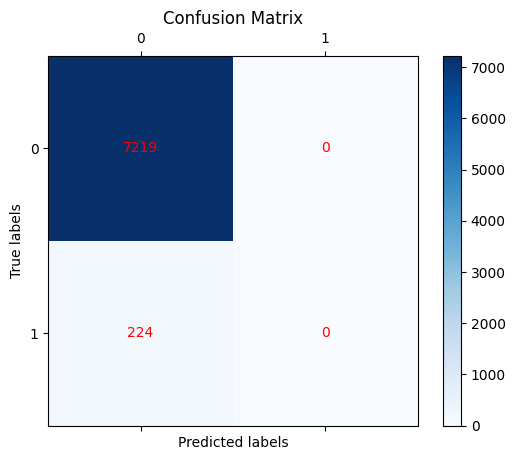

In [42]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')    
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                                      Coefficient
NumberOfChildren                         0.188176
MarketSegment_Direct                     0.125362
TotalOfSpecialRequests                   0.094318
MarketSegment_Corporate                  0.093077
DepositType_No Deposit                   0.087318
AssignedRoom_B                           0.083830
CustomerType_Transient-Party             0.073623
BookingDistributionChannel_GDS           0.065934
ReservedRoom_F                           0.064806
MarketSegment_Offline TA/TO              0.060938
BookingDistributionChannel_TA/TO         0.056189
RepeatedGuest                            0.053594
BookingMeal_SC                           0.044146
NumberOfBabies                           0.041433
DepositType_Refundable                   0.039151
ReservedRoom_D                           0.037584
NumberOfAdult                            0.033858
ReservedRoom_G                           0.025892
MarketSegment_Groups                     0.024373


<Figure size 10000x4000 with 0 Axes>

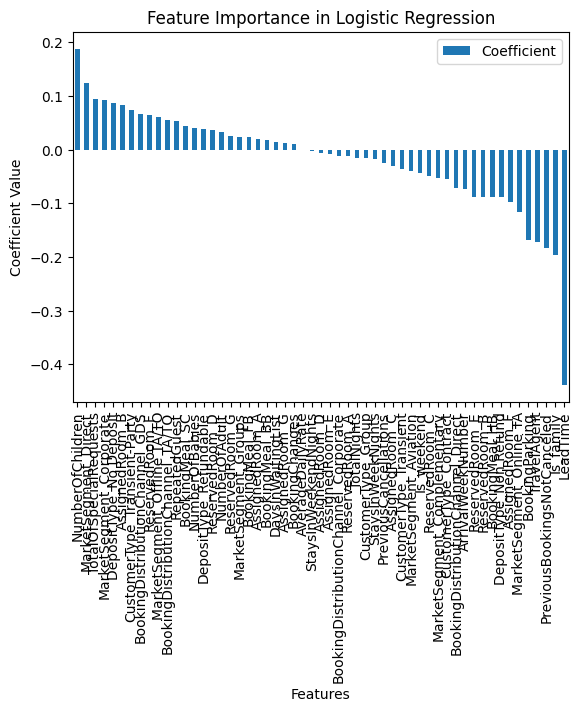

In [43]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(100, 40))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Cohen's Kappa Score: 0.0
AUC Score: 0.5
Accuracy: 0.9699046083568453
Precision: 0.9699046083568453
Recall: 1.0
F1 Score: 0.9847224116764425


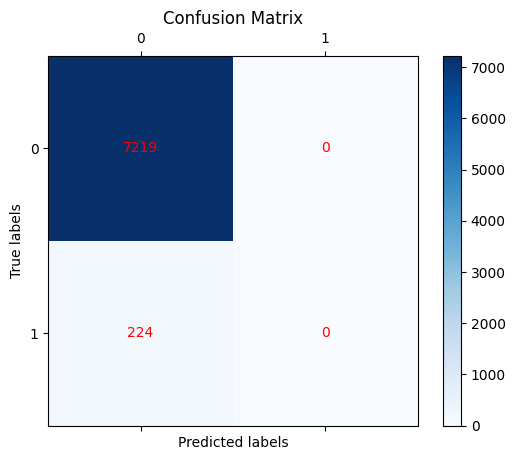

In [45]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [46]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[2.90147343e-06 5.37655881e-06 6.92081623e-06 4.66671783e-06
 2.12013204e-06 5.99981363e-06 5.13741482e-06 1.39856255e-05
 3.74235290e-05 4.56099402e-05 1.22621349e-06 9.24150947e-06
 1.25367513e-05 9.49840215e-06 1.12677688e-05 2.49346246e-06
 4.43036007e-05 2.01212766e-05 1.64664233e-06 1.60871000e-06
 1.59794954e-05 4.40390496e-06 6.78352753e-06 3.91358677e-06
 3.15708215e-06 2.76101282e-07 2.89631772e-06 5.17896227e-06
 1.17683641e-14 2.63039709e-06 1.46348327e-05 7.99985952e-06
 2.02870850e-06 4.31662519e-06 5.94319024e-06 1.44144303e-06
 7.27220951e-06 6.19389266e-06 1.67637863e-06 9.31925421e-06
 5.19768771e-08 6.18852425e-06 3.52350423e-06 6.58308955e-06
 3.28403082e-06 6.95039257e-06 7.06928637e-06 2.93796711e-06
 1.08836551e-14 4.68271255e-14 8.61191529e-06 1.18447065e-05
 9.13841645e-06 1.09066804e-05 1.89297094e-05]


### Random Forest

In [47]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Cohen's Kappa Score: 0.025286512837332298
AUC Score: 0.5066271669008371
Accuracy: 0.9701733172108021
Precision: 0.9702917058744455
Recall: 0.999861476658817
F1 Score: 0.9848546868604175


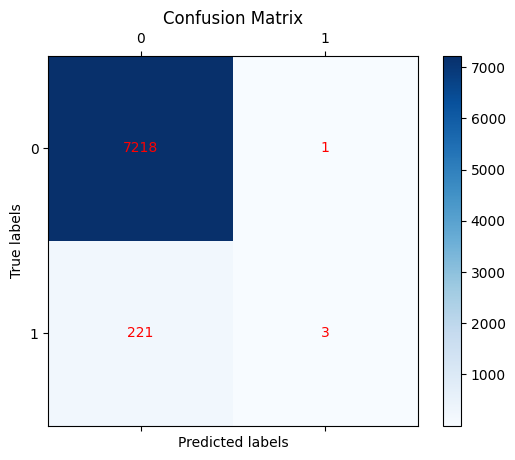

In [48]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

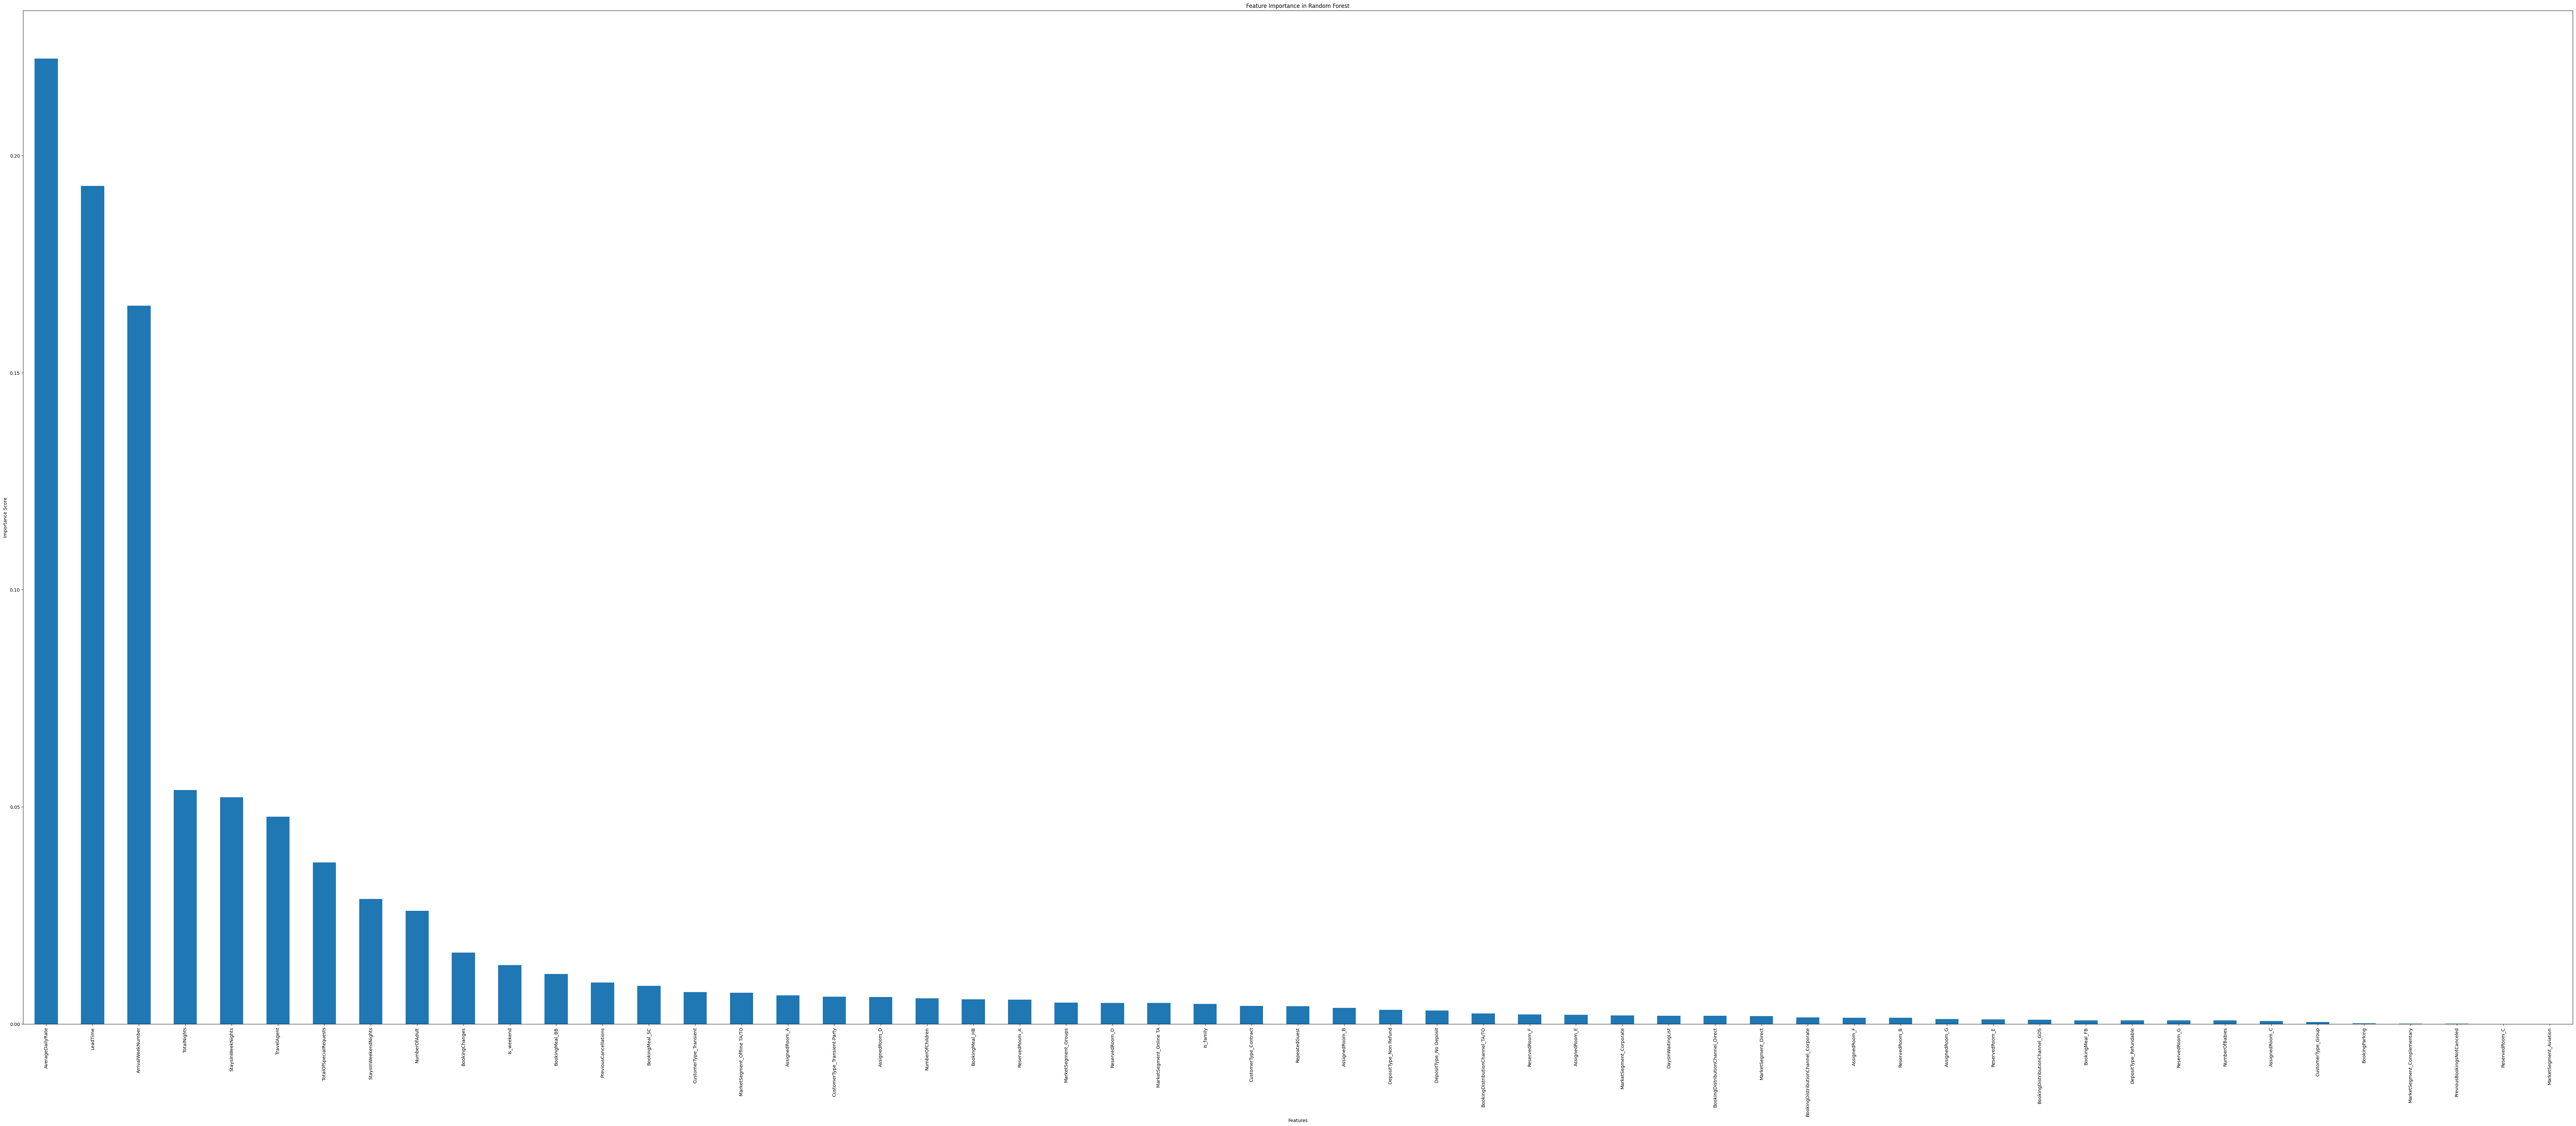

In [49]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [50]:
y_train = y_train.reset_index(drop=True)
for i in range(len(y_train)):
    y_train[i] = y_train[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [51]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.024919413443840965
AUC Score: 0.5065579052302456
Accuracy: 0.9700389627838237
Precision: 0.6
Recall: 0.013392857142857142
F1 Score: 0.026200873362445413


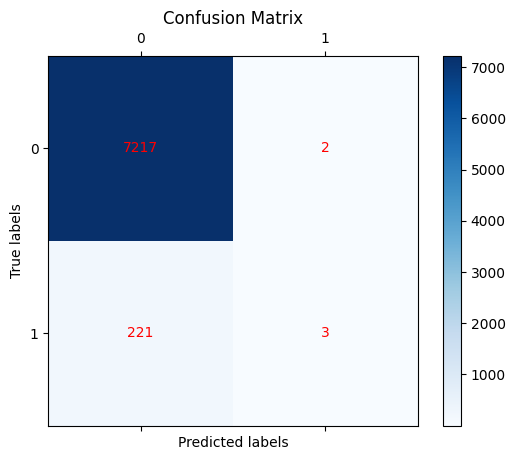

In [52]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

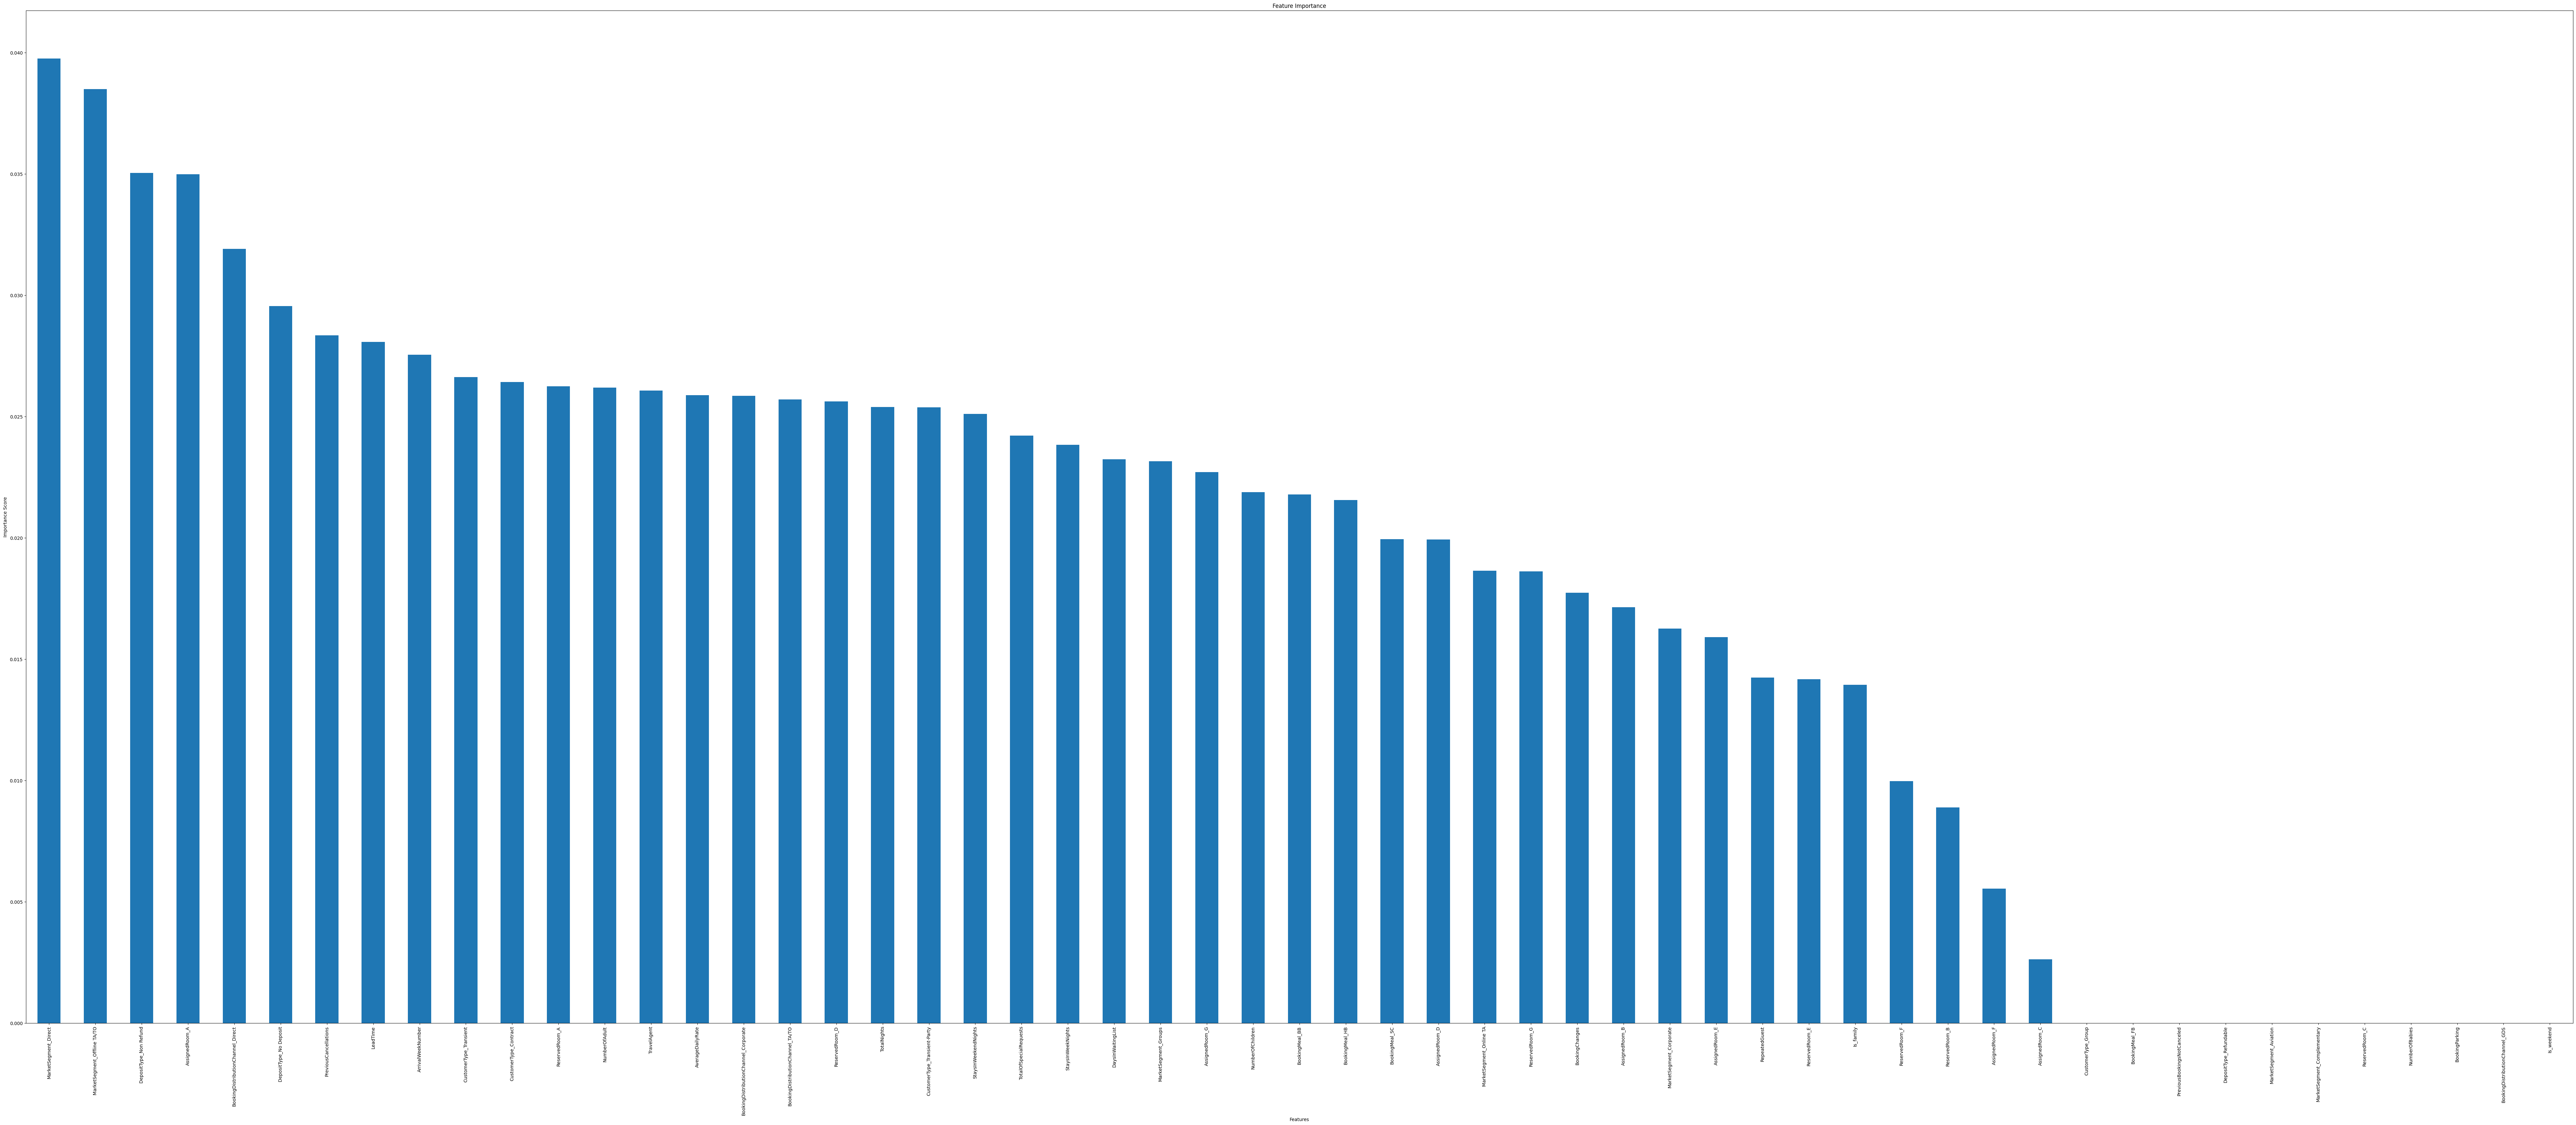

In [53]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Data Imbalanced

## Data Processing

In [54]:
from imblearn.over_sampling import SMOTE

In [ ]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/Work/Job/Full Time/Taiwan/Interview/友達/project/GHR_Cancellation_Analysis/Data/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [56]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 3:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 3:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)

#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)


In [57]:
#filter out no cancellation data
Cancel_Data = Data[Data["CancelType"]!=0].reset_index(drop=True)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          HB   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          BB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
34719               0             NaN                      TA/TO          SC   
34720               0             NaN                      TA/TO          BB   
34721               0             NaN                      TA/TO          BB   
34722               0             NaN                      TA/TO          BB   
34723               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousCancellations  RepeatedGuest  \
0                 0.0     ITA  ...                     0              0   
1                 0.0     CHE  ...                     0              0   
2                 0.0     PRT  ...                     0              0   
3                 0.0     PRT  ...                     0              0   
4                 0.0     PRT  ...                     0              0   
...               ...     ...  ...                   ...            ...   
34719             0.0     CHN  ...                     0              0   
34720             0.0     PRT  ...                     0              0   
34721             0.0     DEU  ...                     0              0   
34722             0.0     FRA  ...                     0              0   
34723             0.0     PRT  ...                     1              0   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
0                2015-07-09             A                    2   
1                2017-05-02             D                    1   
2                2017-01-24             A                    0   
3                2017-04-12             A                    0   
4                2016-01-21             A                    0   
...                     ...           ...                  ...   
34719            2017-07-17             A                    1   
34720            2017-01-16             A                    1   
34721            2017-05-02             D                    1   
34722            2017-09-28             D                    1   
34723            2017-07-23             A                    2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719                  2                   

In [58]:
#drop BookingCompany
Cancel_Data.drop('BookingCompany', axis=1, inplace=True)
Cancel_Data = Cancel_Data.dropna()
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   
34723               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         ITA  Transient-Party  ...                      0             0   
1         CHE        Transient  ...                      0             0   
2         PRT        Transient  ...                      0             0   
3         PRT        Transient  ...                      0             0   
4         PRT  Transient-Party  ...                      0             0   
...       ...              ...  ...                    ...           ...   
34719     CHN        Transient  ...                      0             0   
34720     PRT        Transient  ...                      0             0   
34721     DEU        Transient  ...                      0             0   
34722     FRA        Transient  ...                      0             0   
34723     PRT  Transient-Party  ...                      1             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2015-07-09            A                     2   
1                 2017-05-02            D                     1   
2                 2017-01-24            A                     0   
3                 2017-04-12            A                     0   
4                 2016-01-21            A                     0   
...                      ...          ...                   ...   
34719             2017-07-17            A                     1   
34720             2017-01-16            A                     1   
34721             2017-05-02            D                     1   
34722             2017-09-28            D                     1   
34723             2017-07-23            A                     2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719              

In [59]:
Cancel_Data = Cancel_Data[Cancel_Data['AverageDailyRate'] > 0]
Cancel_Data = Cancel_Data[Cancel_Data['LeadTime'] <= 300]
Cancel_Data = Cancel_Data[Cancel_Data['NumberOfAdult'] > 0]
Cancel_Data = Cancel_Data[Cancel_Data['DaysInWaitingList'] <= 14]
Cancel_Data = Cancel_Data[Cancel_Data['StaysInWeekNights'] + Cancel_Data['StaysInWeekendNights'] > 0]

In [60]:
Cancel_Data['ArrivalDate'] = pd.to_datetime(Cancel_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Cancel_Data['AssignedRoom'] = Cancel_Data['AssignedRoom'].str.replace(' ','')
Cancel_Data['ReservedRoom'] = Cancel_Data['ReservedRoom'].str.replace(' ','')

In [61]:
# Family
Cancel_Data['Is_family'] = (Cancel_Data['NumberOfChildren'] > 0) | (Cancel_Data['NumberOfBabies'] > 0)
Cancel_Data['Is_family'] = Cancel_Data['Is_family'].astype(int)

In [62]:
# Weekend & total of night
Cancel_Data['Is_weekend'] = (Cancel_Data['StaysInWeekendNights'] > 0).astype(int)
Cancel_Data['TotalNights'] = Cancel_Data['StaysInWeekendNights'] + Cancel_Data['StaysInWeekNights']

In [63]:
#Add new Column Is_Country_PRT(1 means yes)
Cancel_Data['Is_Country_PRT'] = (Cancel_Data['Country'] == 'PRT').astype(int)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
7      2015-10-16                 42            A             89.62   
...           ...                ...          ...               ...   
34718  2017-09-02                 35            D            114.00   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
7                   0                      TA/TO          HB             0.0   
...               ...                        ...         ...             ...   
34718               0                      TA/TO          BB             0.0   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  StaysInWeekendNights StaysInWeekNights  \
0         ITA  Transient-Party  ...                     2                 1   
1         CHE        Transient  ...                     1                 3   
2         PRT        Transient  ...                     0                 2   
3         PRT        Transient  ...                     0                 1   
7         PRT        Transient  ...                     0                 2   
...       ...              ...  ...                   ...               ...   
34718     ESP        Transient  ...                     2                 2   
34719     CHN        Transient  ...                     1                 2   
34720     PRT        Transient  ...                     1                 3   
34721     DEU        Transient  ...                     1                 4   
34722     FRA        Transient  ...                     1                 2   

       TotalOfSpecialRequests TravelAgent  days_difference  CancelType  \
0                           0        17.0               47           1   
1                           1         9.0              105           1   
2                           0       154.0              139           1   
3                           1         9.0               42           1   
7                           0         1.0               98           1   
...                       ...         ...              ...         ...   
34718                       0         9.0               86           1   
34719                       0         9.0               68           1   
34720                       0        37.0              249           1   
34721                       0         9.0              127           1   
34722                       2         9.0               43           1   

       Is_family  Is_weekend  TotalNights  Is_Country_PRT  
0              0           1            3               0  
1              0           1            4               0  
2              0           0            2               1  
3              0           0            1               1  
7              0           0            2             

In [64]:
Cancel_Data.drop('ArrivalDate', axis=1, inplace=True)
Cancel_Data.drop('ReservationStatusDate', axis=1, inplace=True)
Cancel_Data.drop('days_difference', axis=1, inplace=True)
Cancel_Data.drop('Country', axis=1, inplace=True)

In [65]:
#One Hot Enocde Categorical data
Cancel_Data= pd.get_dummies(Cancel_Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','CustomerType','DepositType','MarketSegment'])
Cancel_Data

ArrivalWeekNumber  AverageDailyRate  BookingChanges  BookingParking  \
0                     35             94.51               0             0.0   
1                     33            124.99               0             0.0   
2                     24            130.17               0             0.0   
3                     21            120.90               0             0.0   
7                     42             89.62               0             0.0   
...                  ...               ...             ...             ...   
34718                 35            114.00               0             0.0   
34719                 38            108.55               0             0.0   
34720                 38            100.65               0             0.0   
34721                 36            196.94               0             0.0   
34722                 45             96.94               0             0.0   

       DaysInWaitingList  LeadTime  NumberOfAdult  NumberOfBabies  \
0                      0       117              2               0   
1                      0       265              2               0   
2                      0       151              2               0   
3                      0        86              2               0   
7                      0       279              2               0   
...                  ...       ...            ...             ...   
34718                  0       156              2               0   
34719                  0        15              2               0   
34720                  0        15              2               0   
34721                  0        10              1               0   
34722                  0        62              2               0   

       NumberOfChildren  PreviousBookingsNotCanceled  ...  \
0                   0.0                            0  ...   
1                   0.0                            0  ...   
2                   0.0                            0  ...   
3                   0.0                            0  ...   
7                   0.0                            0  ...   
...                 ...                          ...  ...   
34718               0.0                            0  ...   
34719               0.0                            0  ...   
34720               0.0                            0  ...   
34721               0.0                            0  ...   
34722               0.0                            0  ...   

       DepositType_No Deposit  DepositType_Non Refund  DepositType_Refundable  \
0                        True                   False                   False   
1                        True                   False                   False   
2                       False                    True                   False   
3                        True                   False                   False   
7                       False                    True                   False   
...                       ...                     ...                     ...   
34718                    True                   False                   False   
34719                    True                   False                   False   
34720                    True                   False                   False   
34721                    True                   False                   False   
34722                    True                   False                   False   

       MarketSegment_Aviation  MarketSegment_Complementary  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
7                       False                        False   
...                       ...                          ...   
34718                   False                        False   
34719                   False          

## Oversampling     

In [66]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

In [67]:
# Apply SMOTE for oversampling the minority class in the training set
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

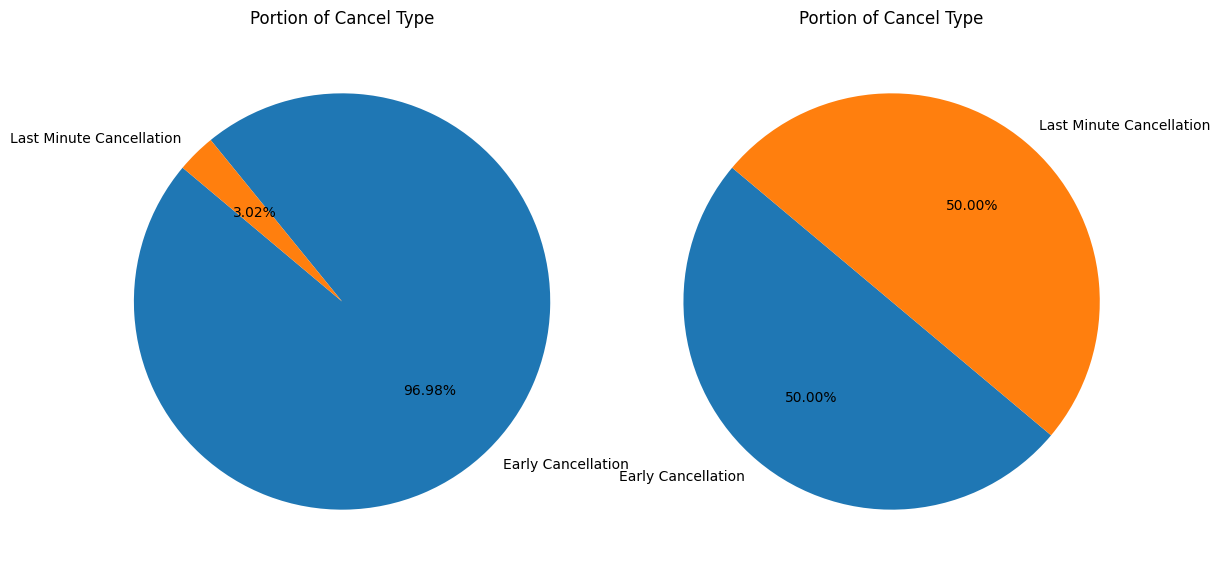

In [68]:
Counts_CancelType = y_train.value_counts()
Counts_CancelType_only_cancel = y_train_oversampled.value_counts()

# Plotting the pie chart of the portion of cancellation type
fig, axs = plt.subplots(1, 2, figsize=(13, 7))  # 2 rows, 2 columns
label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[0].pie(Counts_CancelType, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[0].axis('equal') 
axs[0].set_title('Portion of Cancel Type')

label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[1].pie(Counts_CancelType_only_cancel, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[1].axis('equal') 
axs[1].set_title('Portion of Cancel Type')

plt.show()

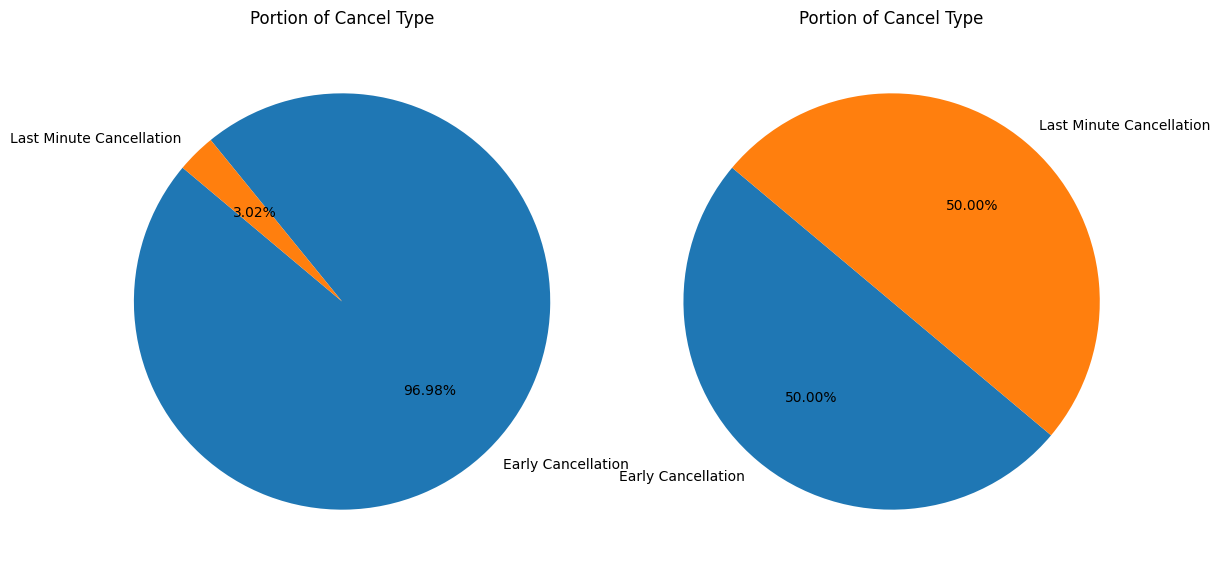

In [69]:
Counts_CancelType = y_train.value_counts()
Counts_CancelType_only_cancel = y_train_oversampled.value_counts()

# Plotting the pie chart of the portion of cancellation type
fig, axs = plt.subplots(1, 2, figsize=(13, 7))  # 2 rows, 2 columns
label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[0].pie(Counts_CancelType, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[0].axis('equal') 
axs[0].set_title('Portion of Cancel Type')

label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[1].pie(Counts_CancelType_only_cancel, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[1].axis('equal') 
axs[1].set_title('Portion of Cancel Type')

plt.show()

### Logistic Regression

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [71]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_oversampled, y_train_oversampled)


LogisticRegression(random_state=42, solver='liblinear')

Cohen's Kappa Score: -0.011470369852464746
AUC Score: 0.4963983931292423
Accuracy: 0.9629181781539702
Precision: 0.9696928697063997
Recall: 0.9927967862584846
F1 Score: 0.9811088295687885


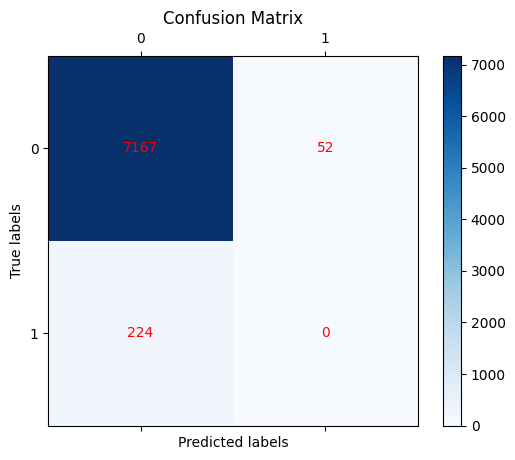

In [72]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')    
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                                      Coefficient
TotalNights                              5.650911
BookingMeal_SC                           5.345558
BookingMeal_BB                           5.198707
CustomerType_Transient-Party             4.717887
MarketSegment_Offline TA/TO              4.252247
MarketSegment_Groups                     4.199176
BookingMeal_HB                           4.086002
MarketSegment_Online TA                  4.079493
CustomerType_Transient                   4.053712
CustomerType_Contract                    4.052826
DepositType_No Deposit                   3.894536
MarketSegment_Corporate                  3.839538
DepositType_Non Refund                   3.680963
AssignedRoom_A                           3.446298
AssignedRoom_D                           3.110748
DepositType_Refundable                   3.050678
AssignedRoom_B                           2.862549
AssignedRoom_G                           2.676475
NumberOfChildren                         2.669172


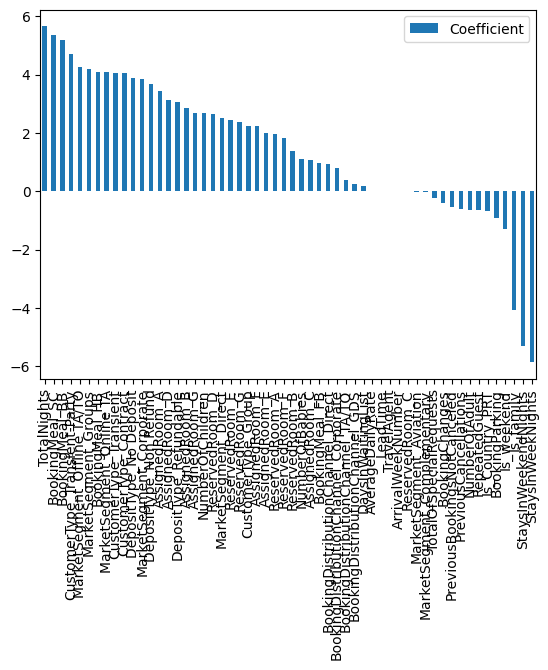

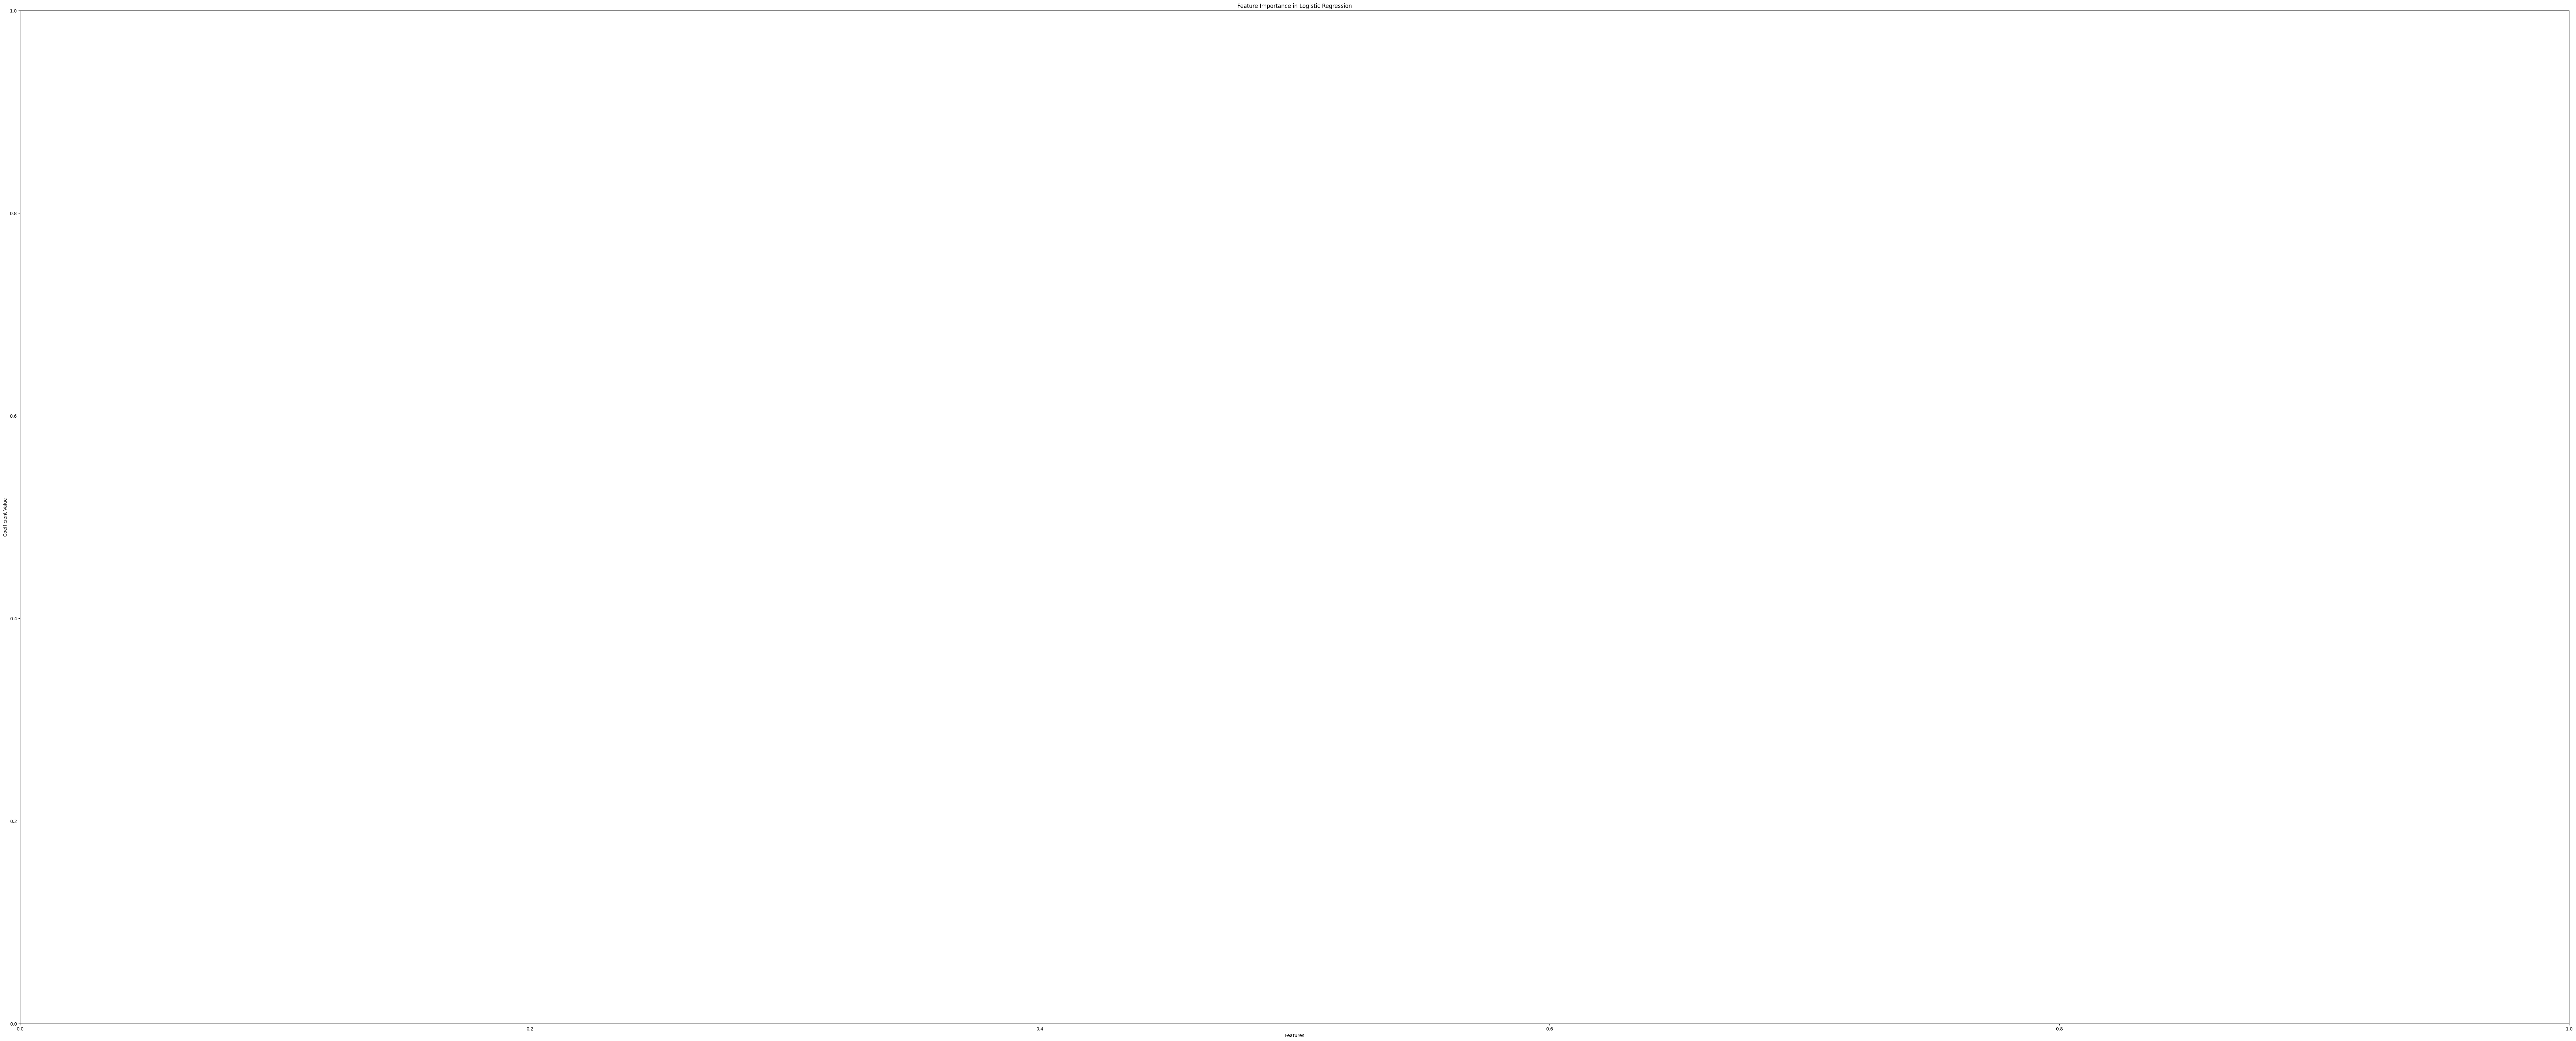

In [73]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

feature_importance.plot(kind='bar')
plt.figure(figsize=(100, 40))
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_oversampled, y_train_oversampled)

SVC(kernel='linear')

/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Cohen's Kappa Score: 0.005709282945480787
AUC Score: 0.501539526151228
Accuracy: 0.9686954185140401
Precision: 0.969994617868676
Recall: 0.99861476658817
F1 Score: 0.984096648692922


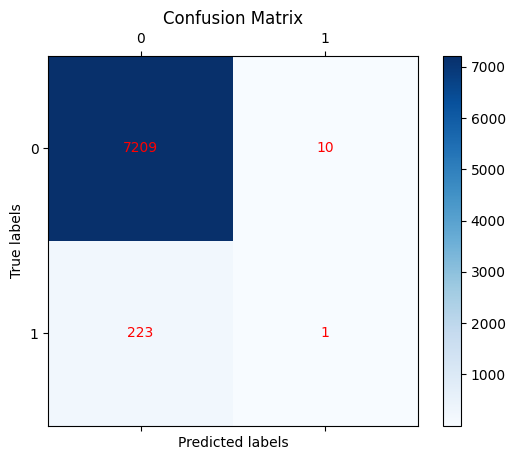

In [75]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')    
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [76]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[1.18371561e-03 3.38008582e-04 4.09821190e-02 4.89576980e-02
 2.62743719e-02 1.34510854e-03 6.59797138e-02 1.00000000e+00
 2.16870504e+00 6.52117863e-02 1.01146332e-01 1.63161209e-02
 2.57185018e+00 2.64951598e+00 3.26043245e-02 4.72115948e-04
 2.64311238e+00 1.77681576e-01 2.62813938e+00 6.52727115e-02
 2.35300359e+00 2.18114757e+00 1.48171592e+00 2.29226340e+00
 1.92156429e+00 2.02009841e+00 2.01214731e+00 1.98748133e+00
 5.16896933e-01 0.00000000e+00 2.08013116e+00 9.21564287e-01
 6.30302028e-01 9.20840080e-01 1.92295454e+00 2.00188946e+00
 1.90274016e+00 2.00499909e+00 2.75542029e+00 1.00000000e+00
 2.58991767e+00 2.76687777e+00 2.58958041e+00 1.00000000e+00
 2.65060029e+00 2.71122365e+00 2.62583939e+00 2.56603902e+00
 2.10781363e+00 0.00000000e+00 0.00000000e+00 2.58480368e+00
 2.29109018e+00 2.47799001e+00 2.50165645e+00 2.47383228e+00]


### Random Forest

In [77]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(random_state=215)

Cohen's Kappa Score: 0.04315918002740826
AUC Score: 0.5131315798587062
Accuracy: 0.9660083299744726
Precision: 0.9706756756756757
Recall: 0.9950131597174123
F1 Score: 0.9826937547027841


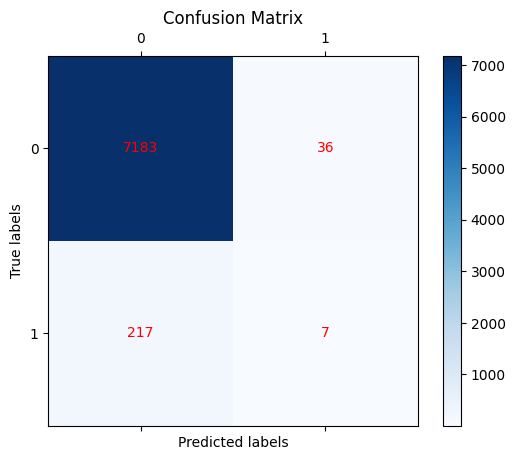

In [78]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

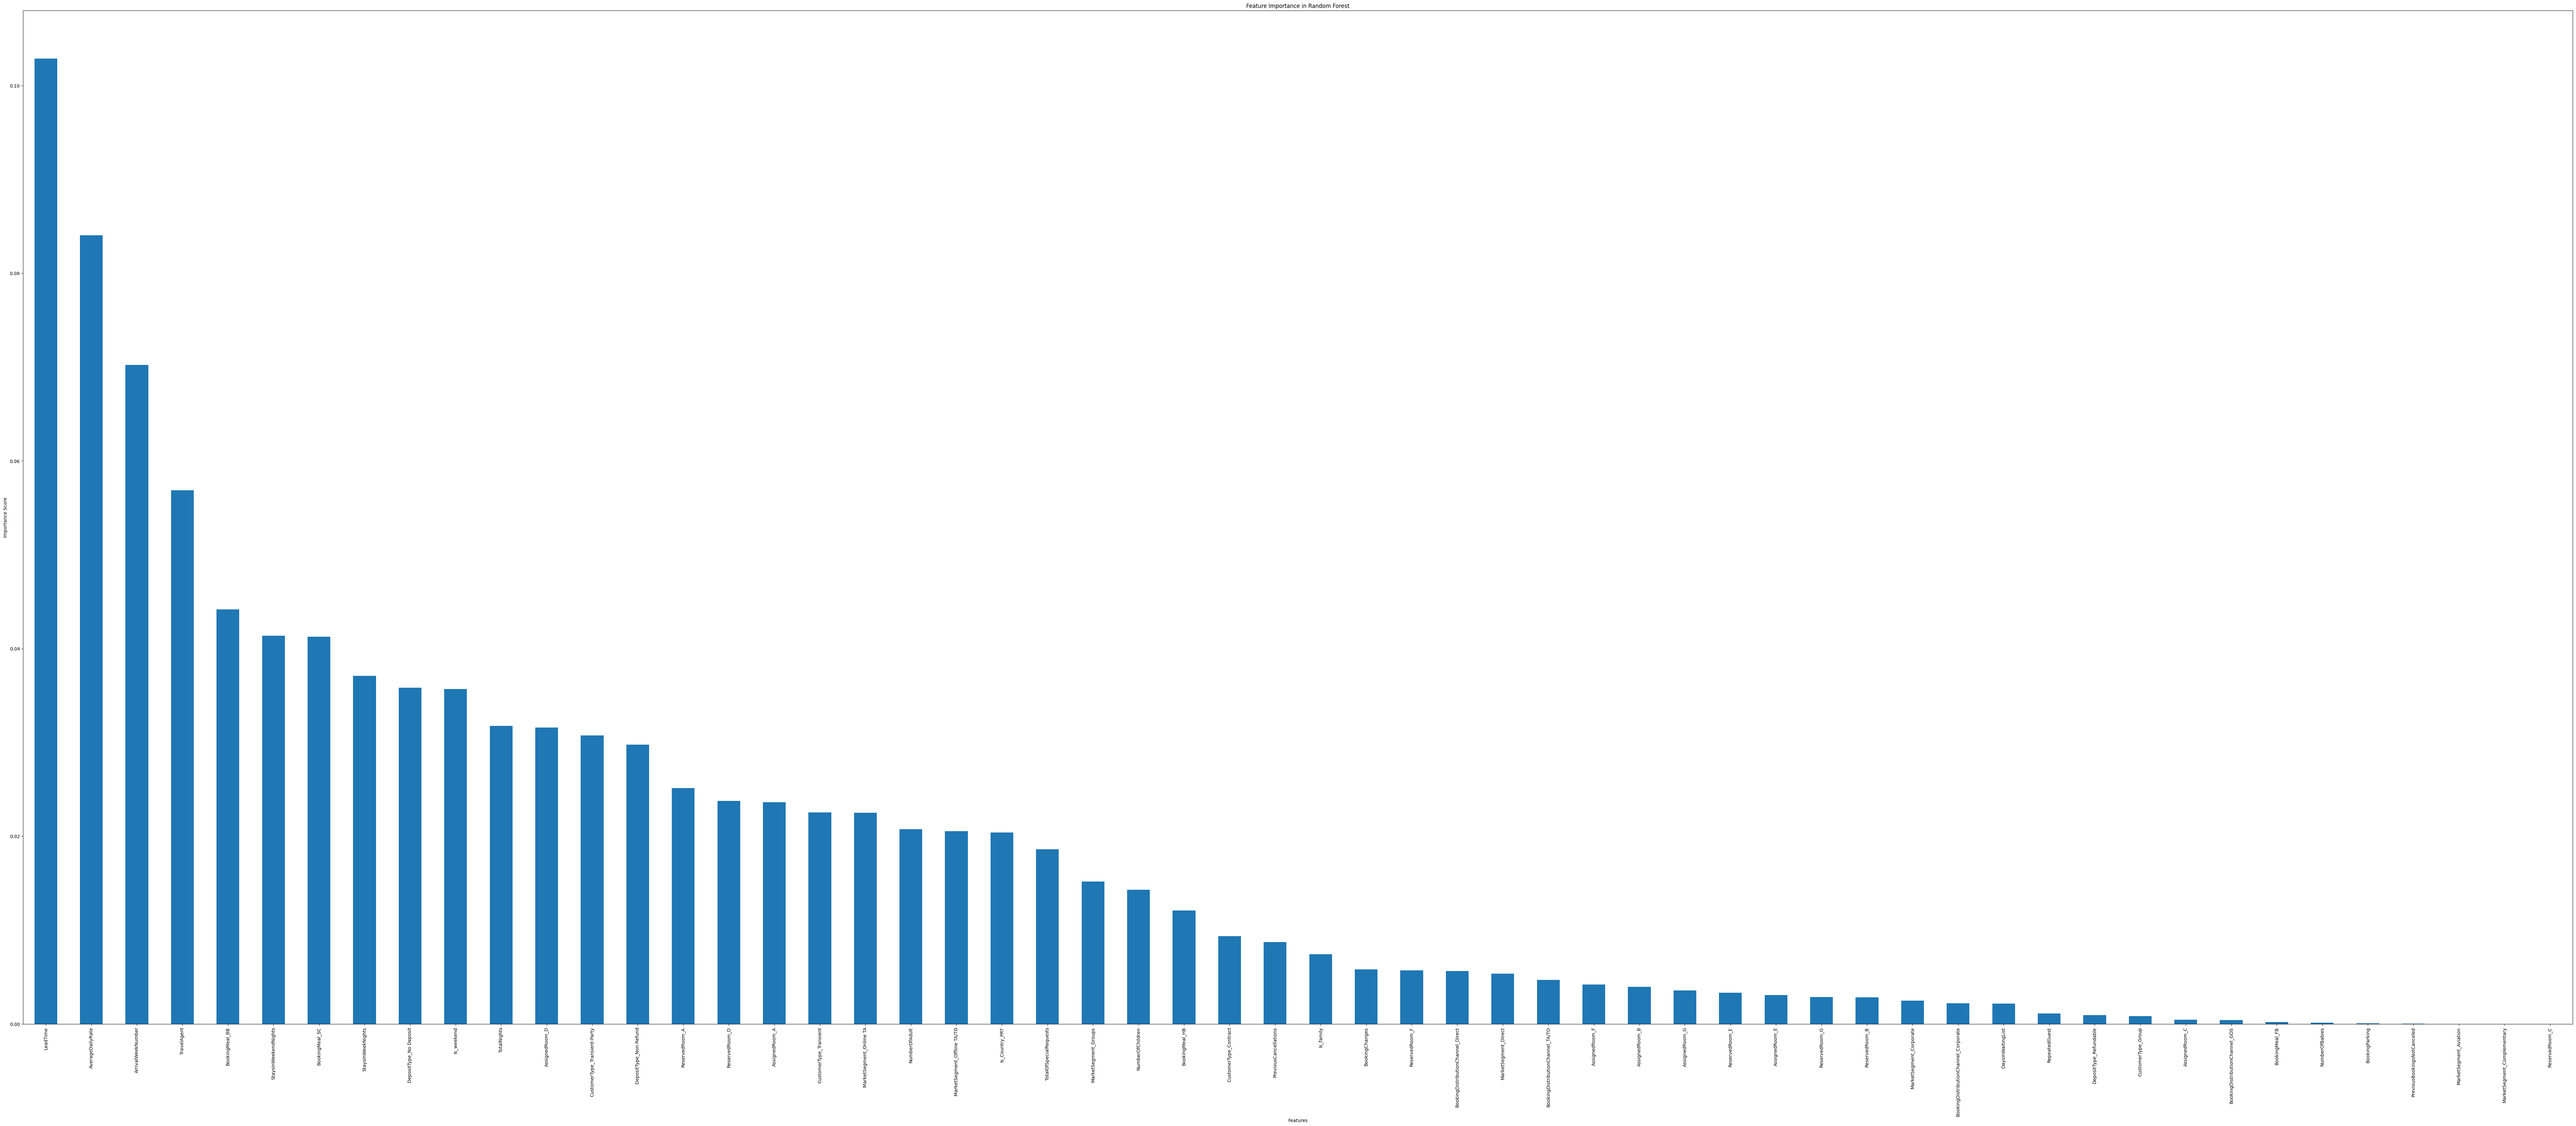

In [79]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [80]:
for i in range(len(y_train_oversampled)):
    y_train_oversampled[i] = y_train_oversampled[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [81]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train_oversampled, y_train_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.02599424115430371
AUC Score: 0.508752325213227
Accuracy: 0.9617089883111648
Precision: 0.0821917808219178
Recall: 0.026785714285714284
F1 Score: 0.04040404040404041


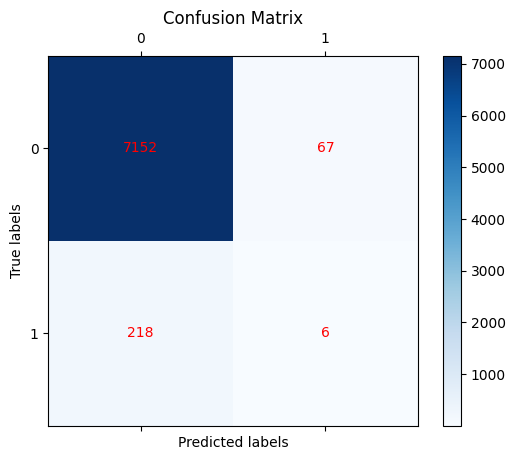

In [82]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

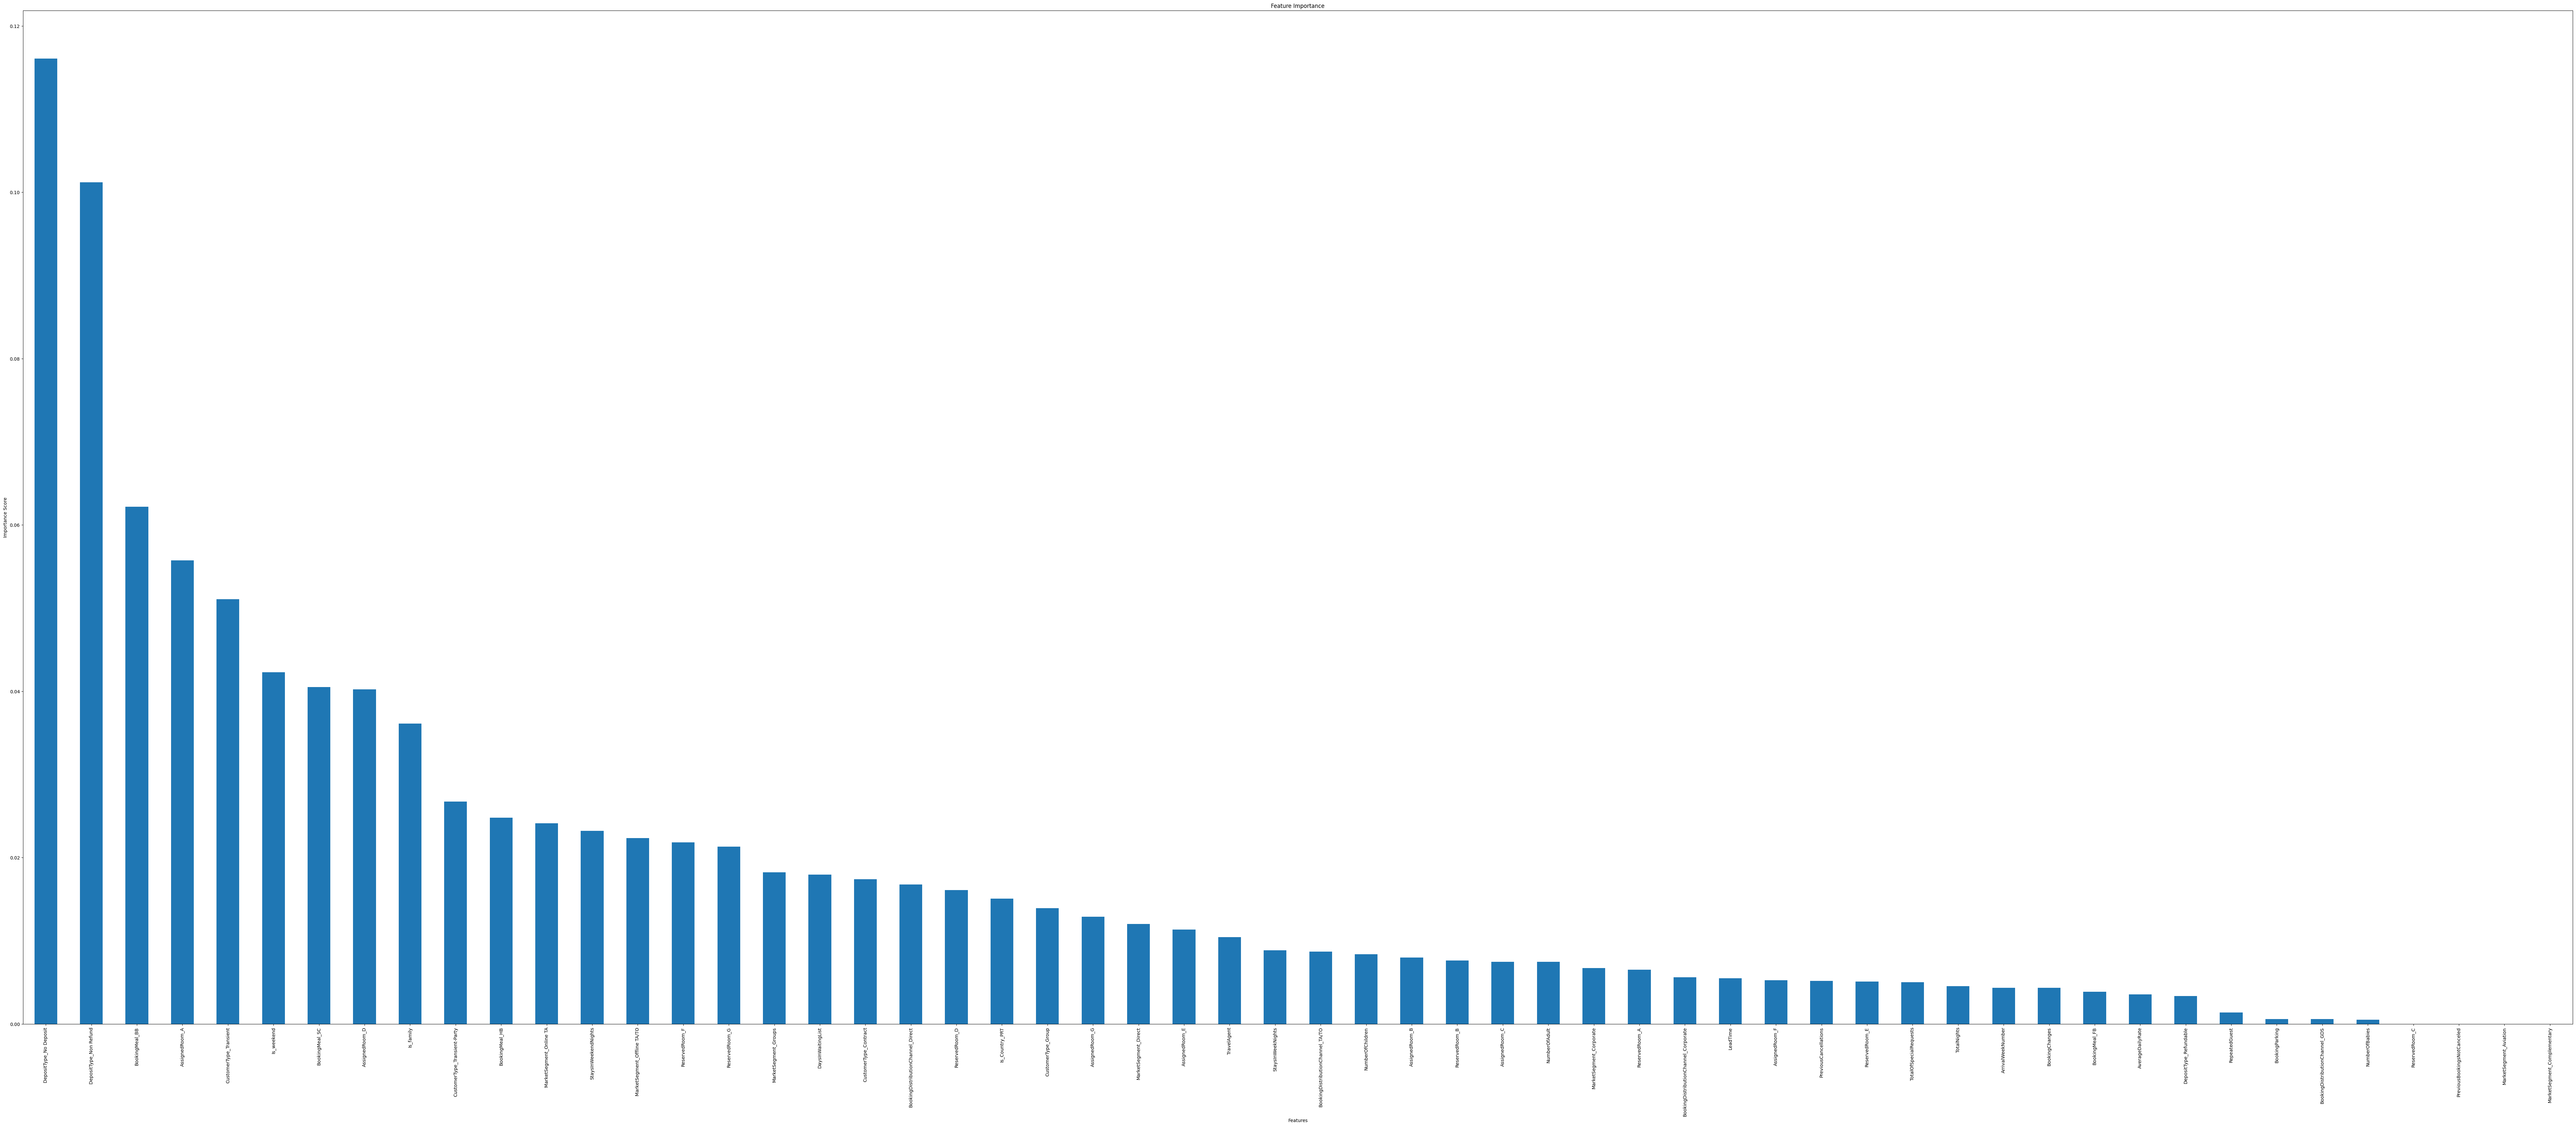

In [83]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

## Undersampling

In [84]:
from imblearn.under_sampling import RandomUnderSampler

In [85]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

In [86]:
rus = RandomUnderSampler(random_state=42)
X_train_Undersampled, y_train_Undersampled = rus.fit_resample(X_train, y_train)

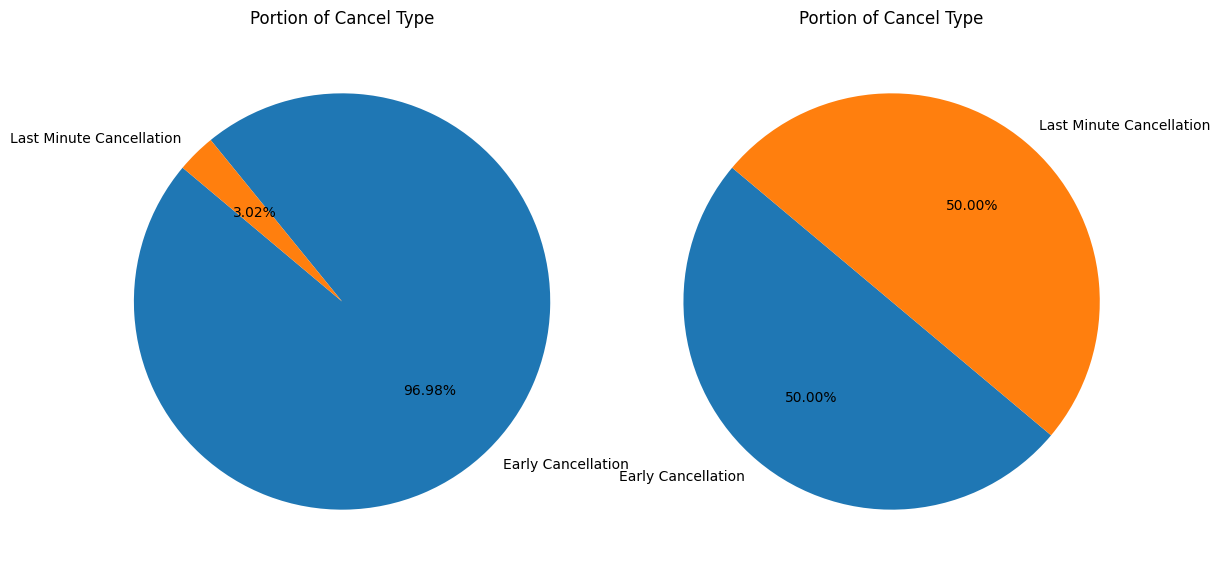

In [87]:
Counts_CancelType = y_train.value_counts()
Counts_CancelType_only_cancel = y_train_Undersampled.value_counts()

# Plotting the pie chart of the portion of cancellation type
fig, axs = plt.subplots(1, 2, figsize=(13, 7))  # 2 rows, 2 columns
label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[0].pie(Counts_CancelType, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[0].axis('equal') 
axs[0].set_title('Portion of Cancel Type')

label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[1].pie(Counts_CancelType_only_cancel, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[1].axis('equal') 
axs[1].set_title('Portion of Cancel Type')

plt.show()

### Logistic Regression

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [89]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_Undersampled, y_train_Undersampled)


LogisticRegression(random_state=42, solver='liblinear')

Cohen's Kappa Score: 0.02177278604686217
AUC Score: 0.5835963627728415
Accuracy: 0.5614671503426037
Precision: 0.9786976519002663
Recall: 0.5600498684028259
F1 Score: 0.7124229074889867


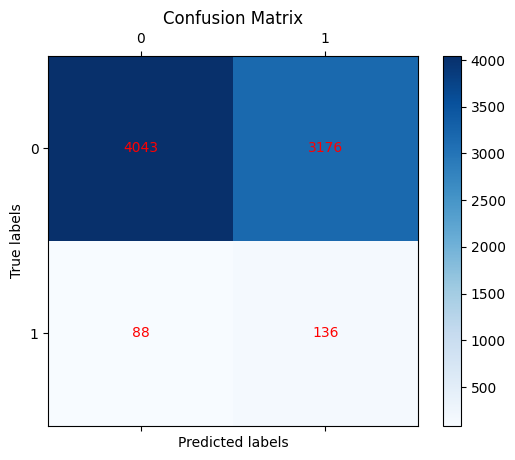

In [90]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')    
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                                      Coefficient
AssignedRoom_B                           0.719968
AssignedRoom_G                           0.606342
RepeatedGuest                            0.460922
DepositType_Refundable                   0.397393
Is_Country_PRT                           0.394762
ReservedRoom_D                           0.368318
CustomerType_Transient-Party             0.287945
DaysInWaitingList                        0.277895
BookingDistributionChannel_Corporate     0.257407
ReservedRoom_A                           0.221872
DepositType_No Deposit                   0.210896
NumberOfBabies                           0.199329
BookingMeal_FB                           0.197936
MarketSegment_Corporate                  0.191301
MarketSegment_Groups                     0.191264
BookingMeal_SC                           0.175332
ReservedRoom_F                           0.171116
ReservedRoom_G                           0.159677
NumberOfChildren                         0.155796


Text(0, 0.5, 'Coefficient Value')

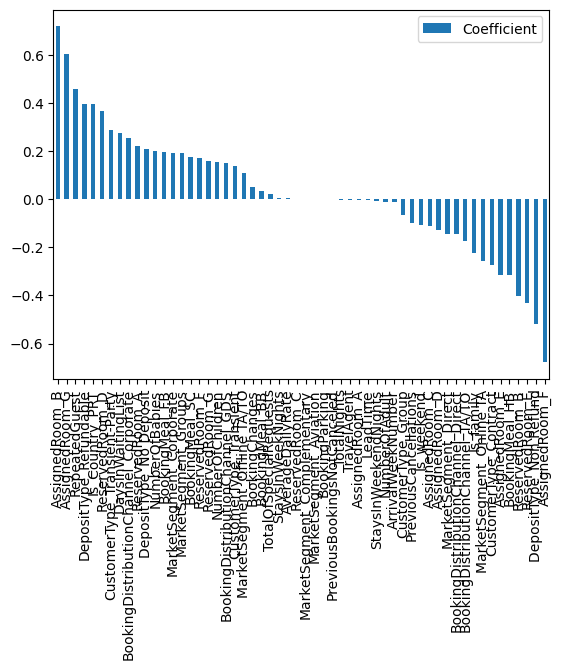

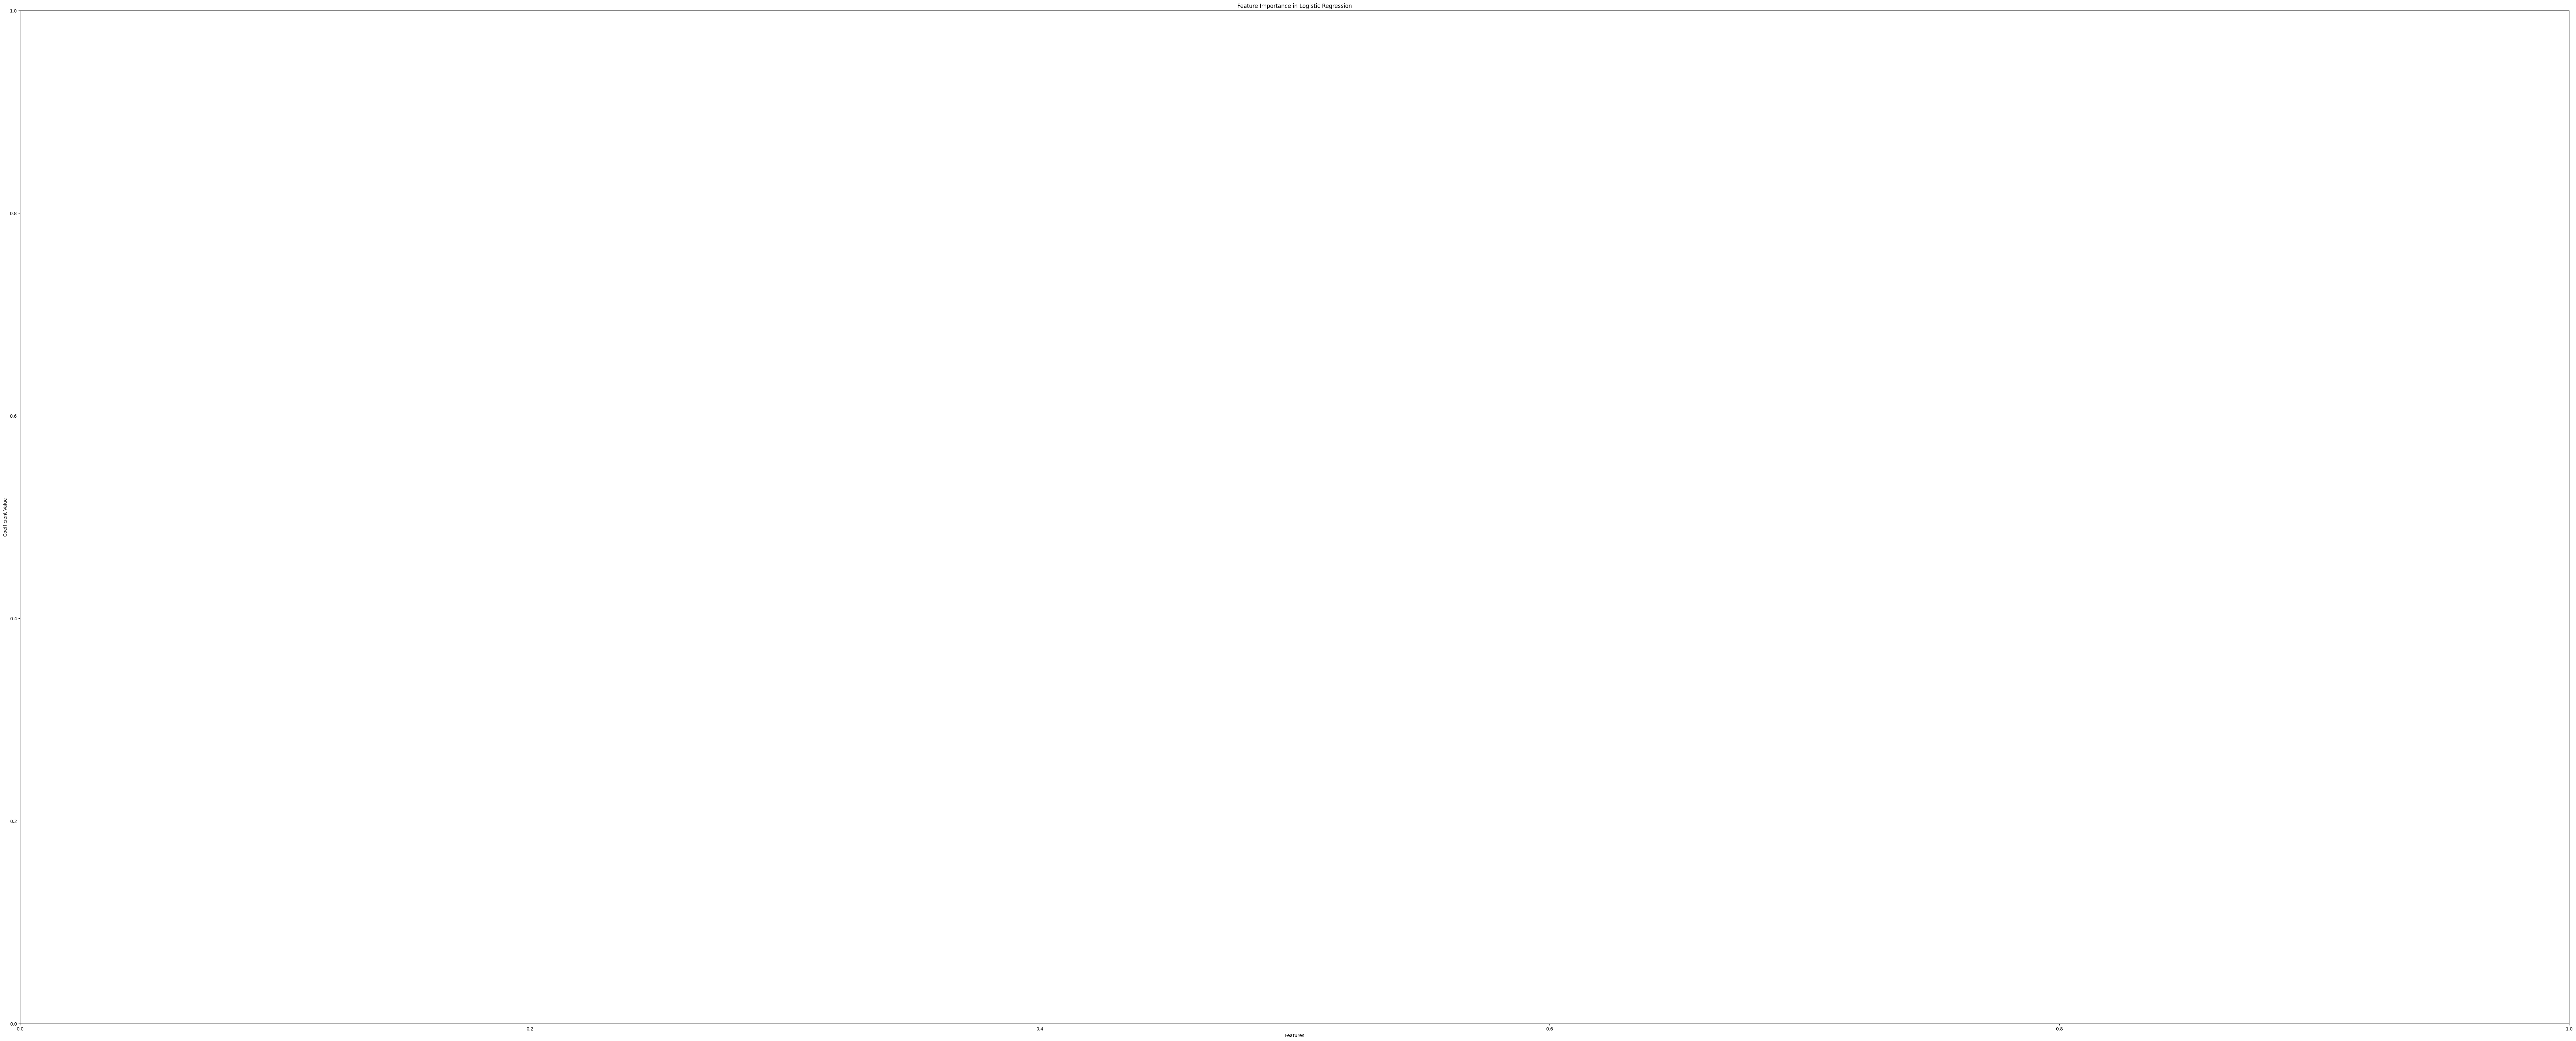

In [91]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

feature_importance.plot(kind='bar')
plt.figure(figsize=(100, 40))
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')

### SVM

In [92]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_Undersampled)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_Undersampled, y_train_Undersampled)

SVC(kernel='linear')

/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Cohen's Kappa Score: 0.0023105366355922197
AUC Score: 0.5145183592899689
Accuracy: 0.26803708182184605
Precision: 0.9732763228220203
Recall: 0.2522510042942236
F1 Score: 0.40066006600660065


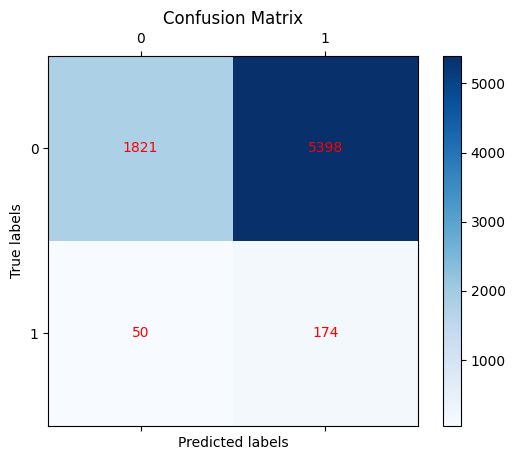

In [93]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [94]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[0.0109538  0.0052416  0.01565156 0.         0.15114175 0.00728747
 0.02825818 0.         0.07804356 0.         0.04164058 0.37118098
 0.1069154  0.04736045 0.02743578 0.00409832 0.07899575 0.13183427
 0.05955495 0.4049742  0.00200472 0.87685729 0.         0.0389751
 0.53099079 0.783078   0.47819132 0.40215403 0.49314781 0.
 0.49997346 0.53099079 0.1220111  0.         0.22266238 0.15602217
 0.07072345 0.13736366 0.14837761 0.         0.54544551 0.39706791
 0.39664958 0.         0.13318843 0.26346115 0.0700759  0.69836077
 0.62828486 0.         0.         0.22266238 0.15602217 0.19425905
 0.111198   0.37209725]


### Random Forest

In [95]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train_Undersampled, y_train_Undersampled)

RandomForestClassifier(random_state=215)

Cohen's Kappa Score: 0.019856413723926214
AUC Score: 0.576345840836681
Accuracy: 0.5599892516458417
Precision: 0.9779447406689288
Recall: 0.558941681673362
F1 Score: 0.7113265755839577


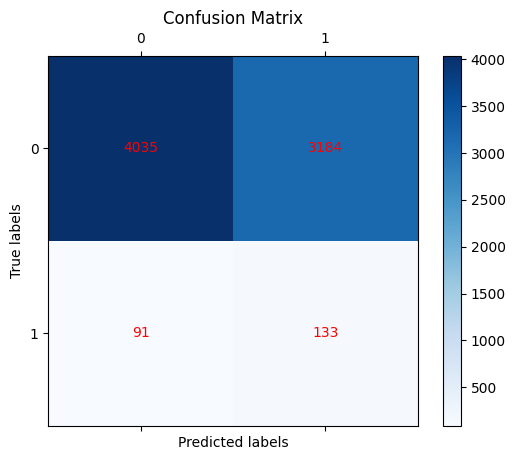

In [96]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}') 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [97]:
X_train

ArrivalWeekNumber  AverageDailyRate  BookingChanges  BookingParking  \
27715                 30            147.31               0             0.0   
11415                 29            122.71               0             0.0   
31267                 44            147.18               0             0.0   
19999                 22             82.40               0             0.0   
833                   19            340.70               0             0.0   
...                  ...               ...             ...             ...   
21837                 39            112.76               0             0.0   
21712                 41            134.75               0             0.0   
29487                 37             90.47               0             0.0   
12819                  8             75.35               0             0.0   
20582                 30             78.36               0             0.0   

       DaysInWaitingList  LeadTime  NumberOfAdult  NumberOfBabies  \
27715                  0        93              3               0   
11415                  0       276              2               0   
31267                  0       135              2               0   
19999                  0        62              2               0   
833                    0       148              3               0   
...                  ...       ...            ...             ...   
21837                  0       271              2               0   
21712                  0        32              2               0   
29487                  0       198              2               0   
12819                  0        15              1               0   
20582                  0       142              2               0   

       NumberOfChildren  PreviousBookingsNotCanceled  ...  \
27715               0.0                            0  ...   
11415               0.0                            0  ...   
31267               0.0                            0  ...   
19999               0.0                            0  ...   
833                 0.0                            0  ...   
...                 ...                          ...  ...   
21837               0.0                            0  ...   
21712               0.0                            0  ...   
29487               0.0                            0  ...   
12819               0.0                            0  ...   
20582               0.0                            0  ...   

       DepositType_No Deposit  DepositType_Non Refund  DepositType_Refundable  \
27715                    True                   False                   False   
11415                    True                   False                   False   
31267                    True                   False                   False   
19999                    True                   False                   False   
833                      True                   False                   False   
...                       ...                     ...                     ...   
21837                    True                   False                   False   
21712                    True                   False                   False   
29487                   False                    True                   False   
12819                    True                   False                   False   
20582                    True                   False                   False   

       MarketSegment_Aviation  MarketSegment_Complementary  \
27715                   False                        False   
11415                   False                        False   
31267                   False                        False   
19999                   False                        False   
833                     False                        False   
...                       ...                          ...   
21837                   False                        False   
21712                   False          

Text(0.5, 0, 'Features')

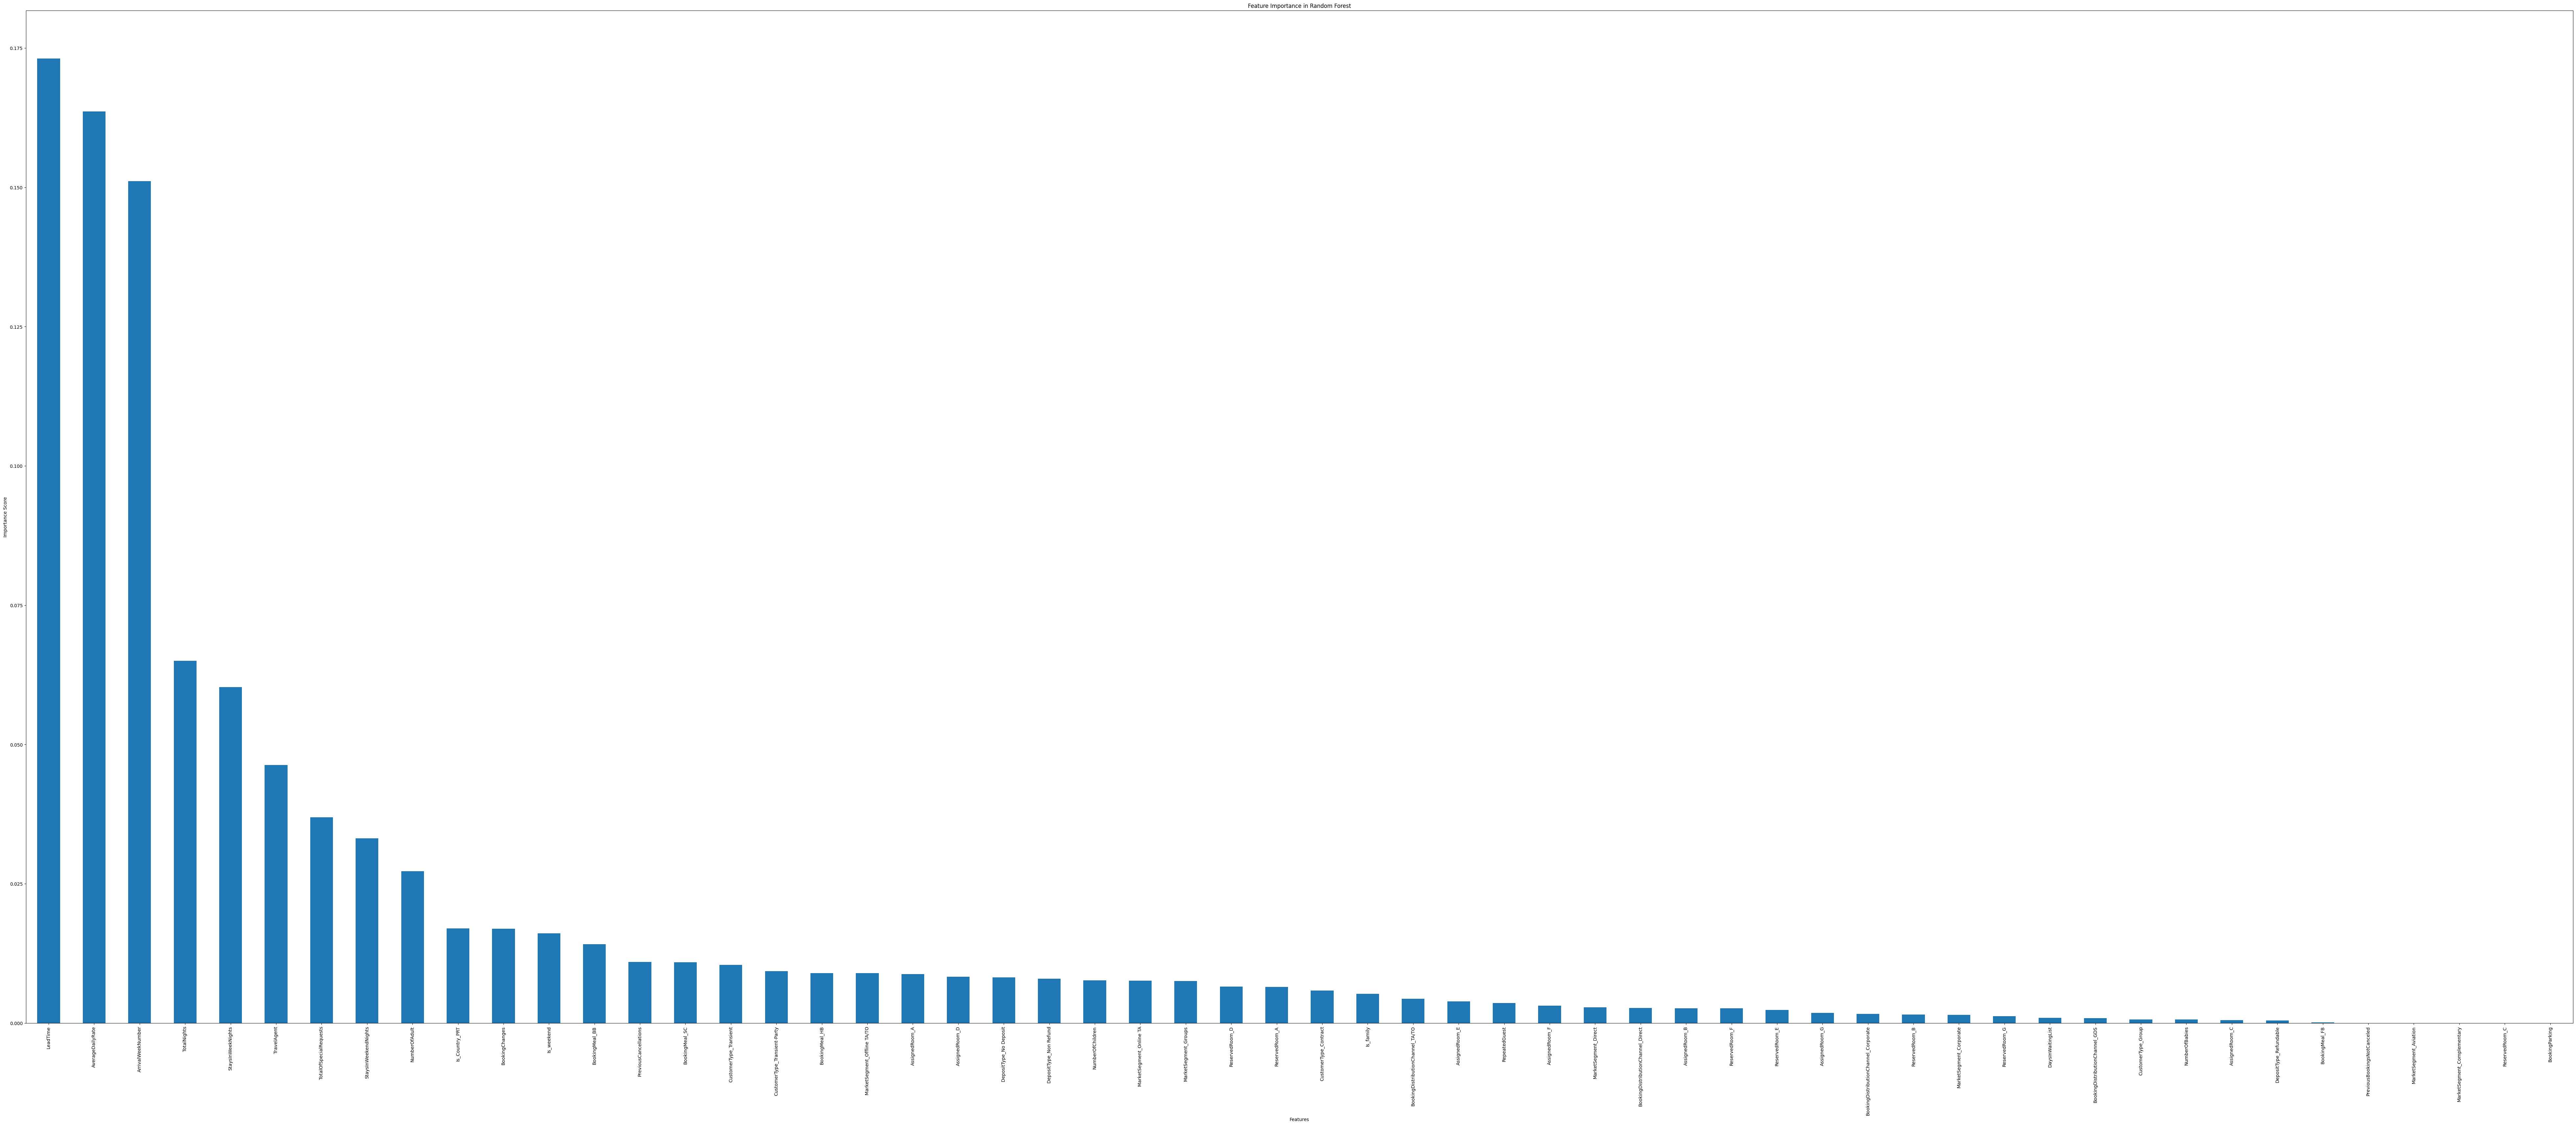

In [98]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [99]:
y_train_Undersampled=y_train_Undersampled.reset_index(drop=True)
for i in range(len(y_train_Undersampled)):
    y_train_Undersampled[i] = y_train_Undersampled[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [100]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train_Undersampled, y_train_Undersampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.017063514205300834
AUC Score: 0.5649615721409771
Accuracy: 0.5630794034663442
Precision: 0.038695917123705056
Recall: 0.5669642857142857
F1 Score: 0.07244723331431831


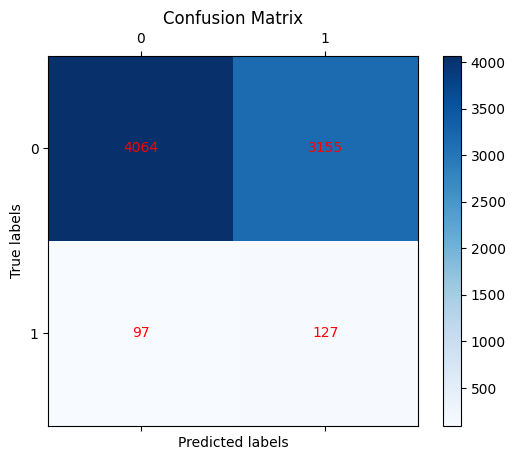

In [101]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}') 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

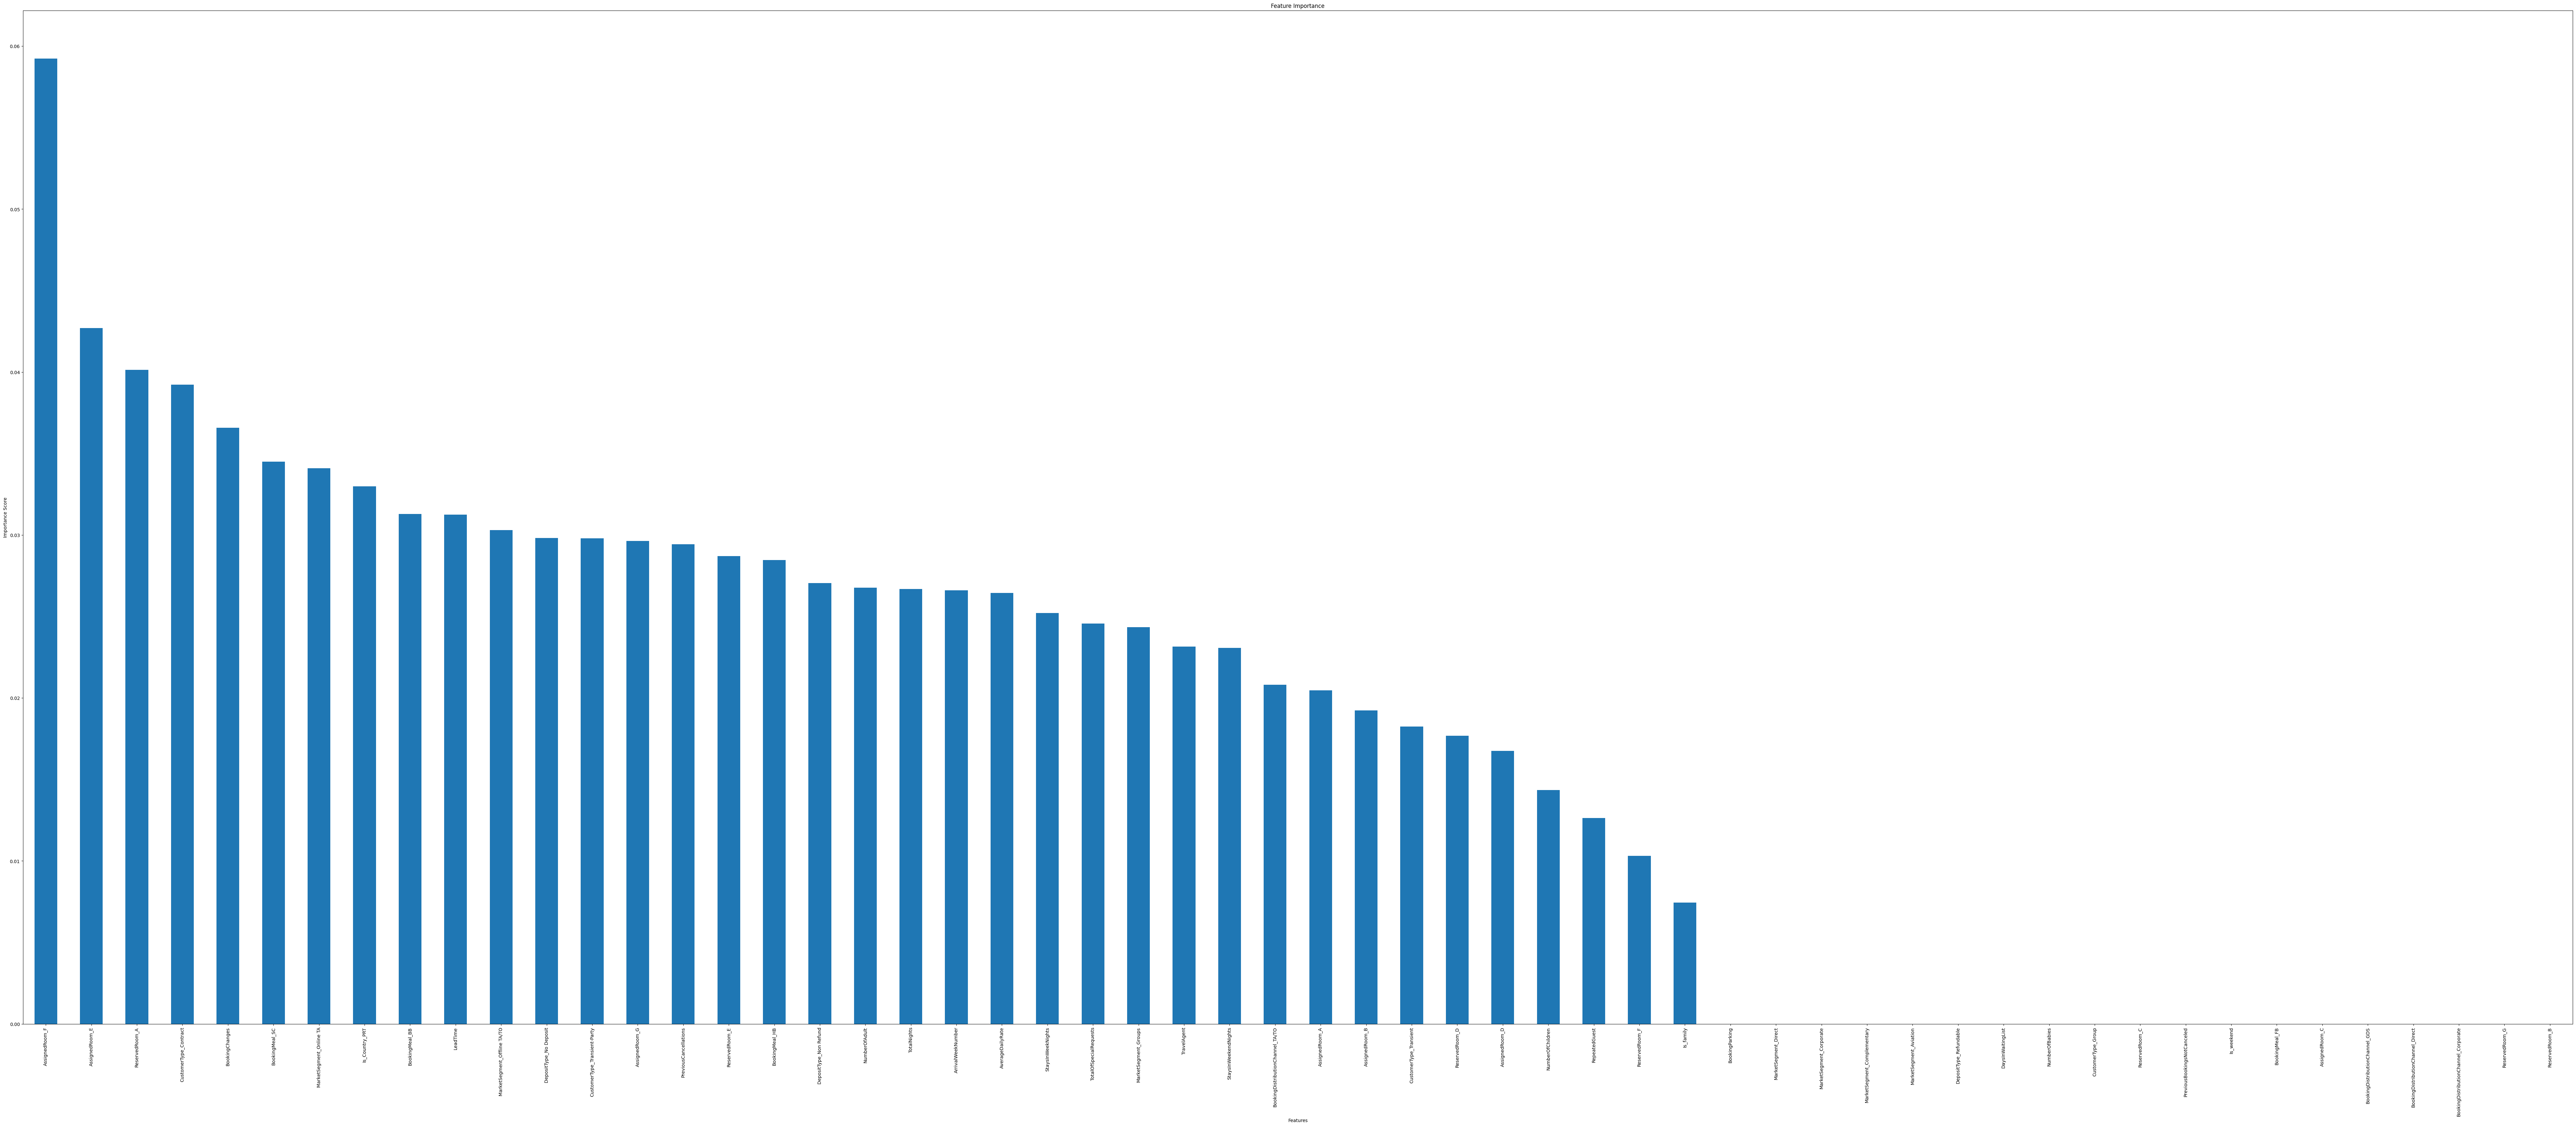

In [102]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

## Combination of overasmpling and under sampling

In [103]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

In [104]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

oversample_strategy = 0.2  

# Define undersampling strategy to reduce the size of the majority class
undersample_strategy = 0.5 

# Create a pipeline that first oversamples, then undersamples
resampling_pipeline = Pipeline([
    ('oversample', BorderlineSMOTE(sampling_strategy=oversample_strategy)),
    ('undersample', RandomUnderSampler(sampling_strategy=undersample_strategy))
])

# Apply the pipeline to the training data
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

# Now X_train_resampled and y_train_resampled can be used to train a machine learning model

In [105]:
print(len(X_train_resampled))
print(len(y_train_resampled))

10104
10104


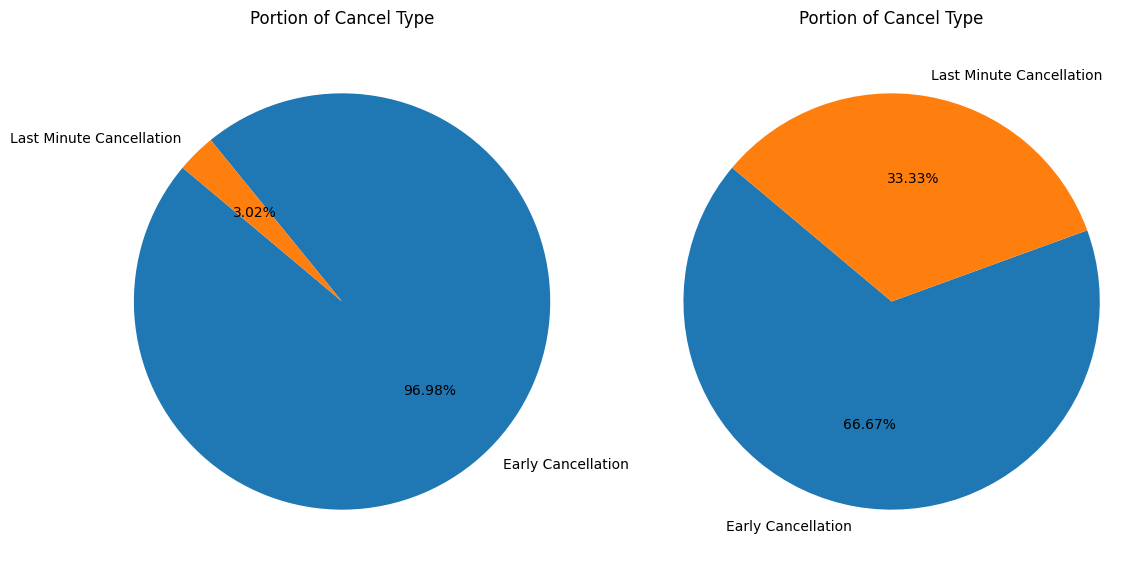

In [106]:
Counts_CancelType = y_train.value_counts()
Counts_CancelType_only_cancel = y_train_resampled .value_counts()

# Plotting the pie chart of the portion of cancellation type
fig, axs = plt.subplots(1, 2, figsize=(13, 7))  # 2 rows, 2 columns
label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[0].pie(Counts_CancelType, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[0].axis('equal') 
axs[0].set_title('Portion of Cancel Type')

label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[1].pie(Counts_CancelType_only_cancel, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[1].axis('equal') 
axs[1].set_title('Portion of Cancel Type')

plt.show()

### Logistic Regression

In [107]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [108]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42, solver='liblinear')

Cohen's Kappa Score: 0.0002908403276025151
AUC Score: 0.5000850310688066
Accuracy: 0.9658739755474943
Precision: 0.9699095938469842
Recall: 0.9957057764233274
F1 Score: 0.9826384142173615


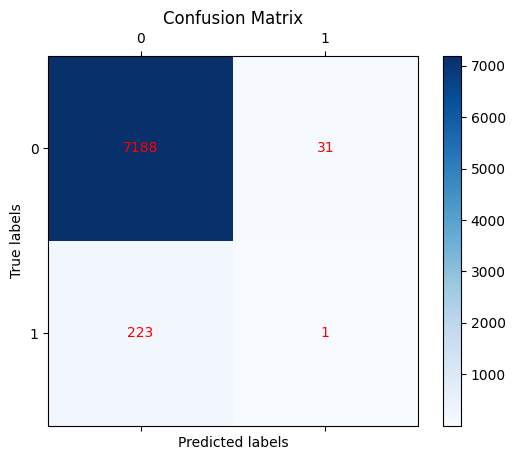

In [109]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')             
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

### SVM

### Random Forest

### XGboost

In [110]:
y_train_resampled=y_train_resampled.reset_index(drop=True)
for i in range(len(y_train_resampled)):
    y_train_resampled[i] = y_train_resampled[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [111]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.05241664327172313
AUC Score: 0.5198595472265649
Accuracy: 0.9580814187827489
Precision: 0.10714285714285714
Recall: 0.05357142857142857
F1 Score: 0.07142857142857142


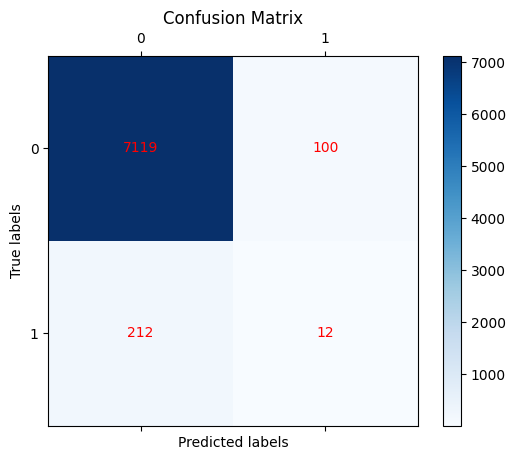

In [112]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}') 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

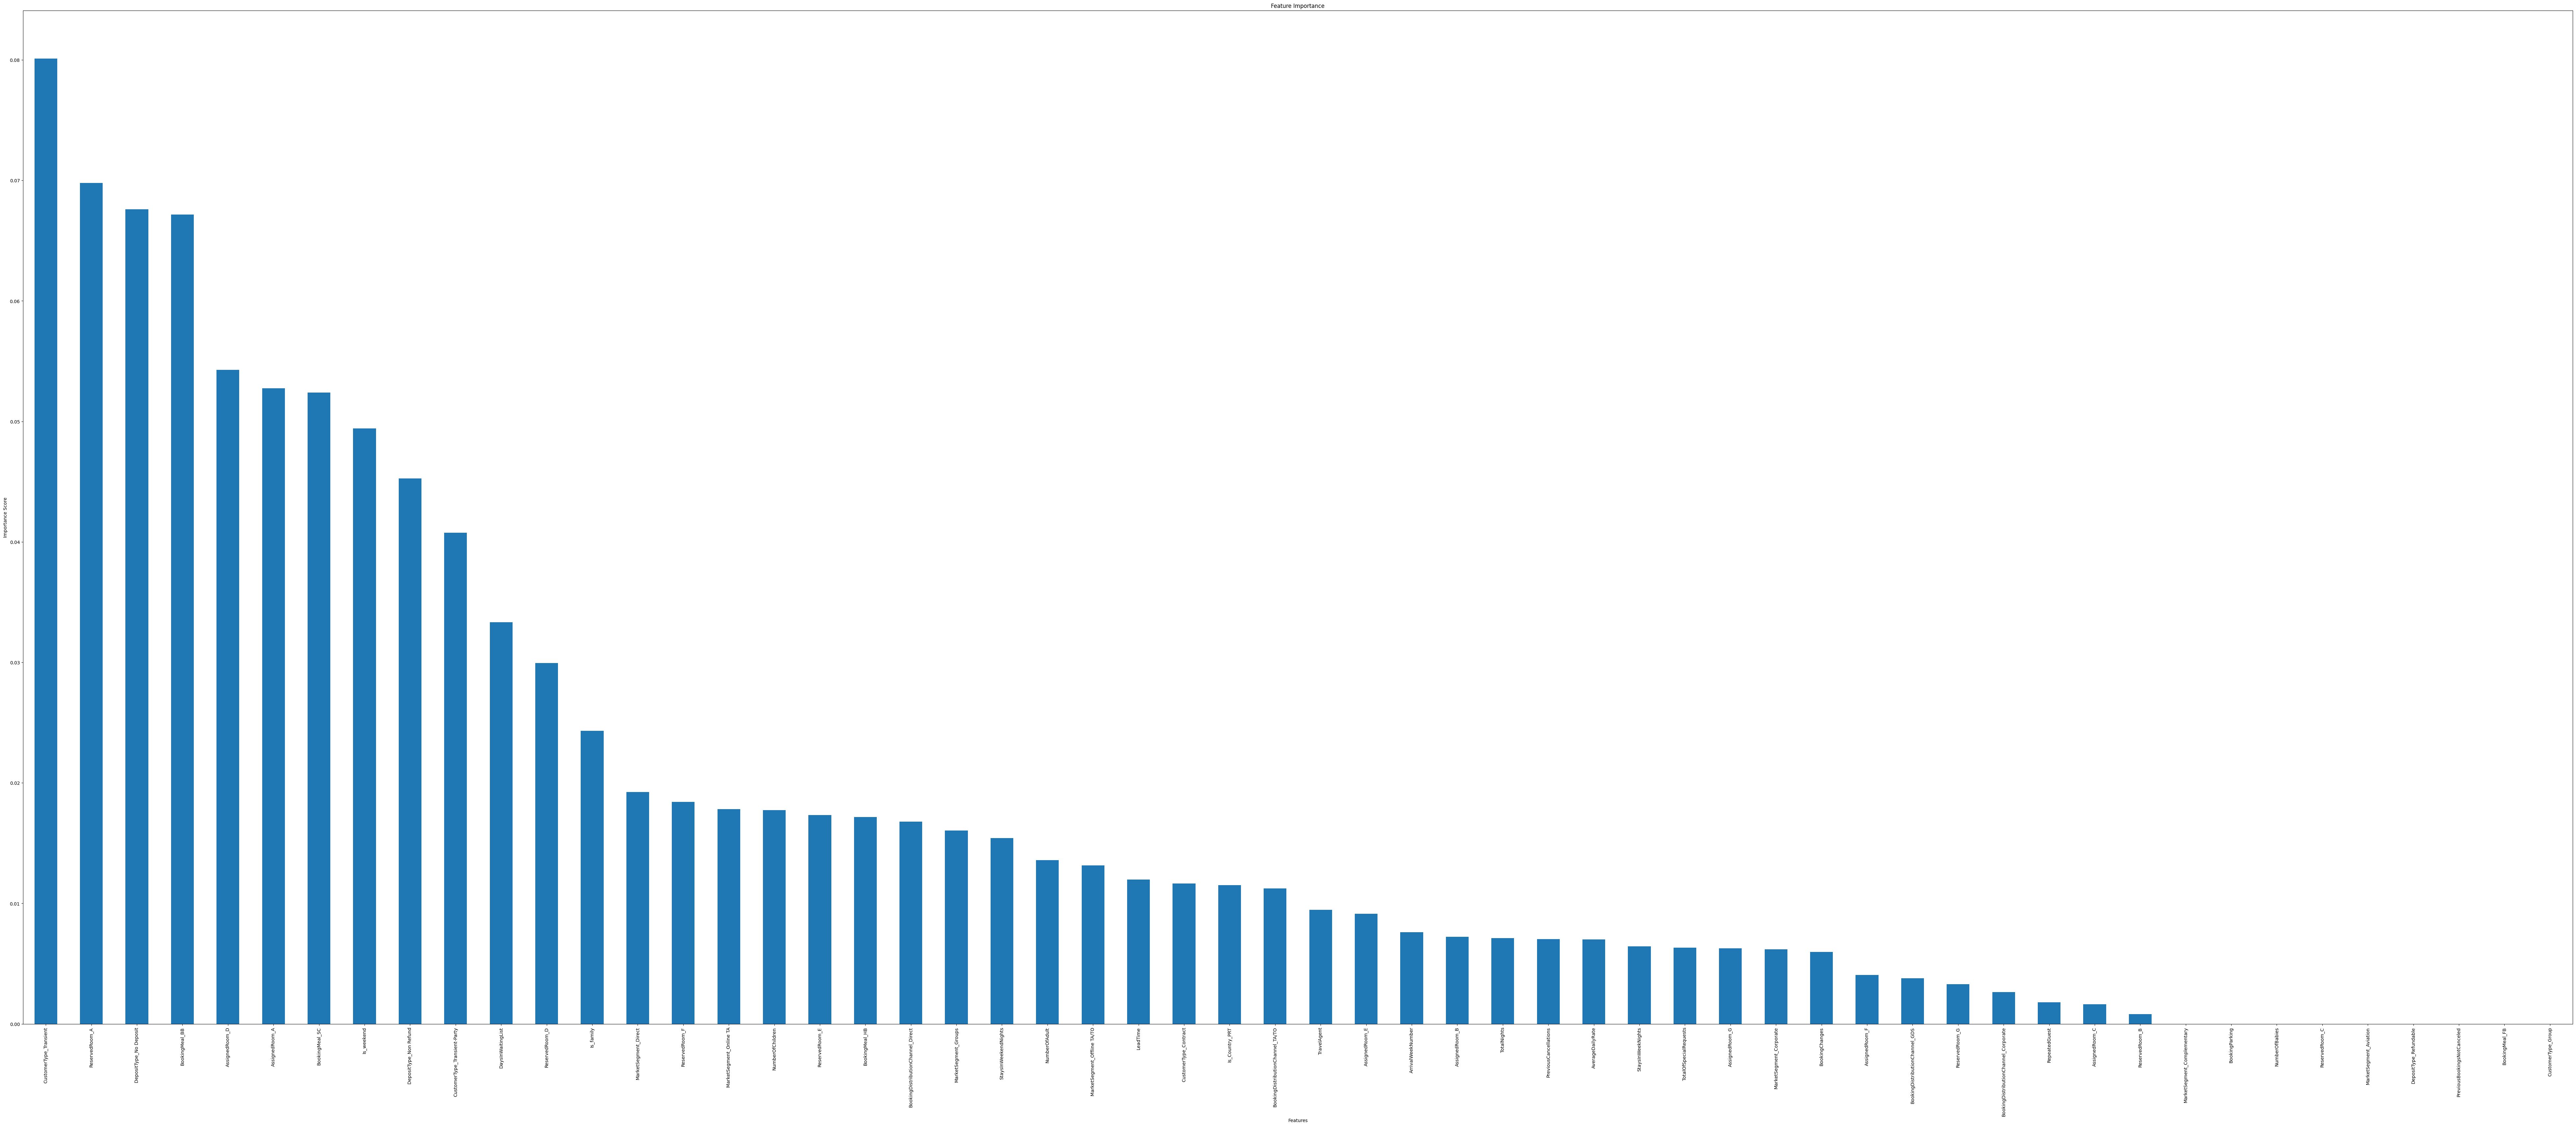

In [113]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Feature Engineering
keep Country_PRT, LeadTime, DepositType_No_Deposit, PreviousCancellations, TotalOfSpecialRequests,EarlyDailyRate, ArrivalWeekNumber, AverageDailyRate

In [ ]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/Work/Job/Full Time/Taiwan/Interview/友達/project/GHR_Cancellation_Analysis/Data/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [115]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #cancel
    if row['ReservationStatus'] == 'Canceled':
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)


In [116]:
#drop BookingCompany
Data.drop('BookingCompany', axis=1, inplace=True)
Data = Data.dropna()
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2017-08-14                 33            A             78.49   
1      2017-04-24                 17            A            113.86   
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
4      2016-10-12                 41            A            129.25   
...           ...                ...          ...               ...   
94359  2017-09-18                 38            F            190.87   
94360  2017-09-24                 38            A            171.88   
94361  2017-11-28                 48            A             88.68   
94362  2017-11-03                 44            A             72.41   
94363  2017-09-19                 38            A            101.03   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          SC             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          HB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
94359               1                     Direct          BB             0.0   
94360               0                      TA/TO          BB             0.0   
94361               0                      TA/TO          SC             0.0   
94362               1                      TA/TO          SC             0.0   
94363               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         BRA        Transient  ...                      0             0   
1         AUT  Transient-Party  ...                      0             0   
2         ITA  Transient-Party  ...                      0             0   
3         CHE        Transient  ...                      0             0   
4         PRT        Transient  ...                      0             0   
...       ...              ...  ...                    ...           ...   
94359     PRT        Transient  ...                      0             0   
94360     PRT  Transient-Party  ...                      1             0   
94361     NLD        Transient  ...                      0             0   
94362     AUS        Transient  ...                      0             0   
94363     PRT         Contract  ...                      0             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2017-08-21            A                     2   
1                 2017-04-27            A                     2   
2                 2015-07-09            A                     2   
3                 2017-05-02            D                     1   
4                 2016-10-16            A                     0   
...                      ...          ...                   ...   
94359             2017-09-20            D                     1   
94360             2017-07-23            A                     2   
94361             2017-12-29            A                     2   
94362             2017-11-05            A                     0   
94363             2017-09-20            A                     1   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      4                       2          9.0   
1                      2                       0         21.0   
2                      1                       0         17.0   
3                      3                       1          9.0   
4                      2                       2          9.0   
...                  ...                     ...          ...   
94359              

## Preprocessing

In [117]:
Data = Data[Data['AverageDailyRate'] > 0]
Data = Data[Data['LeadTime'] <= 300]
Data = Data[Data['NumberOfAdult'] > 0]
Data = Data[Data['DaysInWaitingList'] <= 14]
Data = Data[Data['StaysInWeekNights'] + Data['StaysInWeekendNights'] > 0]

In [118]:
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Data['AssignedRoom'] = Data['AssignedRoom'].str.replace(' ','')
Data['ReservedRoom'] = Data['ReservedRoom'].str.replace(' ','')

In [119]:
# Family
Data['Is_family'] = (Data['NumberOfChildren'] > 0) | (Data['NumberOfBabies'] > 0)
Data['Is_family'] = Data['Is_family'].astype(int)

In [120]:
# Weekend & total of night
Data['Is_weekend'] = (Data['StaysInWeekendNights'] > 0).astype(int)
Data['TotalNights'] = Data['StaysInWeekendNights'] + Data['StaysInWeekNights']

In [121]:
#Add new Column Is_Country_PRT(1 means yes)
Data['Is_Country_PRT'] = (Data['Country'] == 'PRT').astype(int)
#Add new Column Is_Country_PRT(1 means yes)
Data['DepositType_No_Deposit'] = (Data['DepositType'] == 'No Deposit').astype(int)
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2017-08-14                 33            A             78.49   
1      2017-04-24                 17            A            113.86   
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
4      2016-10-12                 41            A            129.25   
...           ...                ...          ...               ...   
94358  2017-12-08                 49            A             80.54   
94359  2017-09-18                 38            F            190.87   
94361  2017-11-28                 48            A             88.68   
94362  2017-11-03                 44            A             72.41   
94363  2017-09-19                 38            A            101.03   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          SC             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          HB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
94358               0                      TA/TO          BB             0.0   
94359               1                     Direct          BB             0.0   
94361               0                      TA/TO          SC             0.0   
94362               1                      TA/TO          SC             0.0   
94363               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  StaysInWeekNights TotalOfSpecialRequests  \
0         BRA        Transient  ...                  4                      2   
1         AUT  Transient-Party  ...                  2                      0   
2         ITA  Transient-Party  ...                  1                      0   
3         CHE        Transient  ...                  3                      1   
4         PRT        Transient  ...                  2                      2   
...       ...              ...  ...                ...                    ...   
94358     FRA        Transient  ...                  3                      0   
94359     PRT        Transient  ...                  2                      1   
94361     NLD        Transient  ...                  2                      0   
94362     AUS        Transient  ...                  1                      2   
94363     PRT         Contract  ...                  2                      2   

       TravelAgent days_difference  CancelType  Is_family  Is_weekend  \
0              9.0              -7           0          0           1   
1             21.0              -3           0          0           1   
2             17.0              47           1          0           1   
3              9.0             105           1          0           1   
4              9.0              -4           0          0           0   
...            ...             ...         ...        ...         ...   
94358         89.0              -3           0          0           1   
94359         14.0              -2           0          0           1   
94361          9.0             -31           0          0           1   
94362          8.0              -2           0          0           0   
94363          9.0              -1           0          0           1   

       TotalNights  Is_Country_PRT  DepositType_No_Deposit  
0                6               0                       1  
1                4               0                       1  
2                3               0                       1  
3                4               0                       1  
4                2               1   

In [122]:
#Select Feature
Data = Data[['Is_Country_PRT','LeadTime', 'DepositType_No_Deposit', 'PreviousCancellations', 'TotalOfSpecialRequests','CancelType','AverageDailyRate','ArrivalWeekNumber']]
Data

Is_Country_PRT  LeadTime  DepositType_No_Deposit  \
0                   0         8                       1   
1                   0        77                       1   
2                   0       117                       1   
3                   0       265                       1   
4                   1         0                       1   
...               ...       ...                     ...   
94358               0        51                       1   
94359               1         0                       1   
94361               0        18                       1   
94362               0        74                       1   
94363               1        45                       1   

       PreviousCancellations  TotalOfSpecialRequests  CancelType  \
0                          0                       2           0   
1                          0                       0           0   
2                          0                       0           1   
3                          0                       1           1   
4                          0                       2           0   
...                      ...                     ...         ...   
94358                      0                       0           0   
94359                      0                       1           0   
94361                      0                       0           0   
94362                      0                       2           0   
94363                      0                       2           0   

       AverageDailyRate  ArrivalWeekNumber  
0                 78.49                 33  
1                113.86                 17  
2                 94.51                 35  
3                124.99                 33  
4                129.25                 41  
...                 ...                ...  
94358             80.54                 49  
94359            190.87                 38  
94361             88.68                 48  
94362             72.41                 44  
94363            101.03                 38  

[69416 rows x 8 columns]

In [123]:
#One Hot Enocde Categorical data
# Data= pd.get_dummies(Data, columns=['DepositType'])
# Data

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [124]:
# If 'CancelType' is your target variable
y = Data['CancelType']

# Drop the target variable from the feature set
X = Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns


### Logistic Regression

In [125]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=215)

In [126]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train, y_train)


LogisticRegression(random_state=42, solver='liblinear')

Cohen's Kappa Score: 0.37489048451597073
AUC Score: 0.66396462754181
Accuracy: 0.7482833133253302
Precision: 0.8479477611940298
Recall: 0.364572192513369
F1 Score: 0.5099102468212415


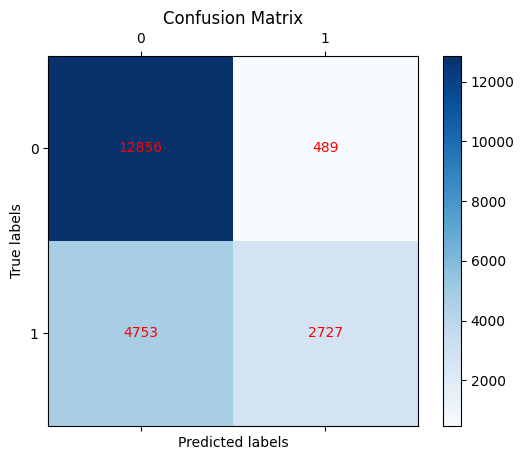

In [127]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')               
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                        Coefficient
PreviousCancellations      0.614398
LeadTime                   0.401240
AverageDailyRate           0.246646
Is_Country_PRT             0.221860
ArrivalWeekNumber          0.011738
TotalOfSpecialRequests    -0.417019
DepositType_No_Deposit    -1.504357


<Figure size 10000x4000 with 0 Axes>

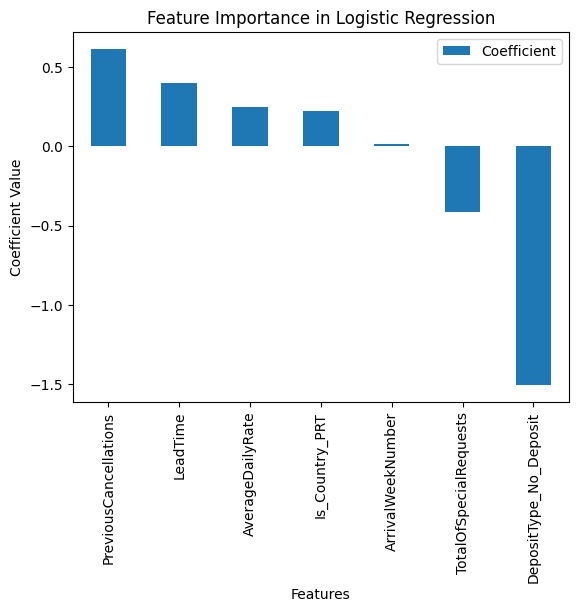

In [128]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(100, 40))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [129]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Cohen's Kappa Score: 0.35501605622214405
AUC Score: 0.6504589733982765
Accuracy: 0.7483313325330132
Precision: 0.9882250327082425
Recall: 0.3029411764705882
F1 Score: 0.4637265936764555


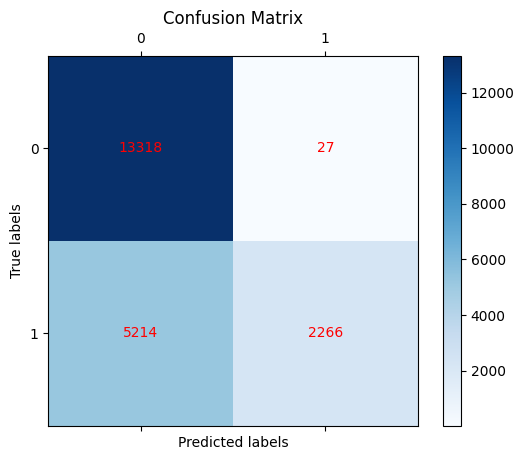

In [130]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')               
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [131]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[6.62463444e-05 1.27426960e-04 5.63059033e-01 5.65635270e-01
 9.23647099e-06 4.41468558e-05 2.23632481e-05]


### Random Forest

In [132]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Cohen's Kappa Score: 0.4251713529169955
AUC Score: 0.7010256650430873
Accuracy: 0.7497719087635054
Precision: 0.7015455675963759
Recall: 0.5279411764705882
F1 Score: 0.6024868411015333


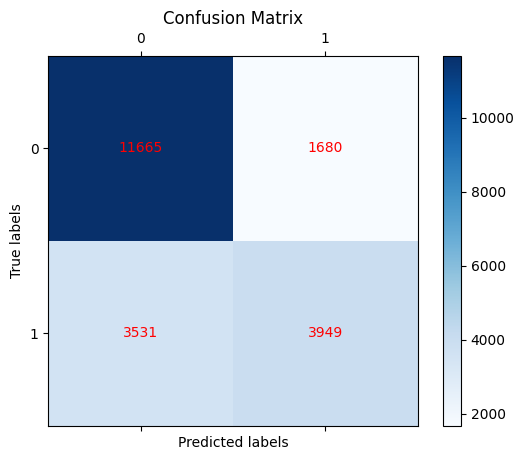

In [133]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}') 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

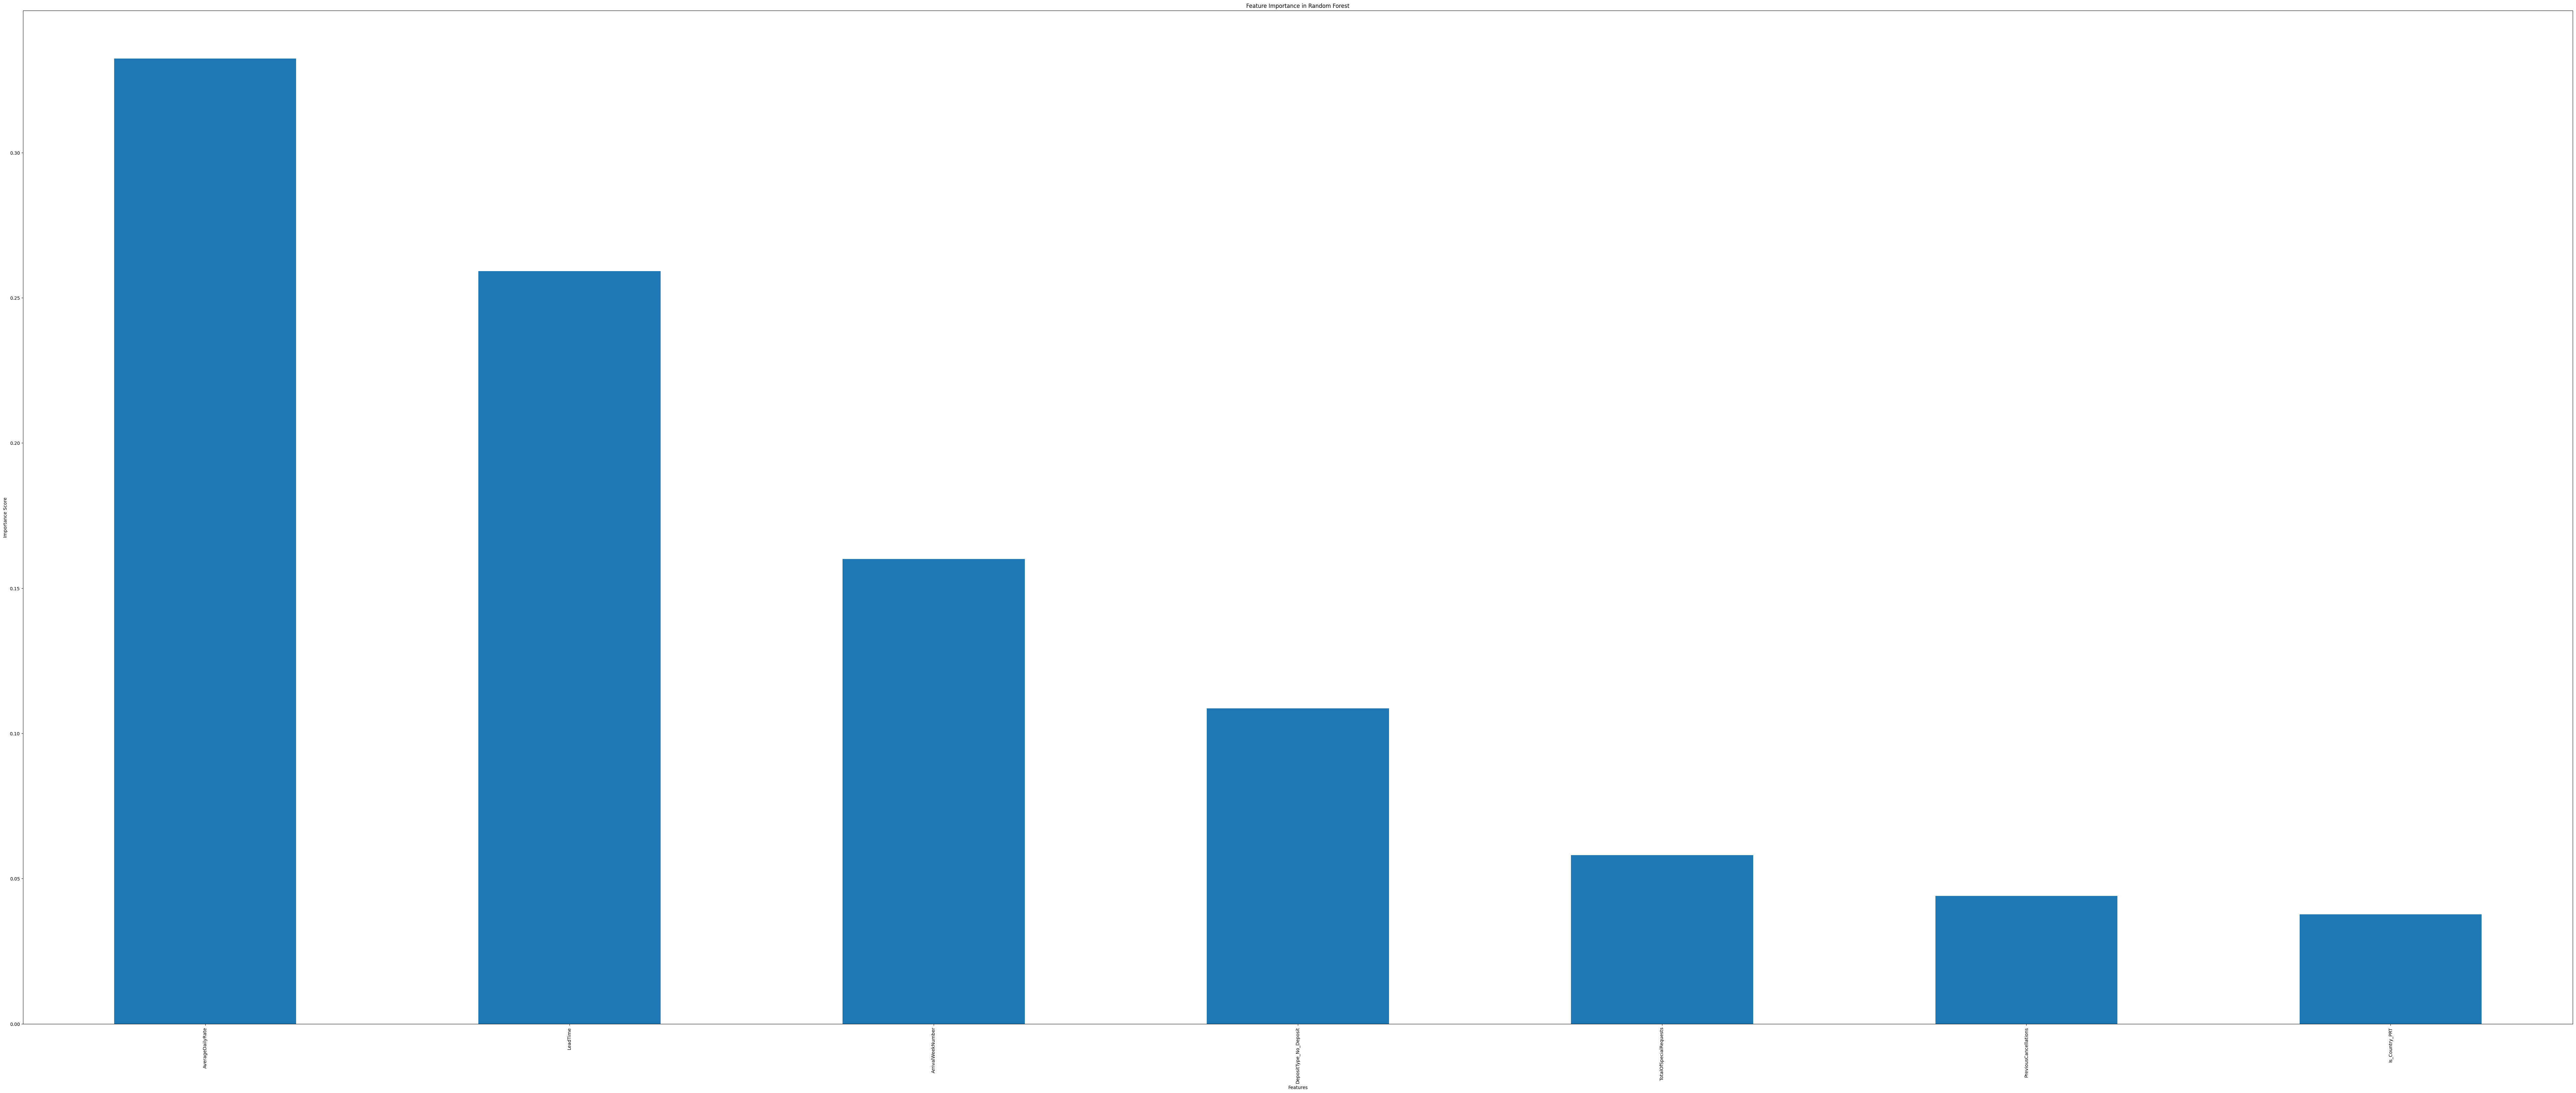

In [134]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [135]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.44823973984910215
AUC Score: 0.7078702442181273
Accuracy: 0.7644177671068427
Precision: 0.7567837190742218
Recall: 0.5070855614973262
F1 Score: 0.6072686519372398


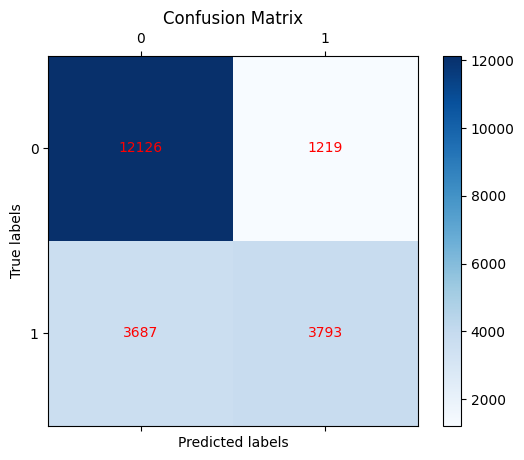

In [136]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}') 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

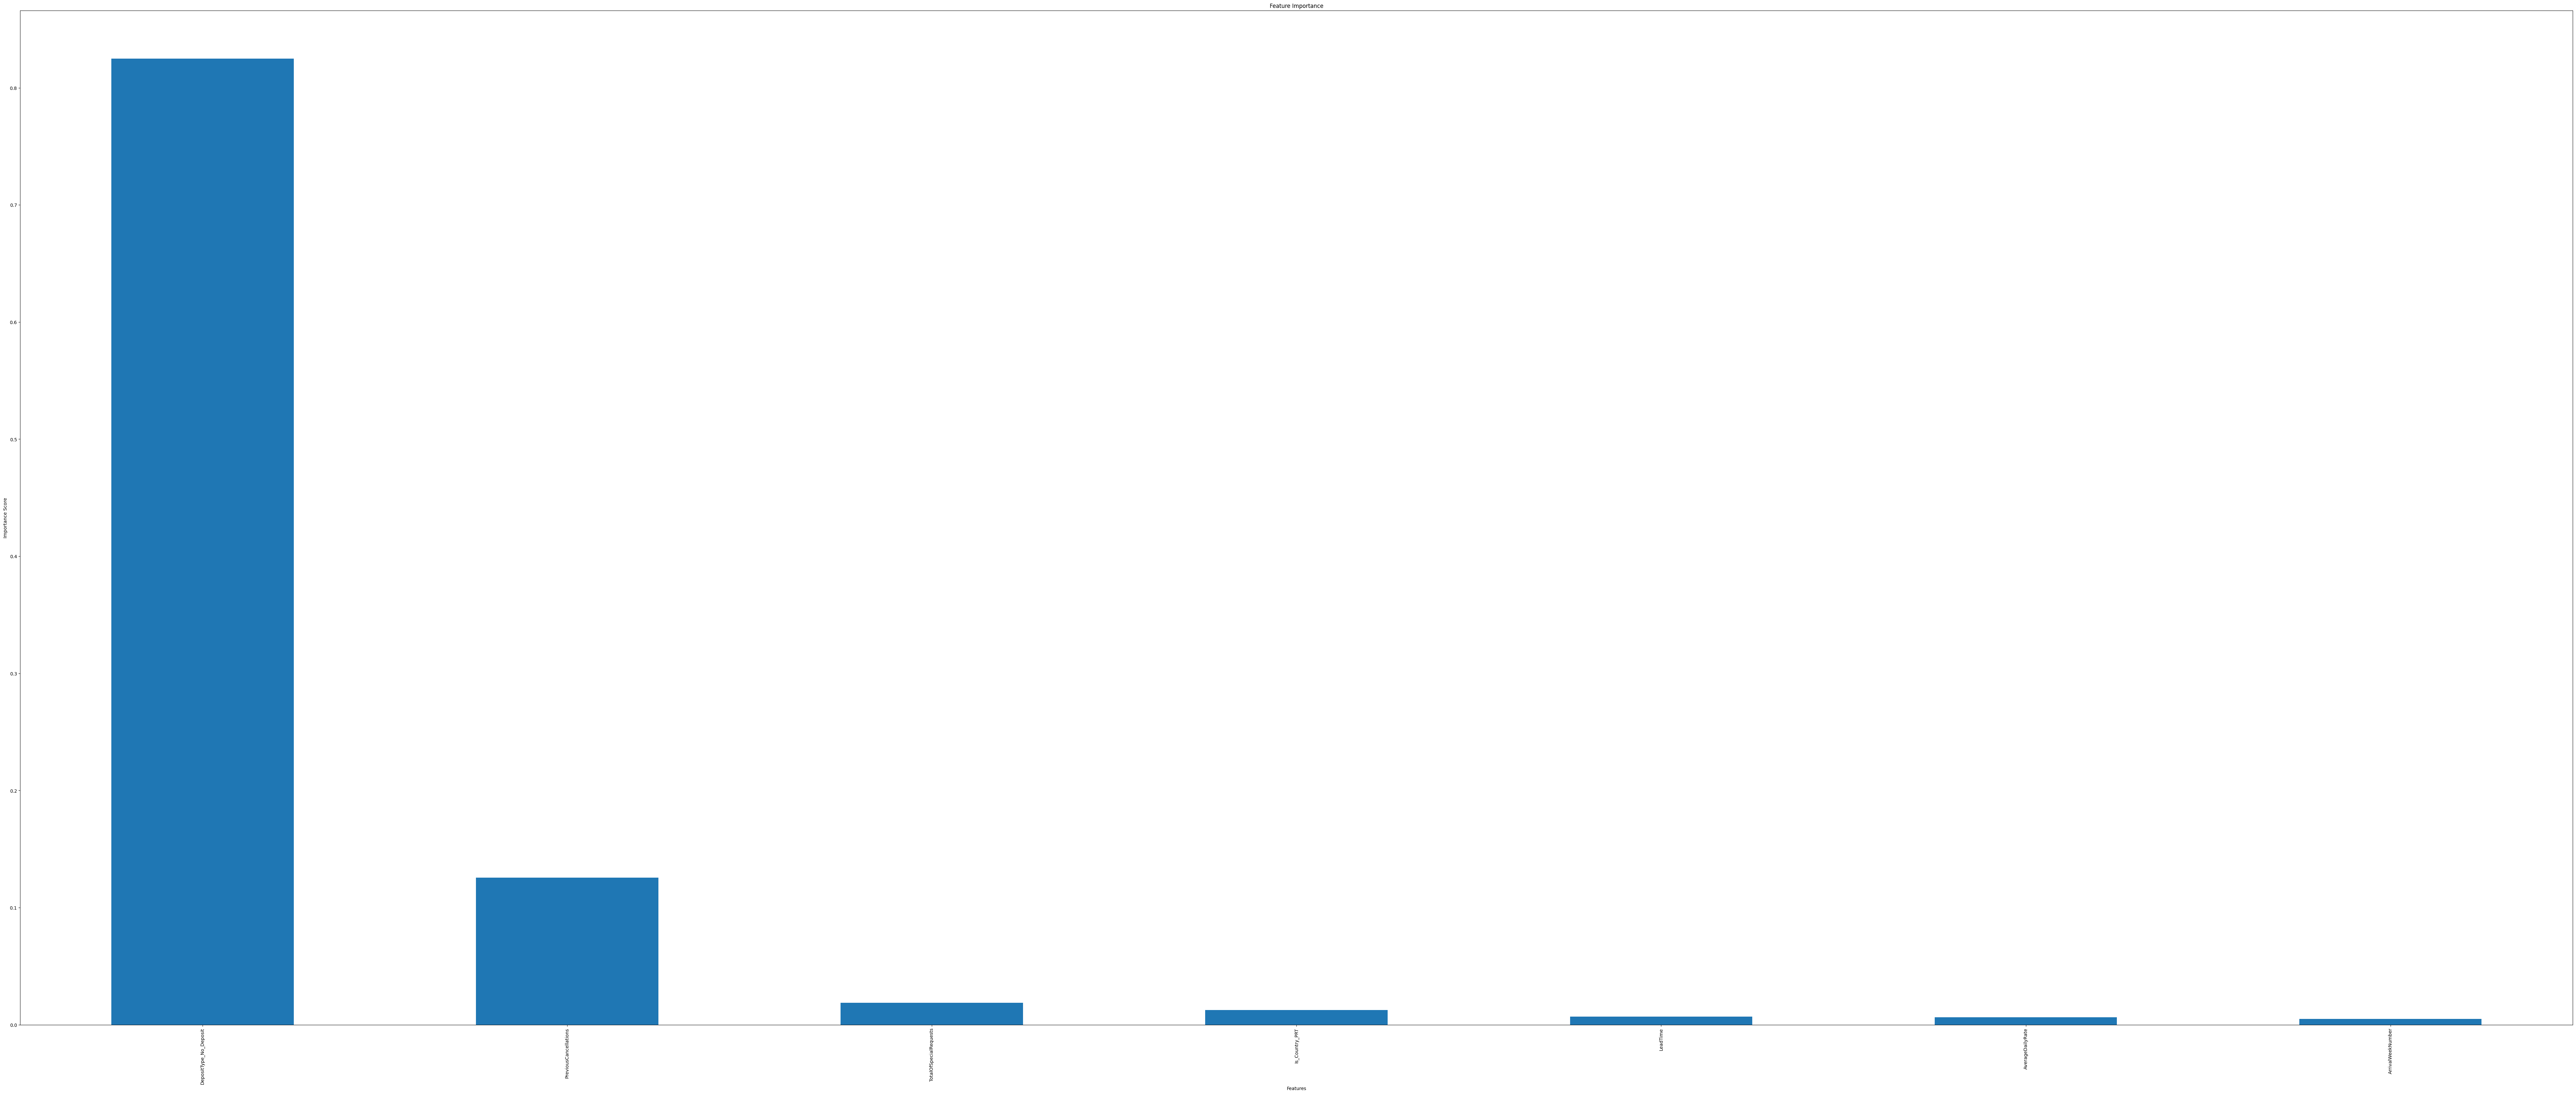

In [137]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Feature Engineering Early and Late

In [ ]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/Work/Job/Full Time/Taiwan/Interview/友達/project/GHR_Cancellation_Analysis/Data/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [139]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 3:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 3:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)

In [140]:
#filter out no cancellation data
Cancel_Data = Data[Data["CancelType"]!=0].reset_index(drop=True)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          HB   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          BB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
34719               0             NaN                      TA/TO          SC   
34720               0             NaN                      TA/TO          BB   
34721               0             NaN                      TA/TO          BB   
34722               0             NaN                      TA/TO          BB   
34723               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousCancellations  RepeatedGuest  \
0                 0.0     ITA  ...                     0              0   
1                 0.0     CHE  ...                     0              0   
2                 0.0     PRT  ...                     0              0   
3                 0.0     PRT  ...                     0              0   
4                 0.0     PRT  ...                     0              0   
...               ...     ...  ...                   ...            ...   
34719             0.0     CHN  ...                     0              0   
34720             0.0     PRT  ...                     0              0   
34721             0.0     DEU  ...                     0              0   
34722             0.0     FRA  ...                     0              0   
34723             0.0     PRT  ...                     1              0   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
0                2015-07-09             A                    2   
1                2017-05-02             D                    1   
2                2017-01-24             A                    0   
3                2017-04-12             A                    0   
4                2016-01-21             A                    0   
...                     ...           ...                  ...   
34719            2017-07-17             A                    1   
34720            2017-01-16             A                    1   
34721            2017-05-02             D                    1   
34722            2017-09-28             D                    1   
34723            2017-07-23             A                    2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719                  2                   

In [141]:
#drop BookingCompany and other record contain null value
Cancel_Data.drop('BookingCompany', axis=1, inplace=True)
Cancel_Data = Cancel_Data.dropna()
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   
34723               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         ITA  Transient-Party  ...                      0             0   
1         CHE        Transient  ...                      0             0   
2         PRT        Transient  ...                      0             0   
3         PRT        Transient  ...                      0             0   
4         PRT  Transient-Party  ...                      0             0   
...       ...              ...  ...                    ...           ...   
34719     CHN        Transient  ...                      0             0   
34720     PRT        Transient  ...                      0             0   
34721     DEU        Transient  ...                      0             0   
34722     FRA        Transient  ...                      0             0   
34723     PRT  Transient-Party  ...                      1             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2015-07-09            A                     2   
1                 2017-05-02            D                     1   
2                 2017-01-24            A                     0   
3                 2017-04-12            A                     0   
4                 2016-01-21            A                     0   
...                      ...          ...                   ...   
34719             2017-07-17            A                     1   
34720             2017-01-16            A                     1   
34721             2017-05-02            D                     1   
34722             2017-09-28            D                     1   
34723             2017-07-23            A                     2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719              

## Preproessing

In [142]:
Cancel_Data = Cancel_Data[Cancel_Data['AverageDailyRate'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['LeadTime'] <= 300]
Cancel_Data = Cancel_Data[Cancel_Data['NumberOfAdult'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['DaysInWaitingList'] <= 14]
Cancel_Data  = Cancel_Data[Cancel_Data['StaysInWeekNights'] + Cancel_Data['StaysInWeekendNights'] > 0]

In [143]:
Cancel_Data['ArrivalDate'] = pd.to_datetime(Cancel_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Cancel_Data['AssignedRoom'] = Cancel_Data['AssignedRoom'].str.replace(' ','')
Cancel_Data['ReservedRoom'] = Cancel_Data['ReservedRoom'].str.replace(' ','')

In [144]:
# Family
Cancel_Data['Is_family'] = (Cancel_Data['NumberOfChildren'] > 0) | (Cancel_Data['NumberOfBabies'] > 0)
Cancel_Data['Is_family'] = Cancel_Data['Is_family'].astype(int)

In [145]:
# Weekend & total of night
Cancel_Data['Is_weekend'] = (Cancel_Data['StaysInWeekendNights'] > 0).astype(int)
Cancel_Data['TotalNights'] = Cancel_Data['StaysInWeekendNights'] + Cancel_Data['StaysInWeekNights']

In [146]:
#Add new Column Is_Country_PRT(1 means yes)
Cancel_Data['Is_Country_PRT'] = (Cancel_Data['Country'] == 'PRT').astype(int)
#Add new Column Is_Country_PRT(1 means yes)
Cancel_Data['DepositType_No_Deposit'] = (Cancel_Data['DepositType'] == 'No Deposit').astype(int)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
7      2015-10-16                 42            A             89.62   
...           ...                ...          ...               ...   
34718  2017-09-02                 35            D            114.00   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
7                   0                      TA/TO          HB             0.0   
...               ...                        ...         ...             ...   
34718               0                      TA/TO          BB             0.0   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  StaysInWeekNights TotalOfSpecialRequests  \
0         ITA  Transient-Party  ...                  1                      0   
1         CHE        Transient  ...                  3                      1   
2         PRT        Transient  ...                  2                      0   
3         PRT        Transient  ...                  1                      1   
7         PRT        Transient  ...                  2                      0   
...       ...              ...  ...                ...                    ...   
34718     ESP        Transient  ...                  2                      0   
34719     CHN        Transient  ...                  2                      0   
34720     PRT        Transient  ...                  3                      0   
34721     DEU        Transient  ...                  4                      0   
34722     FRA        Transient  ...                  2                      2   

       TravelAgent days_difference  CancelType  Is_family  Is_weekend  \
0             17.0              47           1          0           1   
1              9.0             105           1          0           1   
2            154.0             139           1          0           0   
3              9.0              42           1          0           0   
7              1.0              98           1          0           0   
...            ...             ...         ...        ...         ...   
34718          9.0              86           1          0           1   
34719          9.0              68           1          0           1   
34720         37.0             249           1          0           1   
34721          9.0             127           1          0           1   
34722          9.0              43           1          0           1   

       TotalNights  Is_Country_PRT  DepositType_No_Deposit  
0                3               0                       1  
1                4               0                       1  
2                2               1                       0  
3                1               1                       1  
7                2               1   

In [147]:
#Select Feature
Cancel_Data = Cancel_Data[['Is_Country_PRT','LeadTime', 'DepositType_No_Deposit', 'PreviousCancellations', 'TotalOfSpecialRequests','CancelType','AverageDailyRate','ArrivalWeekNumber']]
Cancel_Data

Is_Country_PRT  LeadTime  DepositType_No_Deposit  \
0                   0       117                       1   
1                   0       265                       1   
2                   1       151                       0   
3                   1        86                       1   
7                   1       279                       0   
...               ...       ...                     ...   
34718               0       156                       1   
34719               0        15                       1   
34720               1        15                       1   
34721               0        10                       1   
34722               0        62                       1   

       PreviousCancellations  TotalOfSpecialRequests  CancelType  \
0                          0                       0           1   
1                          0                       1           1   
2                          0                       0           1   
3                          0                       1           1   
7                          1                       0           1   
...                      ...                     ...         ...   
34718                      0                       0           1   
34719                      0                       0           1   
34720                      0                       0           1   
34721                      0                       0           1   
34722                      0                       2           1   

       AverageDailyRate  ArrivalWeekNumber  
0                 94.51                 35  
1                124.99                 33  
2                130.17                 24  
3                120.90                 21  
7                 89.62                 42  
...                 ...                ...  
34718            114.00                 35  
34719            108.55                 38  
34720            100.65                 38  
34721            196.94                 36  
34722             96.94                 45  

[24810 rows x 8 columns]

In [148]:
# Cancel_Data= pd.get_dummies(Cancel_Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','CustomerType','DepositType','MarketSegment'])
# Cancel_Data

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [149]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Logistic regression

In [150]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42, solver='liblinear')

/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Cohen's Kappa Score: 0.0
AUC Score: 0.5
Accuracy: 0.9699046083568453
Precision: 0.9699046083568453
Recall: 1.0
F1 Score: 0.9847224116764425


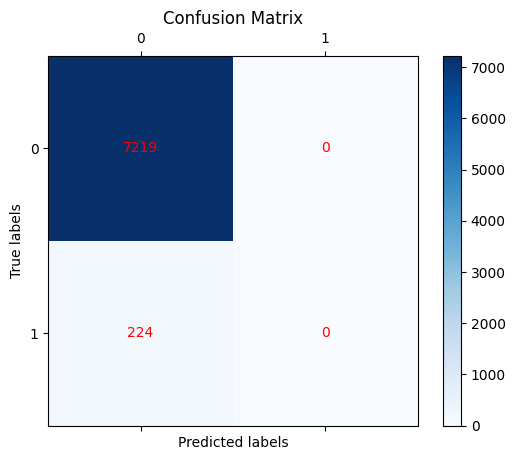

In [151]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')    
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                        Coefficient
DepositType_No_Deposit     0.217994
Is_Country_PRT             0.159076
TotalOfSpecialRequests     0.053771
AverageDailyRate          -0.014288
PreviousCancellations     -0.017910
ArrivalWeekNumber         -0.058442
LeadTime                  -0.427147


<Figure size 10000x4000 with 0 Axes>

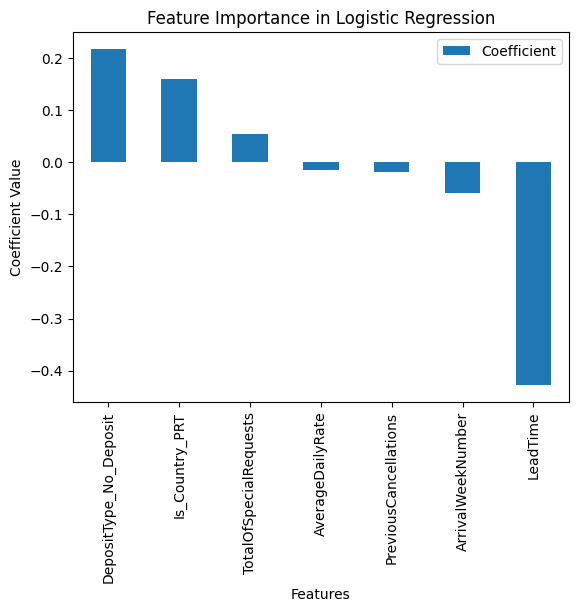

In [152]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(100, 40))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [153]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Cohen's Kappa Score: 0.0
AUC Score: 0.5
Accuracy: 0.9699046083568453
Precision: 0.9699046083568453
Recall: 1.0
F1 Score: 0.9847224116764425


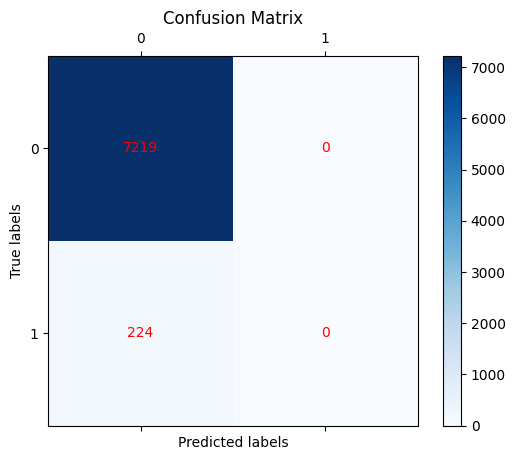

In [154]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [155]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[1.21197893e-05 1.03267309e-05 8.62781463e-06 6.57315198e-06
 1.72141695e-05 5.86766721e-06 2.07665004e-05]


### Random Forest

In [156]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Cohen's Kappa Score: 0.03366453081205767
AUC Score: 0.5088593097579799
Accuracy: 0.9703076716377804
Precision: 0.9704221564936811
Recall: 0.999861476658817
F1 Score: 0.9849218803302177


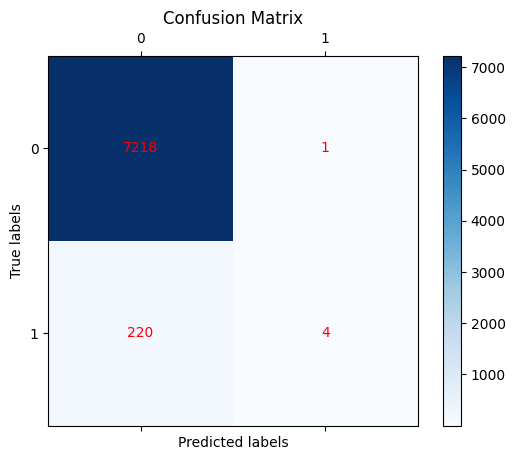

In [157]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

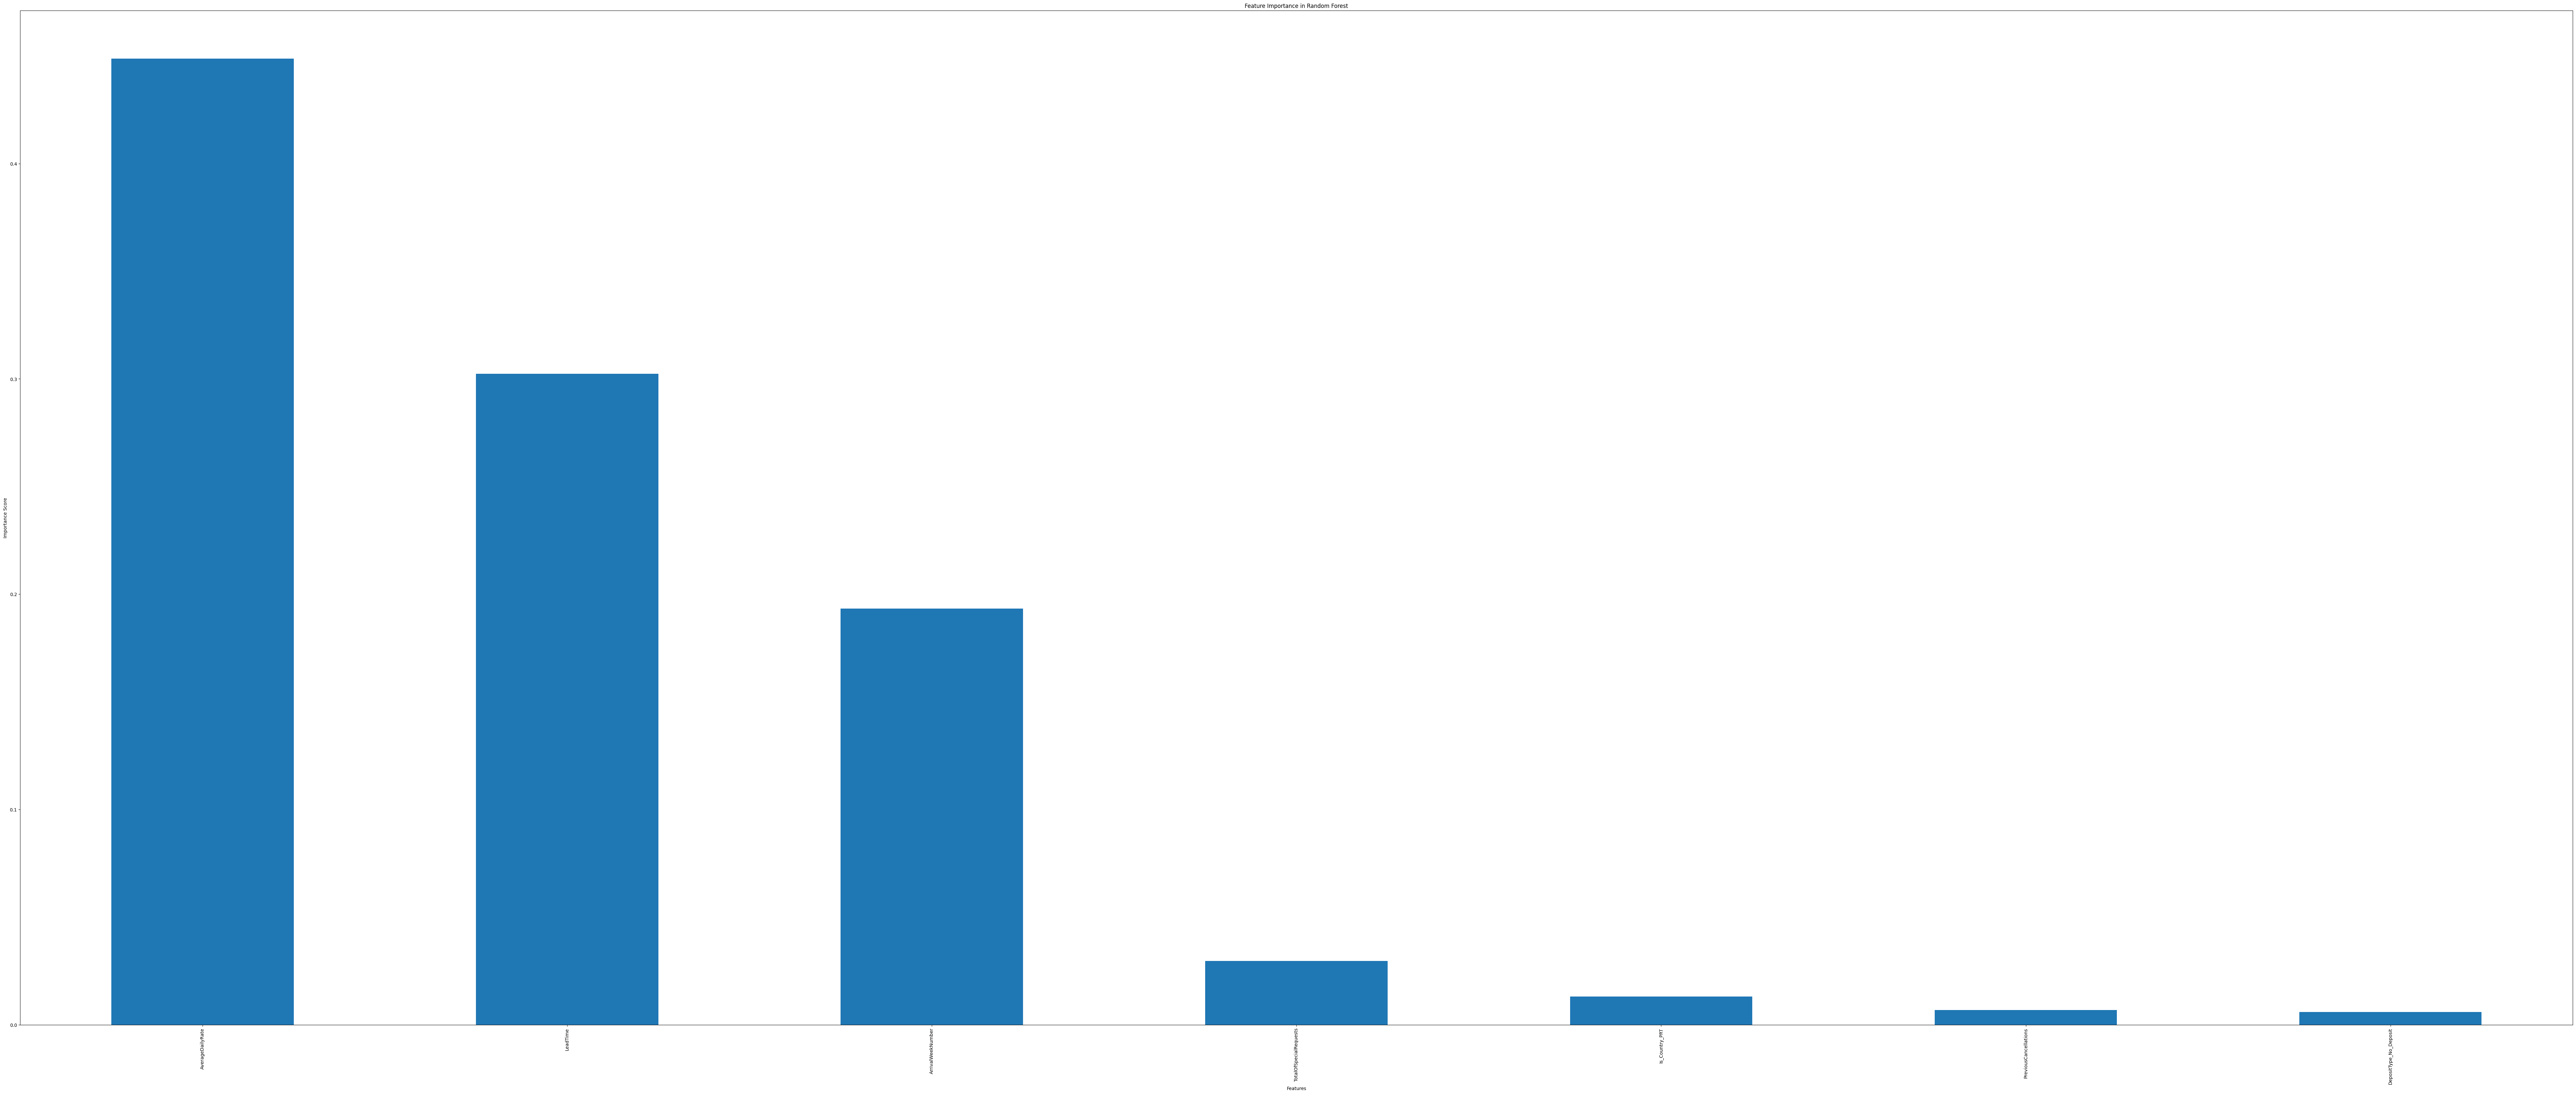

In [158]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGBoost

In [159]:
y_train = y_train.reset_index(drop=True)
for i in range(len(y_train)):
    y_train[i] = y_train[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [160]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.025286512837332298
AUC Score: 0.5066271669008371
Accuracy: 0.9701733172108021
Precision: 0.75
Recall: 0.013392857142857142
F1 Score: 0.02631578947368421


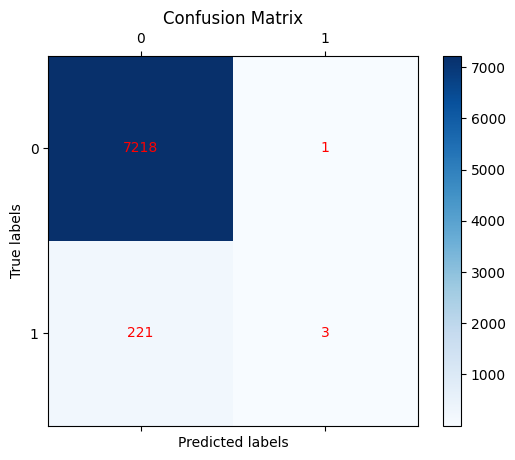

In [161]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

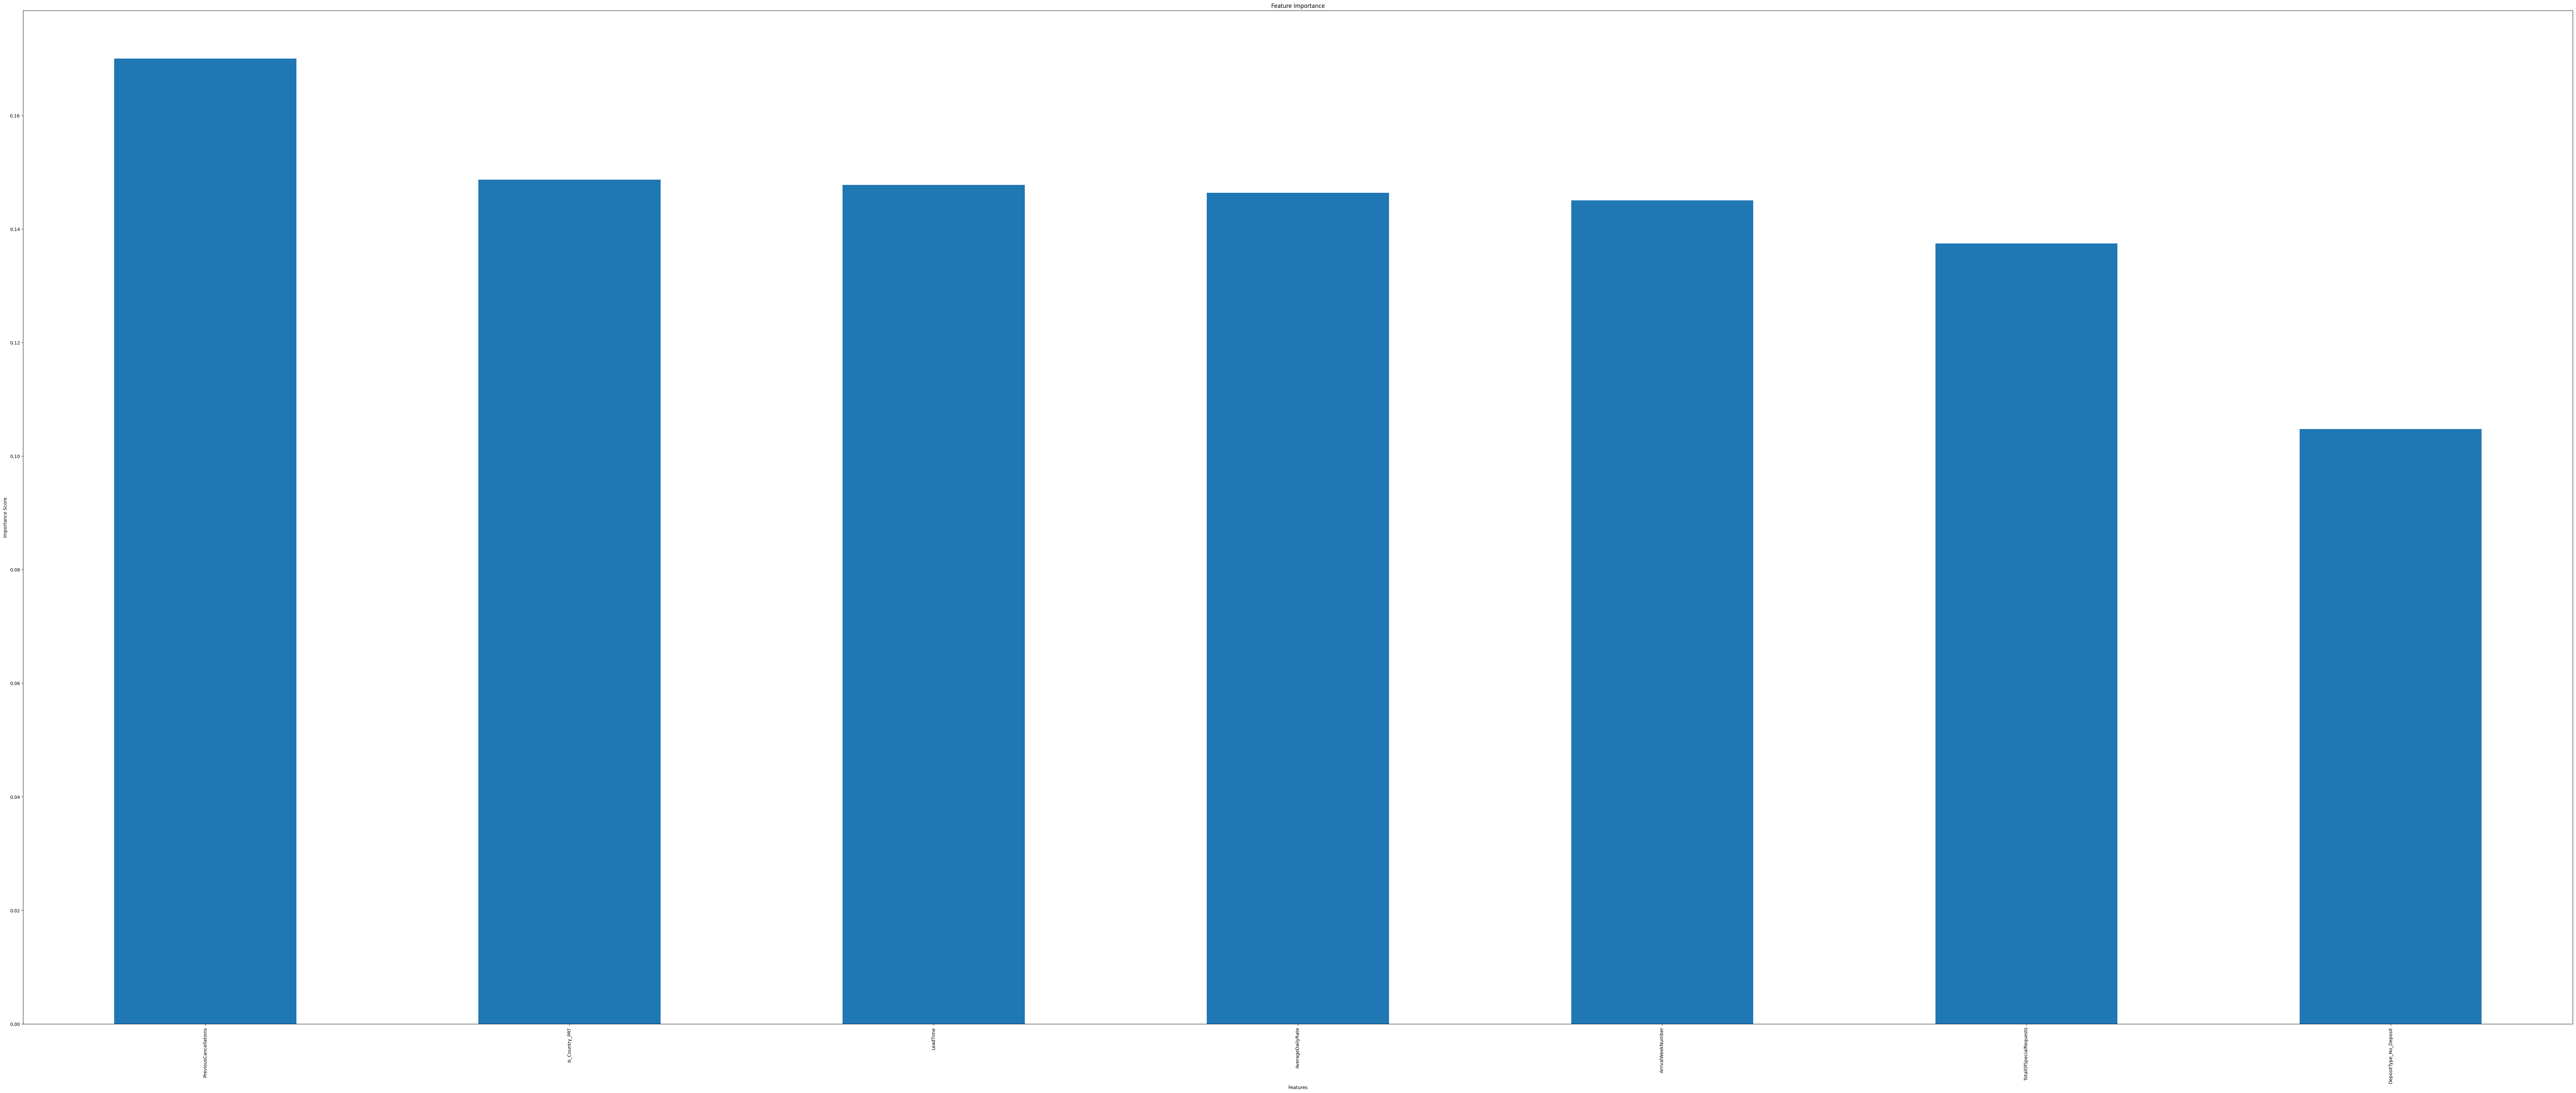

In [162]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Feature Engineering- Ealy and Late(30 days)

In [ ]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/Work/Job/Full Time/Taiwan/Interview/友達/project/GHR_Cancellation_Analysis/Data/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [164]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 30:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 30:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)

In [165]:
#filter out no cancellation data
Cancel_Data = Data[Data["CancelType"]!=0].reset_index(drop=True)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          HB   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          BB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
34719               0             NaN                      TA/TO          SC   
34720               0             NaN                      TA/TO          BB   
34721               0             NaN                      TA/TO          BB   
34722               0             NaN                      TA/TO          BB   
34723               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousCancellations  RepeatedGuest  \
0                 0.0     ITA  ...                     0              0   
1                 0.0     CHE  ...                     0              0   
2                 0.0     PRT  ...                     0              0   
3                 0.0     PRT  ...                     0              0   
4                 0.0     PRT  ...                     0              0   
...               ...     ...  ...                   ...            ...   
34719             0.0     CHN  ...                     0              0   
34720             0.0     PRT  ...                     0              0   
34721             0.0     DEU  ...                     0              0   
34722             0.0     FRA  ...                     0              0   
34723             0.0     PRT  ...                     1              0   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
0                2015-07-09             A                    2   
1                2017-05-02             D                    1   
2                2017-01-24             A                    0   
3                2017-04-12             A                    0   
4                2016-01-21             A                    0   
...                     ...           ...                  ...   
34719            2017-07-17             A                    1   
34720            2017-01-16             A                    1   
34721            2017-05-02             D                    1   
34722            2017-09-28             D                    1   
34723            2017-07-23             A                    2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719                  2                   

<function matplotlib.pyplot.show(close=None, block=None)>

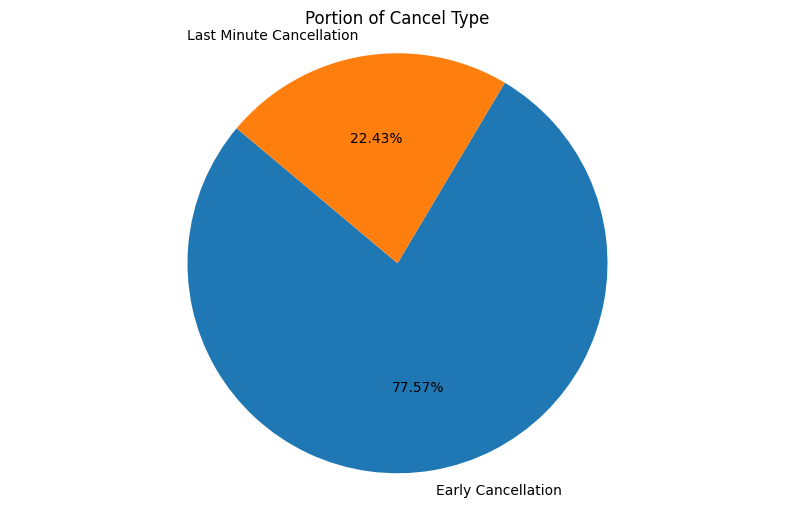

In [166]:
Counts_CancelType = Cancel_Data['CancelType'].value_counts()

# Plotting the pie chart of the portion of cancellation type
plt.figure(figsize=(10, 6))
label_index = ["Early Cancellation", "Last Minute Cancellation"]
plt.pie(Counts_CancelType, labels=label_index , autopct='%1.2f%%', startangle=140)
plt.axis('equal') 
plt.title('Portion of Cancel Type')
plt.show

In [167]:
#drop BookingCompany and other record contain null value
Cancel_Data.drop('BookingCompany', axis=1, inplace=True)
Cancel_Data = Cancel_Data.dropna()
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   
34723               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         ITA  Transient-Party  ...                      0             0   
1         CHE        Transient  ...                      0             0   
2         PRT        Transient  ...                      0             0   
3         PRT        Transient  ...                      0             0   
4         PRT  Transient-Party  ...                      0             0   
...       ...              ...  ...                    ...           ...   
34719     CHN        Transient  ...                      0             0   
34720     PRT        Transient  ...                      0             0   
34721     DEU        Transient  ...                      0             0   
34722     FRA        Transient  ...                      0             0   
34723     PRT  Transient-Party  ...                      1             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2015-07-09            A                     2   
1                 2017-05-02            D                     1   
2                 2017-01-24            A                     0   
3                 2017-04-12            A                     0   
4                 2016-01-21            A                     0   
...                      ...          ...                   ...   
34719             2017-07-17            A                     1   
34720             2017-01-16            A                     1   
34721             2017-05-02            D                     1   
34722             2017-09-28            D                     1   
34723             2017-07-23            A                     2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719              

## Preproessing

In [168]:
Cancel_Data = Cancel_Data[Cancel_Data['AverageDailyRate'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['LeadTime'] <= 300]
Cancel_Data = Cancel_Data[Cancel_Data['NumberOfAdult'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['DaysInWaitingList'] <= 14]
Cancel_Data  = Cancel_Data[Cancel_Data['StaysInWeekNights'] + Cancel_Data['StaysInWeekendNights'] > 0]

In [169]:
Cancel_Data['ArrivalDate'] = pd.to_datetime(Cancel_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Cancel_Data['AssignedRoom'] = Cancel_Data['AssignedRoom'].str.replace(' ','')
Cancel_Data['ReservedRoom'] = Cancel_Data['ReservedRoom'].str.replace(' ','')

In [170]:
# Family
Cancel_Data['Is_family'] = (Cancel_Data['NumberOfChildren'] > 0) | (Cancel_Data['NumberOfBabies'] > 0)
Cancel_Data['Is_family'] = Cancel_Data['Is_family'].astype(int)

In [171]:
# Weekend & total of night
Cancel_Data['Is_weekend'] = (Cancel_Data['StaysInWeekendNights'] > 0).astype(int)
Cancel_Data['TotalNights'] = Cancel_Data['StaysInWeekendNights'] + Cancel_Data['StaysInWeekNights']

In [172]:
#Add new Column Is_Country_PRT(1 means yes)
Cancel_Data['Is_Country_PRT'] = (Cancel_Data['Country'] == 'PRT').astype(int)
#Add new Column Is_Country_PRT(1 means yes)
Cancel_Data['DepositType_No_Deposit'] = (Cancel_Data['DepositType'] == 'No Deposit').astype(int)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
7      2015-10-16                 42            A             89.62   
...           ...                ...          ...               ...   
34718  2017-09-02                 35            D            114.00   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
7                   0                      TA/TO          HB             0.0   
...               ...                        ...         ...             ...   
34718               0                      TA/TO          BB             0.0   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  StaysInWeekNights TotalOfSpecialRequests  \
0         ITA  Transient-Party  ...                  1                      0   
1         CHE        Transient  ...                  3                      1   
2         PRT        Transient  ...                  2                      0   
3         PRT        Transient  ...                  1                      1   
7         PRT        Transient  ...                  2                      0   
...       ...              ...  ...                ...                    ...   
34718     ESP        Transient  ...                  2                      0   
34719     CHN        Transient  ...                  2                      0   
34720     PRT        Transient  ...                  3                      0   
34721     DEU        Transient  ...                  4                      0   
34722     FRA        Transient  ...                  2                      2   

       TravelAgent days_difference  CancelType  Is_family  Is_weekend  \
0             17.0              47           1          0           1   
1              9.0             105           1          0           1   
2            154.0             139           1          0           0   
3              9.0              42           1          0           0   
7              1.0              98           1          0           0   
...            ...             ...         ...        ...         ...   
34718          9.0              86           1          0           1   
34719          9.0              68           1          0           1   
34720         37.0             249           1          0           1   
34721          9.0             127           1          0           1   
34722          9.0              43           1          0           1   

       TotalNights  Is_Country_PRT  DepositType_No_Deposit  
0                3               0                       1  
1                4               0                       1  
2                2               1                       0  
3                1               1                       1  
7                2               1   

In [173]:
#Select Feature
Cancel_Data = Cancel_Data[['Is_Country_PRT','LeadTime', 'DepositType_No_Deposit', 'PreviousCancellations', 'TotalOfSpecialRequests','CancelType','AverageDailyRate','ArrivalWeekNumber']]
Cancel_Data

Is_Country_PRT  LeadTime  DepositType_No_Deposit  \
0                   0       117                       1   
1                   0       265                       1   
2                   1       151                       0   
3                   1        86                       1   
7                   1       279                       0   
...               ...       ...                     ...   
34718               0       156                       1   
34719               0        15                       1   
34720               1        15                       1   
34721               0        10                       1   
34722               0        62                       1   

       PreviousCancellations  TotalOfSpecialRequests  CancelType  \
0                          0                       0           1   
1                          0                       1           1   
2                          0                       0           1   
3                          0                       1           1   
7                          1                       0           1   
...                      ...                     ...         ...   
34718                      0                       0           1   
34719                      0                       0           1   
34720                      0                       0           1   
34721                      0                       0           1   
34722                      0                       2           1   

       AverageDailyRate  ArrivalWeekNumber  
0                 94.51                 35  
1                124.99                 33  
2                130.17                 24  
3                120.90                 21  
7                 89.62                 42  
...                 ...                ...  
34718            114.00                 35  
34719            108.55                 38  
34720            100.65                 38  
34721            196.94                 36  
34722             96.94                 45  

[24810 rows x 8 columns]

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [174]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Logistic regression

In [175]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42, solver='liblinear')

/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Cohen's Kappa Score: 0.0
AUC Score: 0.5
Accuracy: 0.7358591965605267
Precision: 0.7358591965605267
Recall: 1.0
F1 Score: 0.8478328173374613


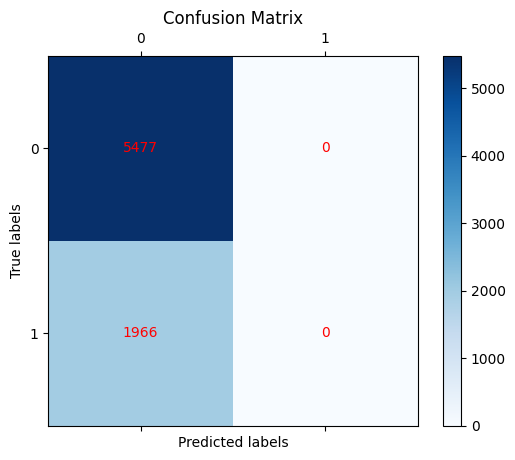

In [176]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')    
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                        Coefficient
DepositType_No_Deposit     0.160748
PreviousCancellations      0.115171
TotalOfSpecialRequests     0.094537
ArrivalWeekNumber          0.081186
Is_Country_PRT             0.056837
AverageDailyRate          -0.064868
LeadTime                  -0.582136


<Figure size 10000x4000 with 0 Axes>

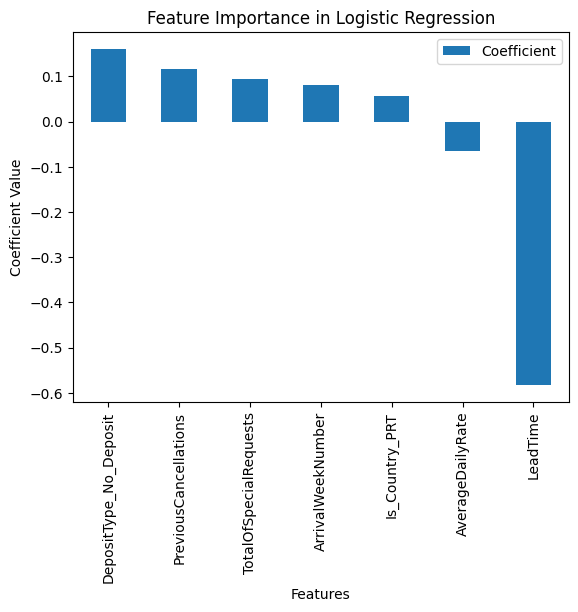

In [177]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(100, 40))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [178]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Cohen's Kappa Score: 0.0
AUC Score: 0.5
Accuracy: 0.7358591965605267
Precision: 0.7358591965605267
Recall: 1.0
F1 Score: 0.8478328173374613


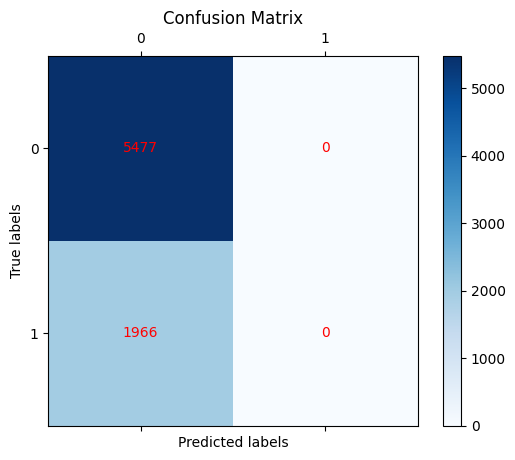

In [179]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [180]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[2.37200166e-05 2.14454619e-05 5.33411398e-06 1.25103253e-05
 4.25161308e-05 2.44416665e-05 4.13794296e-06]


### Random Forest

In [181]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Cohen's Kappa Score: 0.1691173836524288
AUC Score: 0.5716827290894262
Accuracy: 0.7261856778180841
Precision: 0.7682108875370457
Recall: 0.8992148986671535
F1 Score: 0.8285666218034994


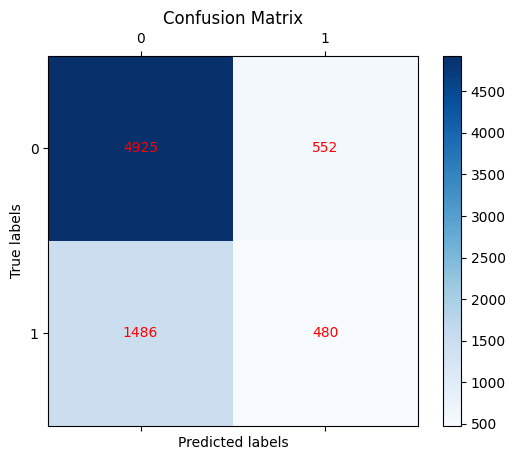

In [182]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary') 
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                 
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

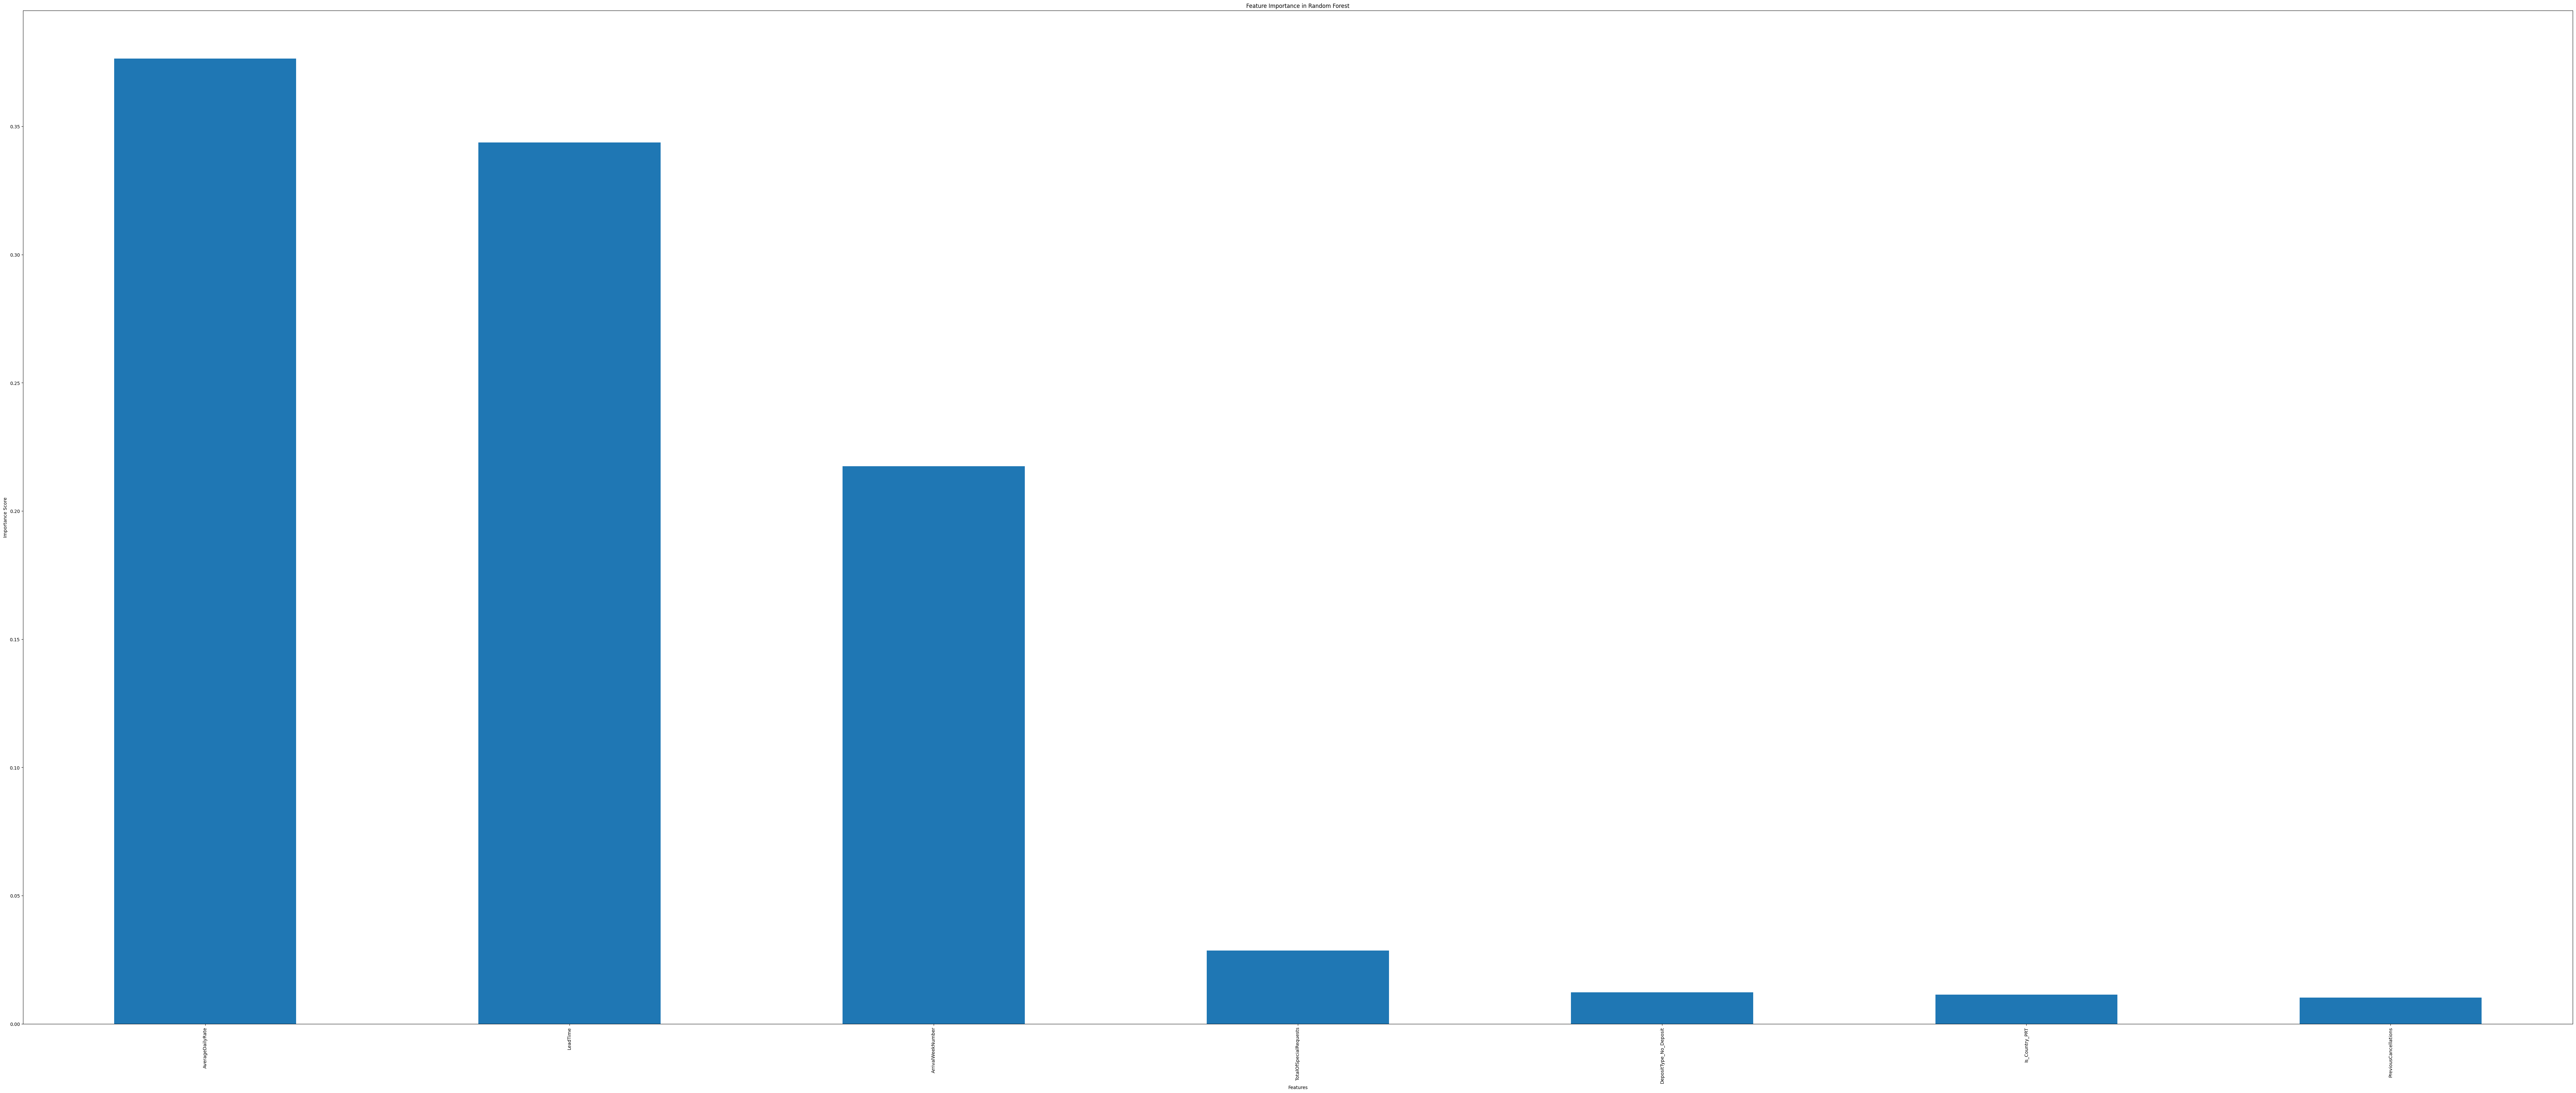

In [183]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGBoost

In [184]:
y_train = y_train.reset_index(drop=True)
for i in range(len(y_train)):
    y_train[i] = y_train[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [185]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Cohen's Kappa Score: 0.15317243845704753
AUC Score: 0.5628265876853749
Accuracy: 0.7299476017734784
Precision: 0.47453703703703703
Recall: 0.20854526958290945
F1 Score: 0.28975265017667845


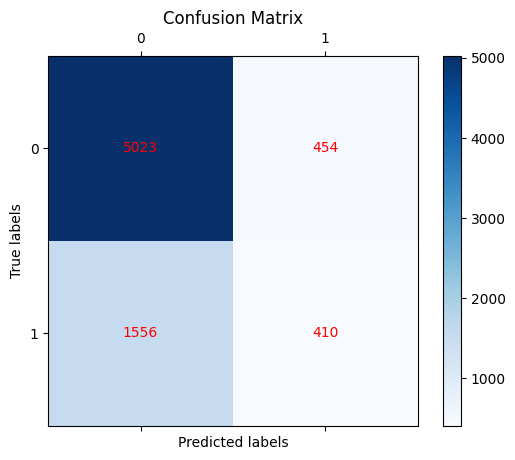

In [186]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')
auc_score = roc_auc_score(y_test, predictions)
kappa_score = cohen_kappa_score(y_test, predictions)

print(f"Cohen's Kappa Score: {kappa_score}")
print(f'AUC Score: {auc_score}')                  
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

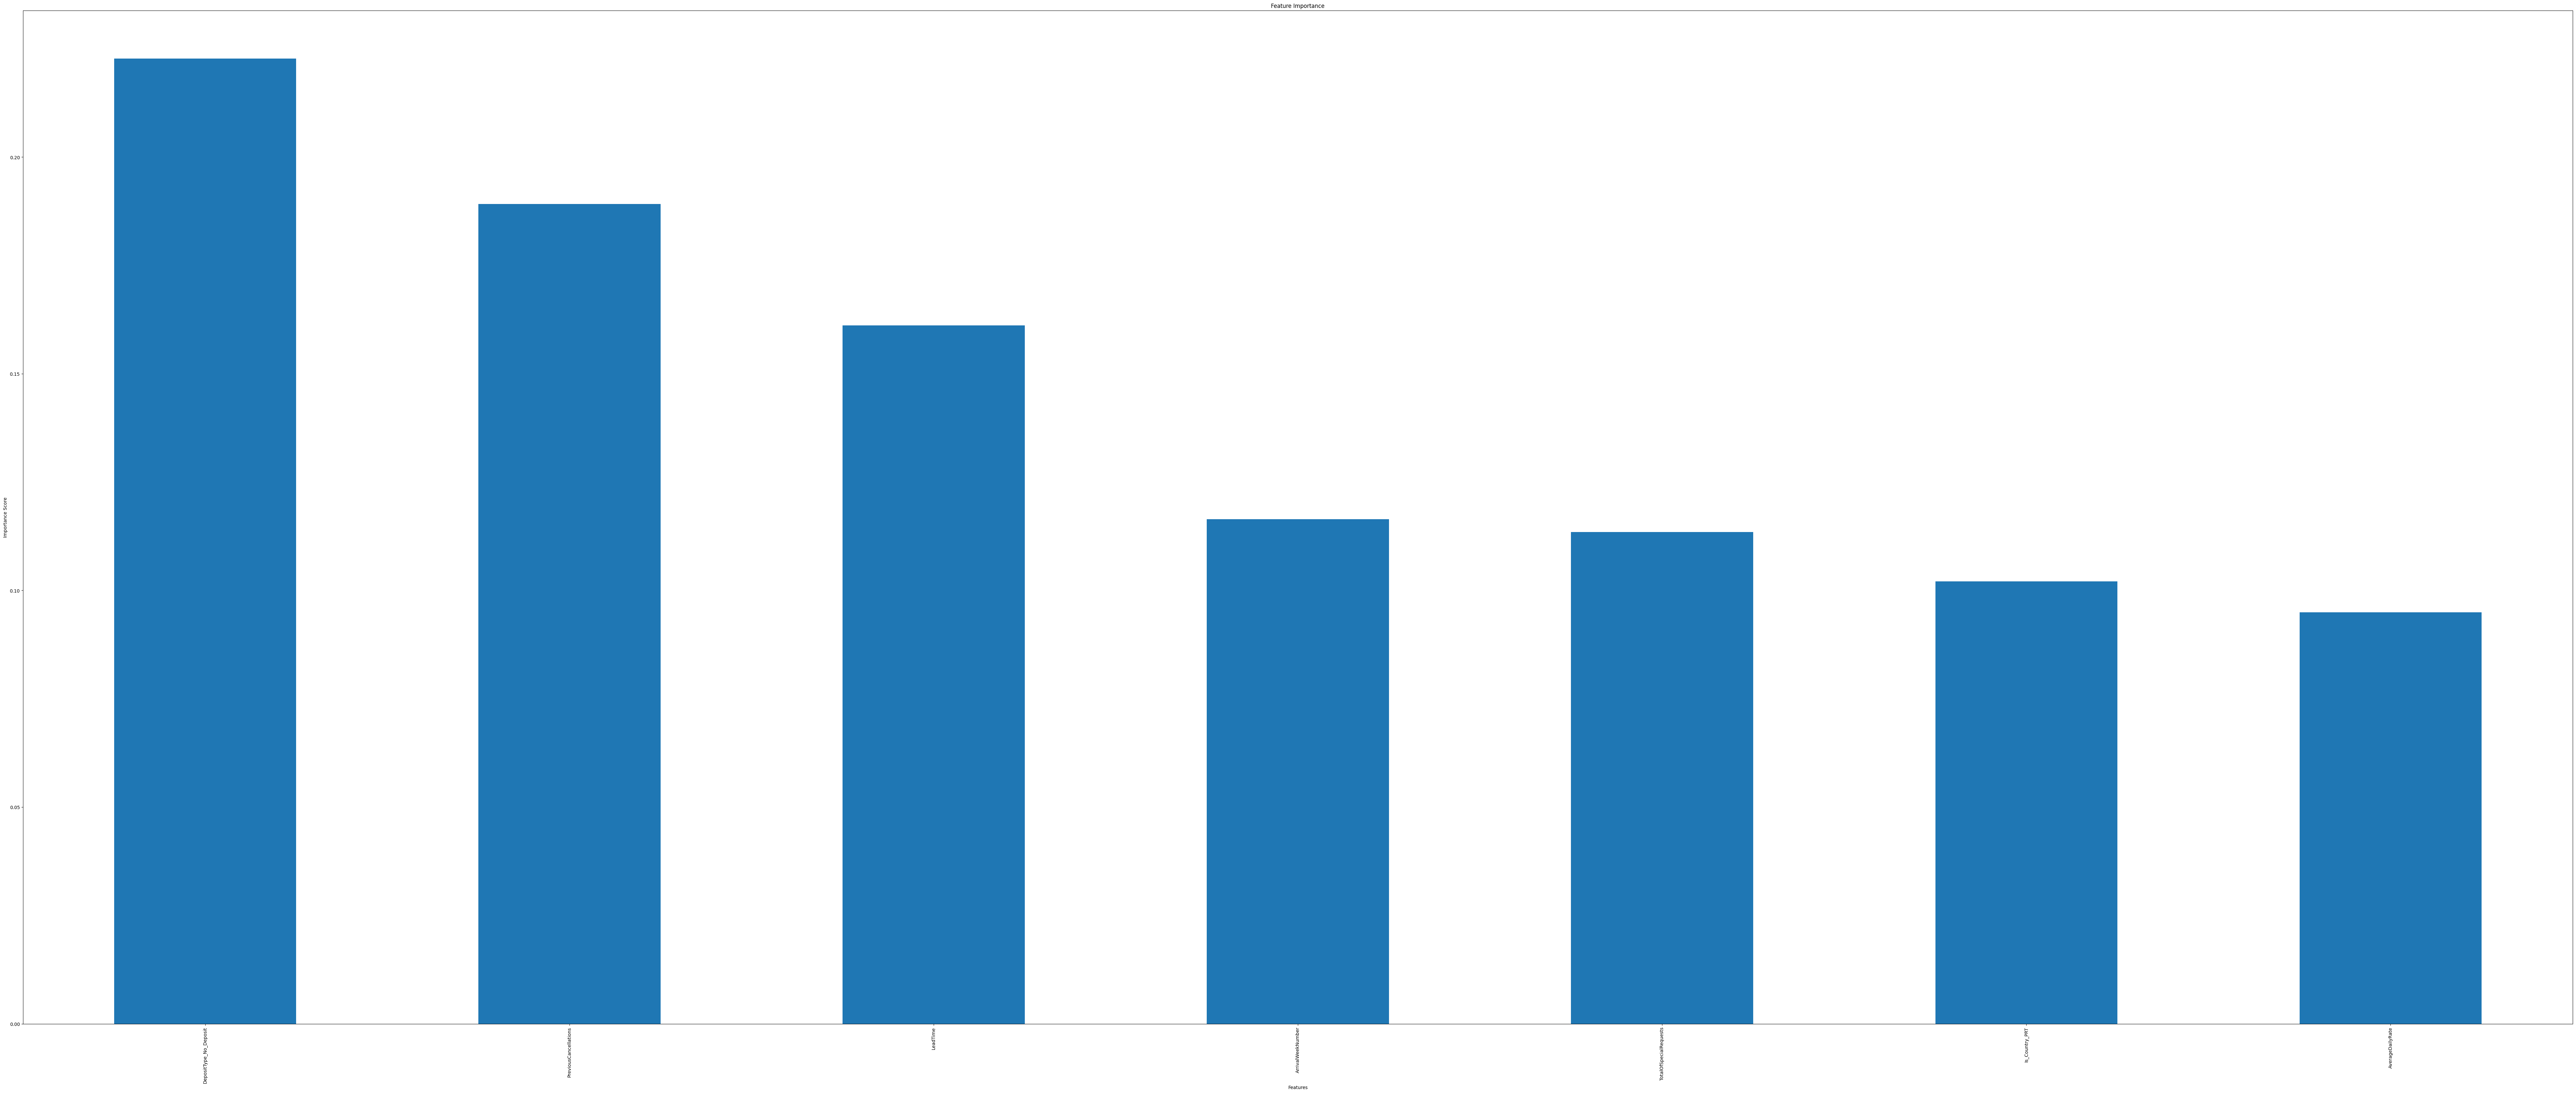

In [187]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Revenue Contribution of Last Minute Cancellation penalty

In [ ]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/Work/Job/Full Time/Taiwan/Interview/友達/project/GHR_Cancellation_Analysis/Data/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [225]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 5:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 5:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)

In [226]:
#filter out no cancellation data
Data['TotalNights'] = Data['StaysInWeekendNights'] + Data['StaysInWeekNights']
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2017-08-14                 33            A             78.49   
1      2017-04-24                 17            A            113.86   
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
4      2016-10-12                 41            A            129.25   
...           ...                ...          ...               ...   
94359  2017-09-18                 38            F            190.87   
94360  2017-09-24                 38            A            171.88   
94361  2017-11-28                 48            A             88.68   
94362  2017-11-03                 44            A             72.41   
94363  2017-09-19                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... RepeatedGuest  ReservationStatusDate  \
0                 0.0     BRA  ...             0             2017-08-21   
1                 0.0     AUT  ...             0             2017-04-27   
2                 0.0     ITA  ...             0             2015-07-09   
3                 0.0     CHE  ...             0             2017-05-02   
4                 0.0     PRT  ...             0             2016-10-16   
...               ...     ...  ...           ...                    ...   
94359             0.0     PRT  ...             0             2017-09-20   
94360             0.0     PRT  ...             0             2017-07-23   
94361             0.0     NLD  ...             0             2017-12-29   
94362             0.0     AUS  ...             0             2017-11-05   
94363             0.0     PRT  ...             0             2017-09-20   

      ReservedRoom  StaysInWeekendNights StaysInWeekNights  \
0                A                     2                 4   
1                A                     2                 2   
2                A                     2                 1   
3                D                     1                 3   
4                A                     0                 2   
...            ...                   ...               ...   
94359            D                     1                 2   
94360            A                     2                 1   
94361            A                     2                 2   
94362            A                     0                 1   
94363            A                     1                 2   

       TotalOfSpecialRequests  TravelAgent  days_difference  CancelType  \
0                           2          9.0               -7           0   
1                           0         21.0               -3           0   
2                           0         17.0               47           1   
3                           1          9.0              105           1   
4                           2          9.0               -4           0   
...                       ...          ...              ...         ...   
94359                

In [ ]:
# Calculate Revenue(Revenue = Average Daily Rate * Length of stay)
Data['Revenue'] = Data["AverageDailyRate"] * Data['TotalNights']
#The penalty of last minute cancellation is cost of one night stay
Data["Penalty"] = Data["AverageDailyRate"]

In [228]:
Total_Revenue = Data[Data["CancelType"]==0]["Revenue"].sum()+Data[Data["CancelType"]==2]["Penalty"].sum()
Revenue_Contribution = (Data[Data["CancelType"]==2]["Penalty"].sum())/Total_Revenue
Num_of_late_cancel = len(Data[Data["CancelType"]==2])
print("Num_of_late_cancel: "+str(Num_of_late_cancel))
print("Revenue_Contribution: "+str(Revenue_Contribution))

Num_of_late_cancel: 1481
Revenue_Contribution: 0.009028167420661896


#3 days  
Num_of_late_cancel: 934  
Revenue_Contribution: 0.005731065446159441  
#5 days 
Num_of_late_cancel: 1481  
Revenue_Contribution: 0.009028167420661896  
#7 days 
Revenue_Contribution: 2051  
Revenue_Contribution: 0.012423075106679246  